This notebook converts ball-by-ball match data to overs all. And all other prelimenary tasks for contribution calculation.






In [1]:
import numpy as np
import pandas as pd
import urllib.request
import json
import csv
import os
from bs4 import BeautifulSoup
import sys
import seaborn as sns
import math

from datetime import date

from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
import scipy.cluster.hierarchy as sch


from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold # import KFold


from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import linear_model


In [2]:
#matchinProgressDataFolder = 'C:/python/Scripts/JupyterNotebooks/matchInProgress/'

matchinProgressDataFolder = 'C:/python/Scripts/JupyterNotebooks/matchInProgress/InningsOverRecordsBeforeOverBowled/'

In [3]:
#allMatchSummary = pd.read_csv(str(matchinProgressDataFolder)+'startOfInning1Projection_playerClustCount_Complete_removingOutZlessEq1.csv', sep=',')

allMatchSummary = pd.read_csv('C:/python/Scripts/JupyterNotebooks/matchSummary/allODIMatchesSummary_DetailInfo_2001_2019.csv', sep=',')


#allMatchSummary.drop(['Unnamed: 0'], axis=1, inplace=True)
print(len(allMatchSummary))
allMatchSummary.year.unique()

2552


array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

### Over-Over aggregate for all match keeping record of wicket lost and bowlers

In [4]:
#matchSummariesLocation =  'C:/python/All_ODIs_2001_19_top10Teams/' #'F:/LUMS/Cricket Data/Data Files/All ODIs/'

############### innings Parameter #################################

inngs=2


#######################



matchSummariesLocation= 'C:/python/Scripts/JupyterNotebooks/AllODIs_extractOn11Feb20/'

list_of_files = os.listdir(matchSummariesLocation)

currentOver=2


matchRecordFile = open(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogress_Inng'+str(inngs)+'_over1_50Records_2001_19.csv','w')
#print(matchRecordFile)
matchRecordFile.write('matchId,year,venueCountry,team1,team2,homeTeam,toss_winner_team,inning1Runs,inning1RunRate,innings1Wickets,inning2Runs,inning2RunRate,inning2RunsExpected,innings2Wickets,')

for i in range(11):
    matchRecordFile.write('batsman,')
for i in range(11):
    matchRecordFile.write('bowler,')
    
matchRecordFile.write('onCreasebatsman1,')
matchRecordFile.write('bats1CurrOvrRuns,')  
matchRecordFile.write('bats1CurrOvrBalls,')  
matchRecordFile.write('bats1TotalRuns,')    
matchRecordFile.write('bats1TotalBalls,') 

matchRecordFile.write('onCreasebatsman2,')
matchRecordFile.write('bats2CurrOvrRuns,')  
matchRecordFile.write('bats2CurrOvrBalls,') 
matchRecordFile.write('bats2TotalRuns,')   
matchRecordFile.write('bats2TotalBalls,')

matchRecordFile.write('totalRunsScoredCurrentOvr,') 
matchRecordFile.write('totalRunsScoredtillNow,') 
matchRecordFile.write('onCreasebowlerOfTheOvr,') 
matchRecordFile.write('overId,') 
matchRecordFile.write('wicket,') 
matchRecordFile.write('wicket,') 
matchRecordFile.write('wicket,wicket,wicket,wicket')

matchRecordFile.write('\n')

if(inngs==1):
    inningsId='inn1'
else:
    inningsId='inn2'


teamName =  ['England','Australia','South Africa','West Indies','New Zealand','India','Pakistan','Sri Lanka','Zimbabwe','Bangladesh']

filter1 =  allMatchSummary['team1'].isin(teamName)
filter2 =  allMatchSummary['team2'].isin(teamName)
filter3 =  allMatchSummary['rain_rule']!=1
filter4 =  allMatchSummary['winnerTeam']!='tied'
filter5 =  allMatchSummary['winnerTeam']!='no result'
matchSummariesFiltered = allMatchSummary[filter1 & filter2 & filter3 & filter4 & filter5]
print('matchesCount', len(matchSummariesFiltered))
matchCount=0
#matchIds =  ['66277']#,'66331','66332','66333','66334','66336','66337','66338','66339']
for matchId in matchSummariesFiltered['matchId']: # matchIds:#  
    matchCount=matchCount+1
    if(matchCount%100==0):
        print('done',matchCount)
        
#        break
    for matchFile in list_of_files:
        try:
            matchIdinFile = matchFile.split('_')[0]
            
            if(matchIdinFile.find("new")>=0):
                fileMatchId = matchIdinFile[3:]
            else:
                fileMatchId= matchIdinFile
                    
            #print(fileMatchId,matchId)
            if str(matchId)==str(fileMatchId):# matchIdinFile.contains(str(matchId)):
                #print(matchFile)
                
                data_file = open(matchSummariesLocation+str(matchFile))
                
                data = json.load(data_file)
                
                
                
                if(len(data['runs']['inn'+str(inngs)])>1):
                    
                    overId=0
                    
                    
                    runsScoredtillNow=0
                    
                    runsScored=0
                    
                    runsCurrOvrbyBatsman1=0
                    runsCurrOvrbyBatsman2=0
                    
                    ballsCurrOvrbyBatsman1=0
                    ballsCurrOvrbyBatsman2=0
                    
                    playersCurrOvrScores= np.zeros(11)
                    playersCurrOvrBalls = np.zeros(11)
                    
                    
                    batsmenOnCrease =[]
                    playersScores= np.zeros(11)
                    playersBalls = np.zeros(11)
                    wicketsLost={}
                    ballNo=0
                    wicketLostinOvr=[]
                    for i in range(len(data['teams']['t'+str(inngs)]['w'])):
                        ovr,ball = str(data['teams']['t'+str(inngs)]['w'][int(i)]['ovr']).split('.')
                        ballNo = (6*int(ovr))+int(ball)
                        ovr = int(ovr)+1
                        wicketsLost[ballNo] = str(data['teams']['t'+str(inngs)]['w'][int(i)]['out'])
                        
                    matchdata = matchSummariesFiltered[matchSummariesFiltered['matchId']==int(matchId)].iloc[0]  
                    
                    for i in range(len(data['runs']['inn'+str(inngs)])): 
                        batsmanId = str(data['runs']['inn'+str(inngs)][int(i)]['bat'])
                        ovr,ball = str(data['runs']['inn'+str(inngs)][int(i)-1]['ovr']).split('.')
                        ballNo = (6*int(ovr))+int(ball)
                       
                        team1Players=[]
                        for p in range(11):      
                            team1Players.append(str(data['teams']['t'+str(inngs)]['p'][int(p)]['id']))
#                         print("ball", ballNo)
#                         print('batsmen on Crease',batsmenOnCrease)
#                         print('batsmanId',batsmanId)

                        
                        if(batsmanId not in batsmenOnCrease):
                            batsmenOnCrease.append(batsmanId)
                        
                        if ballNo in wicketsLost.keys() and str(wicketsLost[ballNo]) in batsmenOnCrease:
                            #print('wicket on this',wicketsLost[ballNo],'ball No',ballNo )
                            batsmenOnCrease.remove((wicketsLost[ballNo]))

#                             if 1==1:# (len(batsmenOnCrease)>=2):
#                                 print("ball in If", ballNo)
#                                 if(ballNo in wicketsLost.keys() and str(wicketsLost[ballNo]) in batsmenOnCrease):
#                                     #print("out", ballNo)
#                                     print('batsmanId',batsmanId)
#                                     #wicketLostinOvr.append(str(wicketsLost[ballNo]))
#                                     #batsmenOnCrease.remove((wicketsLost[ballNo]))
#                                     #batsmenOnCrease.append(batsmanId)
#                                     #print()
#                                     print('this man out',wicketsLost[ballNo],'ball No',ballNo )
                                    
#                                 else:
#                                     if(int(i)>0):
#                                         #batsmenOnCrease.remove(str(data['runs']['inn1'][int(i)-1]['bat']))
#                                         #remove((wicketsLost[ballNo]))
#                                         #
#                                         print('esle')
#                             #else:
#                             #batsmenOnCrease.append(batsmanId)
                        
                        ovr,ball = str(data['runs']['inn'+str(inngs)][int(i)]['ovr']).split('.')
                        ballNo = (6*int(ovr))+int(ball)
                        ovr = int(ovr)+1
                        
                        
                        
                        
                        runsScored = runsScored + int(data['runs']['inn'+str(inngs)][int(i)]['r_t'])
                        
                        ### each batsmen runs scored and balls faced
                        playerIndx = team1Players.index(str(data['runs']['inn'+str(inngs)][int(i)]['bat']))
                        playersScores[playerIndx] = playersScores[playerIndx]+ int(data['runs']['inn'+str(inngs)][int(i)]['r'])
                        
                        playersCurrOvrScores[playerIndx] = playersCurrOvrScores[playerIndx]+ int(data['runs']['inn'+str(inngs)][int(i)]['r'])
                        
                        if(i<len(data['runs']['inn'+str(inngs)])-1):
                            if(str(data['runs']['inn'+str(inngs)][int(i)]['ovr'])!=str(data['runs']['inn'+str(inngs)][int(i)+1]['ovr'])):  
                                playersBalls[playerIndx] = playersBalls[playerIndx]+ 1
                                playersCurrOvrBalls[playerIndx] = playersCurrOvrBalls[playerIndx]+ 1
                                
                        else:
                            playersBalls[playerIndx] = playersBalls[playerIndx]+ 1
                            playersCurrOvrBalls[playerIndx] = playersCurrOvrBalls[playerIndx]+ 1
                                
                        
                        if(ballNo in wicketsLost.keys()):    ### Wicket lost track
                                if(wicketsLost[ballNo] not in wicketLostinOvr):
                                    wicketLostinOvr.append(str(wicketsLost[ballNo]))
                          
                        if((ballNo%6==0) or (ballNo%6!=0 and i ==len(data['runs']['inn'+str(inngs)])-1)): #ballNo>294 and
                            
                            overId=overId+1
                            
                            #print(matchdata['team1'])
                            #print(matchdata['team1']+ '  '+ matchdata['team2'])
                            matchRecordFile.write(str(matchdata['matchId']))
                            matchRecordFile.write(',')
                            matchRecordFile.write(str(matchdata['year']))
                            matchRecordFile.write(',')
                            matchRecordFile.write(matchdata['country_name'])
                            matchRecordFile.write(',')
                            matchRecordFile.write( str(data['teams']['t1']['n']))#  #matchdata['team1'])
                            matchRecordFile.write(',')
                            matchRecordFile.write(str(data['teams']['t2']['n'])  )#  #matchdata['team2'])
                            matchRecordFile.write(',')
                            matchRecordFile.write(matchdata['home_team'])
                            matchRecordFile.write(',')
                            matchRecordFile.write(matchdata['toss_winner_team'])
                            matchRecordFile.write(',')
                            matchRecordFile.write(str(matchdata['innings1Runs']))
                            matchRecordFile.write(',')
                            matchRecordFile.write(str(matchdata['innings1RunRate']))
                            matchRecordFile.write(',')
                            matchRecordFile.write(str(matchdata['innings1Wickets']))
                            matchRecordFile.write(',')
                            
                            
                            matchRecordFile.write(str(matchdata['innings2Runs']))
                            matchRecordFile.write(',')
                            
                            matchRecordFile.write(str(matchdata['innings2RunRate']))
                            matchRecordFile.write(',')
                            
                            matchRecordFile.write(str(matchdata['innings2RunsExpected']))
                            matchRecordFile.write(',')
                            
                            matchRecordFile.write(str(matchdata['innings2Wickets']))
                            matchRecordFile.write(',')


                            #matchRecordFile.write(str(matchId)+',')
                            #team1Players=[]
                            if(inngs==2):
                                for p in range(11):      # batsmen of the innings 
                                    matchRecordFile.write(str(data['teams']['t2']['p'][int(p)]['id'])+',')
                                    #team1Players.append(str(data['teams']['t1']['p'][int(i)]['id']))
                                for p in range(11):
                                    matchRecordFile.write(str(data['teams']['t1']['p'][int(p)]['id'])+',')
                            else:
                                for p in range(11):      # batsmen of the innings 
                                    matchRecordFile.write(str(data['teams']['t1']['p'][int(p)]['id'])+',')
                                    #team1Players.append(str(data['teams']['t1']['p'][int(i)]['id']))
                                for p in range(11):
                                    matchRecordFile.write(str(data['teams']['t2']['p'][int(p)]['id'])+',')

#                             matchRecordFile.write('\n')
#                             break 
                            
                            matchRecordFile.write(batsmenOnCrease[0]+',')
                            #print(playersScores[ team1Players.index(str(batsmenOnCrease[0]))])
                            
                            
                            matchRecordFile.write(str(playersCurrOvrScores[team1Players.index(str(batsmenOnCrease[0]))])+',')
                            matchRecordFile.write(str(playersCurrOvrBalls[team1Players.index(str(batsmenOnCrease[0]))])+',')
                              
                            
                            matchRecordFile.write(str(playersScores[team1Players.index(str(batsmenOnCrease[0]))])+',')
                            matchRecordFile.write(str(playersBalls[team1Players.index(str(batsmenOnCrease[0]))])+',')
                              
                                  
                            if(len(batsmenOnCrease)==2):
                                matchRecordFile.write(batsmenOnCrease[1]+',')
                                
                                matchRecordFile.write(str(playersCurrOvrScores[team1Players.index(str(batsmenOnCrease[1]))])+',')
                                matchRecordFile.write(str(playersCurrOvrBalls[team1Players.index(str(batsmenOnCrease[1]))])+',')
                              
                                
                                matchRecordFile.write(str(playersScores[team1Players.index(str(batsmenOnCrease[1]))])+',')
                                matchRecordFile.write(str(playersBalls[team1Players.index(str(batsmenOnCrease[1]))])+',')
                                
                                
                            else:
                                matchRecordFile.write(str(data['runs']['inn'+str(inngs)][int(i)]['bat'])+',')#  str(data['teams']['t1']['p'][int(i)]['id'])+',')
                                matchRecordFile.write(str(0)+',')
                                matchRecordFile.write(str(0)+',')
                                matchRecordFile.write(str(0)+',')
                                matchRecordFile.write(str(0)+',')
                                #print('can I come here')

                            matchRecordFile.write(str(runsScored)+',')
                            
                            runsScoredtillNow = runsScoredtillNow + int(runsScored)
                            
                            matchRecordFile.write(str(runsScoredtillNow)+',')
                            
                            #matchRecordFile.write(str(data['runs']['inn1'][int(i)]['bat'])+',')
                            matchRecordFile.write(str(data['runs']['inn'+str(inngs)][int(i)]['bowl'])+',')
                            matchRecordFile.write(str(ovr)+',')
                            
                            for w in range(len(wicketLostinOvr)):     
                                matchRecordFile.write(str(wicketLostinOvr[w])+',')
                            
                            matchRecordFile.write('\n')
                            wicketLostinOvr.clear()
                            runsScored=0
                            playersCurrOvrScores= np.zeros(11)
                            playersCurrOvrBalls = np.zeros(11)
                    
                            #if(overId==10):
                            #break
                                          
                        
        except:
            print(matchFile)
matchRecordFile.close()

matchesCount 1731
done 100
done 200
done 300
done 400
done 500
225437_Sri Lanka_India_2_2005.json
done 600
done 700
done 800
done 900
done 1000
done 1100
done 1200
done 1300
done 1400
done 1500
done 1600
done 1700


####      Combine all overs Information, before an over is bowler ## 





In [7]:
inngs=2


######   Adding information about batsmen runs and balls before the current over was bowled  ##############

matchinProgressDataFolder = 'C:/python/Scripts/JupyterNotebooks/matchInProgress/InningsOverRecordsBeforeOverBowled/'

inprogressInngData = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogress_Inng'+str(inngs)+'_over1_50Records_2001_19.csv', header=0)



inprogressInngData['totalRunsScoredBeforeThisOvr']   = 0

inprogressInngData['bats1TotalRunsBeforeThisOvr']    = 0
inprogressInngData['bats1TotalBallsBeforeThisOvr']   = 0
inprogressInngData['bats2TotalRunsBeforeThisOvr']    = 0
inprogressInngData['bats2TotalBallsBeforeThisOvr']   = 0



inprogressInngData['totalRunsScoredBeforeThisOvr']   =  (inprogressInngData['totalRunsScoredtillNow'] - inprogressInngData['totalRunsScoredCurrentOvr'])

inprogressInngData['bats1TotalRunsBeforeThisOvr']    =  (inprogressInngData['bats1TotalRuns'] - inprogressInngData['bats1CurrOvrRuns'])
inprogressInngData['bats1TotalBallsBeforeThisOvr']   =  (inprogressInngData['bats1TotalBalls'] - inprogressInngData['bats1CurrOvrBalls'])
inprogressInngData['bats2TotalRunsBeforeThisOvr']    =  (inprogressInngData['bats2TotalRuns'] - inprogressInngData['bats2CurrOvrRuns'])
inprogressInngData['bats2TotalBallsBeforeThisOvr']   =  (inprogressInngData['bats2TotalBalls'] - inprogressInngData['bats2CurrOvrBalls'])





inprogressInngData.to_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogress_Inng'+str(inngs)+'_over1_50Records_2001_19_withBeforeOverInfo.csv', index=False)   



In [8]:

inprogressInng1 = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogress_Inng'+str(inngs)+'_over1_50Records_2001_19_withBeforeOverInfo.csv', header=0)

print(len(inprogressInng1))
inprogressInng1.fillna(0)
#inprogressInng1.drop_duplicates(keep = False, inplace = True) 

#inning1FeatureVector.drop(['Unnamed: 29'], axis=1, inplace=True)
inprogressInng1.head(1)
#inning1FeatureVector = inning1FeatureVector[(inning1FeatureVector['team1']!='Zimbabwe') & (inning1FeatureVector['team2']!='Zimbabwe')]
inprogressInng1['team2Cluster'] = inprogressInng1['team2']
inprogressInng1['team1Cluster'] = inprogressInng1['team1']



teamClusteringData = pd.read_csv("C:/python/Scripts/JupyterNotebooks/teamFeatures/teamClustering_AvgMedRuns_clust_4.csv")

teamIds  = teamClusteringData['Name']  ## Name col
teamClusts = teamClusteringData['kMeansLabel'] 
#print(teamIds)
print('team Clust',len(teamIds))
for col in inprogressInng1.columns:
    if col.startswith('team2Cluster'): 
        replace_team_clust = {col : {k: v for k,v in zip(teamIds,list(teamClusts))}}
        inprogressInng1.replace(replace_team_clust, inplace=True)
    if col.startswith('team1Cluster'):
        replace_team_clust = {col : {k: v for k,v in zip(teamIds,list(teamClusts))}}
        inprogressInng1.replace(replace_team_clust, inplace=True)
        
        

################ Adding corresponding continent for each country  ##################
worldCityCountryContinent= 'C:/python/Scripts/JupyterNotebooks/worldCityCountryContinent/'#worldcities = pd.read_csv(str(worldCityCountryContinent)+"worldCitiesForAllCountriesRemDuplicates.csv", sep=',') #RemDuplicates

worldCountryContinent = pd.read_csv(str(worldCityCountryContinent)+"countryContinentOnly.csv", sep=',')

print(worldCountryContinent.head(1))
inning1FeatureVectorVenue = pd.merge(inprogressInng1,worldCountryContinent,how='left', right_on=['Country'], left_on=['venueCountry'])
inning1FeatureVectorVenue.drop(['Country'],axis=1, inplace=True)
inning1FeatureVectorVenue.head(1)




73464
team Clust 10
       Country Continent
0  New Zealand   nonAsia


,matchId,year,venueCountry,team1,team2,homeTeam,toss_winner_team,inning1Runs,inning1RunRate,innings1Wickets,...,wicket.4,wicket.5,totalRunsScoredBeforeThisOvr,bats1TotalRunsBeforeThisOvr,bats1TotalBallsBeforeThisOvr,bats2TotalRunsBeforeThisOvr,bats2TotalBallsBeforeThisOvr,team2Cluster,team1Cluster,Continent
0,66274,2001,England,Pakistan,England,England,Pakistan,273,5.46,6,...,NaN,NaN,0,0,0,0,0,4,2,nonAsia


In [9]:
"""

 Here we perform encoding for categorical variables, like Venue Continent and Player Ids to encoded
 with corrresponding cluster ids.

"""

### Toss  winner team

inning1FeatureVectorVenue['tossWinner'] = 2
inning1FeatureVectorVenue.loc[inning1FeatureVectorVenue['toss_winner_team']==inning1FeatureVectorVenue['team1'], 'tossWinner']=1





######   Continent encoding ##########
labels = inning1FeatureVectorVenue['Continent'].astype('category').cat.categories.tolist()
replace_continent_comp = {'Continent' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
inning1FeatureVectorVenue.replace(replace_continent_comp, inplace=True)

inning1FeatureVectorVenue['venueCountryCode'] = 0
inning1FeatureVectorVenue['venueCountryCode'] =  inning1FeatureVectorVenue['venueCountry']

inning1FeatureVectorVenue['yearId'] = 0
inning1FeatureVectorVenue['yearId'] =  inning1FeatureVectorVenue['year']

#inning1FeatureVectorVenue['yearId']= inning1FeatureVectorVenue['year']

labels = inning1FeatureVectorVenue['venueCountryCode'].astype('category').cat.categories.tolist()
replace_continent_comp = {'venueCountryCode' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

inning1FeatureVectorVenue.replace(replace_continent_comp, inplace=True)



labels = inning1FeatureVectorVenue['yearId'].astype('category').cat.categories.tolist()
replace_continent_comp = {'yearId' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

inning1FeatureVectorVenue.replace(replace_continent_comp, inplace=True)


### bowlers ids with cluster encoding ###########

bowlerClustDf = pd.read_csv('C:/python/Scripts/JupyterNotebooks/bowlersFeatures/bowlersClustering_4.csv')

bowlIds  = bowlerClustDf['Id']
bowlClusts =bowlerClustDf['kMeansLabels'] 
len(bowlClusts)
for col in inning1FeatureVectorVenue.columns:
    if col.startswith('bowler'): 
        replace_continent_comp = {col : {k: v for k,v in zip(bowlIds,list(bowlClusts))}}
        inning1FeatureVectorVenue.replace(replace_continent_comp, inplace=True)
    if col.startswith('onCreasebowl'):
        replace_continent_comp = {col : {k: v for k,v in zip(bowlIds,list(bowlClusts))}}
        inning1FeatureVectorVenue.replace(replace_continent_comp, inplace=True)
        
for col in inning1FeatureVectorVenue.columns:     ### purely non-bolwers : never bowled
    if col.startswith('bowler'): 
        inning1FeatureVectorVenue.loc[inning1FeatureVectorVenue[col] >np.max(bowlClusts), col] = str(np.max(bowlClusts)+1)
    if col.startswith('onCreasebowl'):
        inning1FeatureVectorVenue.loc[inning1FeatureVectorVenue[col] >np.max(bowlClusts), col] = str(np.max(bowlClusts)+1)
   
        
### batsmen ids with cluster encoding ###########
        
batsmamClustDf = pd.read_csv('C:/python/Scripts/JupyterNotebooks/batsmanFeatures/batsmenClusters_4.csv')
batIds  = bowlerClustDf['Id']
batClusts =bowlerClustDf['kMeansLabels'] 
len(batClusts)
for col in inning1FeatureVectorVenue.columns:
    if col.startswith('batsman'): 
        replace_continent_comp = {col : {k: v for k,v in zip(batIds,list(batClusts))}}
        inning1FeatureVectorVenue.replace(replace_continent_comp, inplace=True)
    if col.startswith('onCreasebat'):
        replace_continent_comp = {col : {k: v for k,v in zip(batIds,list(batClusts))}}
        inning1FeatureVectorVenue.replace(replace_continent_comp, inplace=True)

for col in inning1FeatureVectorVenue.columns:     ### purely non-bolwers : never bowled
    if col.startswith('batsman'): 
        inning1FeatureVectorVenue.loc[inning1FeatureVectorVenue[col] >np.max(batClusts), col] = str(np.max(batClusts)+1)
    if col.startswith('onCreasebat'):
        inning1FeatureVectorVenue.loc[inning1FeatureVectorVenue[col] >np.max(batClusts), col] = str(np.max(batClusts)+1)
        
        
        
for col in inning1FeatureVectorVenue.columns:
    if col.startswith('wicket'): 
        replace_wicketId_comp = {col : {k: v for k,v in zip(batIds,list(batClusts))}}
        inning1FeatureVectorVenue.replace(replace_wicketId_comp, inplace=True)
for col in inning1FeatureVectorVenue.columns:
    if col.startswith('wicket'): 
        inning1FeatureVectorVenue.loc[inning1FeatureVectorVenue[col] >np.max(batClusts), col] = str(np.max(batClusts)+1)
        
                
        
        
inning1FeatureVectorVenue.to_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning_'+str(inngs)+'_Projection_playerClustIds.csv', index=False)    

inning1FeatureVectorVenue.head(2)
 

,matchId,year,venueCountry,team1,team2,homeTeam,toss_winner_team,inning1Runs,inning1RunRate,innings1Wickets,...,bats1TotalRunsBeforeThisOvr,bats1TotalBallsBeforeThisOvr,bats2TotalRunsBeforeThisOvr,bats2TotalBallsBeforeThisOvr,team2Cluster,team1Cluster,Continent,tossWinner,venueCountryCode,yearId
0,66274,2001,England,Pakistan,England,England,Pakistan,273,5.46,6,...,0,0,0,0,4,2,2,1,3,1
1,66274,2001,England,Pakistan,England,England,Pakistan,273,5.46,6,...,1,1,0,5,4,2,2,1,3,1


In [10]:
inning1FeatureVectorVenue.columns

Index(['matchId', 'year', 'venueCountry', 'team1', 'team2', 'homeTeam',
       'toss_winner_team', 'inning1Runs', 'inning1RunRate', 'innings1Wickets',
       'inning2Runs', 'inning2RunRate', 'inning2RunsExpected',
       'innings2Wickets', 'batsman', 'batsman.1', 'batsman.2', 'batsman.3',
       'batsman.4', 'batsman.5', 'batsman.6', 'batsman.7', 'batsman.8',
       'batsman.9', 'batsman.10', 'bowler', 'bowler.1', 'bowler.2', 'bowler.3',
       'bowler.4', 'bowler.5', 'bowler.6', 'bowler.7', 'bowler.8', 'bowler.9',
       'bowler.10', 'onCreasebatsman1', 'bats1CurrOvrRuns',
       'bats1CurrOvrBalls', 'bats1TotalRuns', 'bats1TotalBalls',
       'onCreasebatsman2', 'bats2CurrOvrRuns', 'bats2CurrOvrBalls',
       'bats2TotalRuns', 'bats2TotalBalls', 'totalRunsScoredCurrentOvr',
       'totalRunsScoredtillNow', 'onCreasebowlerOfTheOvr', 'overId', 'wicket',
       'wicket.1', 'wicket.2', 'wicket.3', 'wicket.4', 'wicket.5',
       'totalRunsScoredBeforeThisOvr', 'bats1TotalRunsBeforeThisOvr

In [12]:
#################  Make a copy and remove clusters separate columns and just keep count for each cluster of batsmen and bowlers


inning1FeatureVectorComplete = inning1FeatureVectorVenue.copy()

for col in inning1FeatureVectorVenue.columns:       ## Remove batsman Cluster ids columns
    if col.startswith('batsman'): 
        inning1FeatureVectorComplete.drop([col],axis=1,inplace=True)
for col in inning1FeatureVectorVenue.columns:        ## Remove bowler Cluster ids columns
    if col.startswith('bowler'): 
        inning1FeatureVectorComplete.drop([col],axis=1,inplace=True)

############# Keep batsman and bowlers count for each cluster  
for i in batClusts.unique():      ## Adding new columns 
    inning1FeatureVectorComplete['batsmenOfClust_'+str(i)]= 0   
inning1FeatureVectorComplete['batsmenOfClust_'+str(np.max(batClusts)+1)]= 0 ## outer cluster never batted
for i in bowlClusts.unique():
    inning1FeatureVectorComplete['bowlerOfClust_'+str(i)]= 0 
inning1FeatureVectorComplete['bowlerOfClust_'+str(np.max(bowlClusts)+1)]= 0 ## outer cluster never bolwer


##############  Counting player for each cluster  #################
for i in range(len(inning1FeatureVectorVenue)):
    for col in inning1FeatureVectorVenue.columns:       ## Remove batsman Cluster ids columns
        if col.startswith('batsman'):
            clustId = inning1FeatureVectorVenue[col].iloc[i]
            matchId = inning1FeatureVectorVenue['matchId'].iloc[i]
            countVal =inning1FeatureVectorComplete['batsmenOfClust_'+str(int(clustId))].iloc[i] 
            #print(countVal)
            inning1FeatureVectorComplete['batsmenOfClust_'+str(int(clustId))].loc[i] =countVal+1

for i in range(len(inning1FeatureVectorVenue)): 
    for col in inning1FeatureVectorVenue.columns:        ## Remove bowler Cluster ids columns
        if col.startswith('bowl'): 
            clustId = inning1FeatureVectorVenue[col].iloc[i]
            matchId = inning1FeatureVectorVenue['matchId'].iloc[i]
            countVal =inning1FeatureVectorComplete['bowlerOfClust_'+str(int(clustId))].iloc[i] 
            inning1FeatureVectorComplete['bowlerOfClust_'+str(int(clustId))].loc[i] =countVal+1



inning1FeatureVectorComplete.to_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over1_50Records_playerClustCount.csv',index=False)          


In [13]:
inning1FeatureVectorComplete.columns

Index(['matchId', 'year', 'venueCountry', 'team1', 'team2', 'homeTeam',
       'toss_winner_team', 'inning1Runs', 'inning1RunRate', 'innings1Wickets',
       'inning2Runs', 'inning2RunRate', 'inning2RunsExpected',
       'innings2Wickets', 'onCreasebatsman1', 'bats1CurrOvrRuns',
       'bats1CurrOvrBalls', 'bats1TotalRuns', 'bats1TotalBalls',
       'onCreasebatsman2', 'bats2CurrOvrRuns', 'bats2CurrOvrBalls',
       'bats2TotalRuns', 'bats2TotalBalls', 'totalRunsScoredCurrentOvr',
       'totalRunsScoredtillNow', 'onCreasebowlerOfTheOvr', 'overId', 'wicket',
       'wicket.1', 'wicket.2', 'wicket.3', 'wicket.4', 'wicket.5',
       'totalRunsScoredBeforeThisOvr', 'bats1TotalRunsBeforeThisOvr',
       'bats1TotalBallsBeforeThisOvr', 'bats2TotalRunsBeforeThisOvr',
       'bats2TotalBallsBeforeThisOvr', 'team2Cluster', 'team1Cluster',
       'Continent', 'tossWinner', 'venueCountryCode', 'yearId',
       'batsmenOfClust_2', 'batsmenOfClust_3', 'batsmenOfClust_0',
       'batsmenOfClust_1',

In [5]:
inngs=2

In [13]:
inning1FeatureVectorCompleteAll = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over1_50Records_playerClustCount.csv', header=0)          


                    
thisMatchCount=0
for currentOver in range(1,51):
    inning1FeatureVectorCompleteCurrentOver = inning1FeatureVectorCompleteAll[inning1FeatureVectorCompleteAll.overId == currentOver]
    
    inning1FeatureVectorCompleteCurrentOver.drop_duplicates(keep='first',subset=['matchId'], inplace=True) #
    #thisMatchCount= thisMatchCount + len(inning1FeatureVectorCompleteCurrentOver[inning1FeatureVectorCompleteCurrentOver['matchId']==238189])
    
    print(len(inning1FeatureVectorCompleteCurrentOver))
    inning1FeatureVectorCompleteCurrentOver.to_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over'+str(currentOver)+'Records_playerClustCount.csv',index=False, header=True)          

print('thisCOunt',thisMatchCount)
    

    
for currentOver in range(1,51):
    #inning1FeatureVectorComplete = pd.DataFrame()
#currentOver=10
    if(currentOver!=1):
        inning1FeatureVectorCompleteCurrent = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over'+str(currentOver)+'Records_playerClustCount.csv')          
        inning1FeatureVectorCompletePre = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over'+str(currentOver-1)+'Records_withAllEncodedFeatures.csv')          
        print(newDfOldAttr[newDfOldAttr['matchId']==65637]['matchId'])

        newDfNewAttr  = inning1FeatureVectorCompleteCurrent[['matchId','onCreasebatsman1', 'bats1CurrOvrRuns', 'bats1CurrOvrBalls', 'bats1TotalRuns', 'bats1TotalBalls',
       'onCreasebatsman2', 'bats2CurrOvrRuns', 'bats2CurrOvrBalls',
       'bats2TotalRuns', 'bats2TotalBalls','totalRunsScoredCurrentOvr','totalRunsScoredtillNow','onCreasebowlerOfTheOvr',
                                                             'overId','wicket','wicket.1','wicket.2','wicket.3','wicket.4','wicket.5',
                            'totalRunsScoredBeforeThisOvr', 'bats1TotalRunsBeforeThisOvr',
       'bats1TotalBallsBeforeThisOvr', 'bats2TotalRunsBeforeThisOvr','bats2TotalBallsBeforeThisOvr'
        ]] 

        newDfOldAttr  = inning1FeatureVectorCompletePre[['matchId','year','venueCountry','team1','team2','homeTeam','toss_winner_team','inning1Runs','inning1RunRate','innings1Wickets','inning2Runs','inning2RunRate','inning2RunsExpected','innings2Wickets','team2Cluster','team1Cluster','Continent','tossWinner','venueCountryCode','yearId','batsmenOfClust_2','batsmenOfClust_3','batsmenOfClust_0','batsmenOfClust_1','batsmenOfClust_4','bowlerOfClust_2','bowlerOfClust_3','bowlerOfClust_0','bowlerOfClust_1','bowlerOfClust_4'
        ]] 

        inning1FeatureVectorComplete = newDfOldAttr.merge(newDfNewAttr, on='matchId')
        print(newDfOldAttr[newDfOldAttr['matchId']==65637]['matchId'])
    #inning1FeatureVectorComplete.to_csv(str(matchinProgressDataFolder)+'inprogressOfInning1_over'+str(currentOver)+'Records_playerClustCount.csv',index=False)          

    #inning1FeatureVectorComplete.head(2)





#currentOver=1
#inprogressOfInning1_over1Records_playerClustCount
    
    if(currentOver==1):
        inning1FeatureVectorComplete = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over'+str(currentOver)+'Records_playerClustCount.csv')          

        ######             Assign 10 overs to each bowler             #########
        for i in range(len(inning1FeatureVectorComplete)):
            for col in inning1FeatureVectorComplete.columns:      
                if col.startswith('bowler'): 
                    countVal =inning1FeatureVectorComplete[col].iloc[i] 
                    inning1FeatureVectorComplete[col].loc[i] =countVal*10

    ######   Subtract from overs for the current over bowled by the bowler of that cluster   #########
    for i in range(len(inning1FeatureVectorComplete)):
        onCreaseBowlerId = inning1FeatureVectorComplete['onCreasebowlerOfTheOvr'].iloc[i]
        countVal =inning1FeatureVectorComplete['bowlerOfClust_'+str(int(onCreaseBowlerId))].iloc[i] 
        inning1FeatureVectorComplete['bowlerOfClust_'+str(int(onCreaseBowlerId))].loc[i] =countVal - 1


    ######   Subtract count of batsmen left with respect to currently down wicket      #########            

    for i in range(len(inning1FeatureVectorComplete)):
         for col in inning1FeatureVectorComplete.columns:       ## Remove batsman Cluster ids columns
            if col.startswith('wicket'):
                inning1FeatureVectorComplete[col] = inning1FeatureVectorComplete[col].fillna(-1)

    for i in range(len(inning1FeatureVectorComplete)):
         for col in inning1FeatureVectorComplete.columns:       ## Remove batsman Cluster ids columns
            if col.startswith('wicket'):
                wicketclustId =inning1FeatureVectorComplete[col].iloc[i]
                if(wicketclustId!=-1):
                    countVal =inning1FeatureVectorComplete['batsmenOfClust_'+str(int(wicketclustId))].iloc[i] 
                    inning1FeatureVectorComplete['batsmenOfClust_'+str(int(wicketclustId))].loc[i] =countVal - 1
    if(inngs==1):
        inning1FeatureVectorComplete['inning1ProjectedScore']=0
        inning1FeatureVectorComplete['inning1Runs'] = inning1FeatureVectorComplete['inning1Runs'].astype(int)
        inning1FeatureVectorComplete['totalRunsScoredBeforeThisOvr'] = inning1FeatureVectorComplete['totalRunsScoredBeforeThisOvr'].astype(int)        
        inning1FeatureVectorComplete['inning1ProjectedScore']= inning1FeatureVectorComplete['inning1Runs'] -  inning1FeatureVectorComplete['totalRunsScoredBeforeThisOvr']  
    else:
        inning1FeatureVectorComplete['inning2ProjectedScore']=0
        inning1FeatureVectorComplete['inning2Runs'] = inning1FeatureVectorComplete['inning2Runs'].astype(int)
        inning1FeatureVectorComplete['totalRunsScoredBeforeThisOvr'] = inning1FeatureVectorComplete['totalRunsScoredBeforeThisOvr'].astype(int)        
        inning1FeatureVectorComplete['inning2ProjectedScore']= inning1FeatureVectorComplete['inning2Runs'] -  inning1FeatureVectorComplete['totalRunsScoredBeforeThisOvr']  
   
    inning1FeatureVectorComplete.to_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over'+str(currentOver)+'Records_withAllEncodedFeatures.csv',index=False, header=True)          

    inning1FeatureVectorComplete.head(2)           




C:\Users\naima\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


1668
1671
1671
1671
1670
1668
1666
1666
1667
1667
1664
1665
1661
1654
1651
1645
1644
1640
1635
1631
1621
1608
1601
1589
1579
1567
1560
1548
1525
1515
1500
1481
1463
1443
1424
1388
1358
1327
1289
1253
1202
1156
1115
1055
974
878
782
673
531
339
thisCOunt 0
Series([], Name: matchId, dtype: int64)
178    65637
Name: matchId, dtype: int64
178    65637
Name: matchId, dtype: int64
177    65637
Name: matchId, dtype: int64
177    65637
Name: matchId, dtype: int64
176    65637
Name: matchId, dtype: int64
176    65637
Name: matchId, dtype: int64
176    65637
Name: matchId, dtype: int64
176    65637
Name: matchId, dtype: int64
176    65637
Name: matchId, dtype: int64
176    65637
Name: matchId, dtype: int64
175    65637
Name: matchId, dtype: int64
175    65637
Name: matchId, dtype: int64
175    65637
Name: matchId, dtype: int64
175    65637
Name: matchId, dtype: int64
175    65637
Name: matchId, dtype: int64
175    65637
Name: matchId, dtype: int64
175    65637
Name: matchId, dtype: int64
175    

In [14]:

for currentOver in range(1,51):
#currentOver=10
    inning1FeatureVectorComplete = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over'+str(currentOver)+'Records_withAllEncodedFeatures.csv')          
        
         ######   Add 1 because over is to be bowled now. by the bowler of that cluster   #########
    for i in range(len(inning1FeatureVectorComplete)):
        onCreaseBowlerId = inning1FeatureVectorComplete['onCreasebowlerOfTheOvr'].iloc[i]
        countVal =inning1FeatureVectorComplete['bowlerOfClust_'+str(int(onCreaseBowlerId))].iloc[i] 
        inning1FeatureVectorComplete['bowlerOfClust_'+str(int(onCreaseBowlerId))].loc[i] =countVal +1

    ################  Add wicket lost in current over: As this over is yet to be bowled ###################
    for i in range(len(inning1FeatureVectorComplete)):
         for col in inning1FeatureVectorComplete.columns:       ## Remove batsman Cluster ids columns
            if col.startswith('wicket'):
                wicketclustId =inning1FeatureVectorComplete[col].iloc[i]
                if(wicketclustId!=-1):
                    countVal =inning1FeatureVectorComplete['batsmenOfClust_'+str(int(wicketclustId))].iloc[i] 
                    inning1FeatureVectorComplete['batsmenOfClust_'+str(int(wicketclustId))].loc[i] =countVal + 1
    
    
    inning1FeatureVectorComplete['RemainingWickets']=0
    for i in range(len(inning1FeatureVectorComplete)):
        batsmanCount=0
        for col in inning1FeatureVectorComplete.columns:
            if col.startswith('batsmenOfClust'):
                batsmanCount = batsmanCount+ inning1FeatureVectorComplete[col].iloc[i]
        inning1FeatureVectorComplete['RemainingWickets'].loc[i]= batsmanCount

   
    
    
    inning1FeatureVectorComplete.to_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over'+str(currentOver)+'Records_withAllEncodedFeatures.csv',index=False, header=True)          
    
        


###                Normalization      ##############

In [22]:


# #inning1FeatureVectorComplete = pd.read_csv(str(matchinProgressDataFolder)+'inprogressOfInning1_over1Records_withAllEncodedFeatures_WekaCopy.csv')  


# for col in inning1FeatureVectorComplete.columns:       ## Remove batsman Cluster ids columns
#     if col.startswith('batsmenOfClust'):
#         inning1FeatureVectorComplete[col] = inning1FeatureVectorComplete[col]/11


# for col in inning1FeatureVectorComplete.columns:        ## Remove bowler Cluster ids columns
#     if col.startswith('bowlerOfClust'):     
#         inning1FeatureVectorComplete[col] = inning1FeatureVectorComplete[col] / 110
# inning1FeatureVectorComplete.head(1)

# inning1FeatureVectorComplete = inning1FeatureVectorComplete.fillna(0)
# inning1FeatureVectorComplete = inning1FeatureVectorComplete.replace('-', 0)
# #bowlingFeatureVectors  = bowlerDf[bowlerDf.columns[~bowlerDf.columns.isin(['Unnamed: 0','Unnamed: 1','Unnamed: 2','Unnamed: 159'])]]

# print(len(inning1FeatureVectorComplete))

inngs=2
for currentOver in range(1,51):
#currentOver=10
    inning1FeatureVectorComplete = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over'+str(currentOver)+'Records_withAllEncodedFeatures.csv')          
     
    for col in inning1FeatureVectorComplete.columns:
        if col.startswith('batsmenOfClust') or  col.startswith('bowlerOfClust') :# 
            maxVal = inning1FeatureVectorComplete[col].max()
            minVal = inning1FeatureVectorComplete[col].min()
            inning1FeatureVectorComplete[col] = round((inning1FeatureVectorComplete[col]- minVal)/ (maxVal- minVal),2)        

    inning1FeatureVectorComplete.head()


    inning1FeatureVectorComplete.to_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over'+str(currentOver)+'Records_withAllEncodedFeatures.csv',index=False, header=True)          
    

In [84]:
inning1FeatureVectorComplete =  pd.read_csv('C:/python/Scripts/JupyterNotebooks/BeforeStartofInngs1Features/startOfInnings_Inng2_Records_2001_19.csv')  

print(len(inning1FeatureVectorComplete))
inning1FeatureVectorComplete.head()

1714


,matchId,year,venueCountry,team1,team2,homeTeam,toss_winner_team,inning1Runs,innings1Wickets,inning2Runs,...,bowler.1,bowler.2,bowler.3,bowler.4,bowler.5,bowler.6,bowler.7,bowler.8,bowler.9,bowler.10
0,66274,2001,England,Pakistan,England,England,Pakistan,273,6,165,...,42639,39836,40570,43650,39024,43652,43547,42423,43543,42628
1,66275,2001,England,Pakistan,Australia,Pakistan,Pakistan,257,10,258,...,42639,39836,40570,43650,43652,39024,42423,43543,42628,42655
2,66276,2001,England,England,Australia,England,England,268,4,272,...,9246,15913,20372,20123,14246,10816,12466,10881,13411,17121
3,66277,2001,England,Pakistan,England,England,England,242,8,240,...,42639,43650,40570,43652,42423,39836,39024,42657,43543,42628
4,66279,2001,England,England,Pakistan,England,Pakistan,156,10,153,...,15913,20372,22182,20123,10772,14246,10816,13411,10633,17121


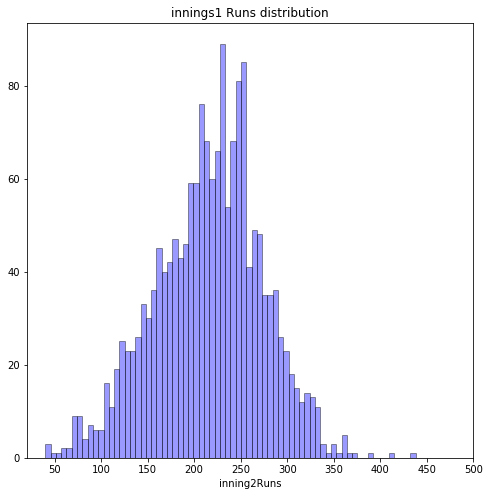

In [111]:
fig= plt.figure(figsize=(8, 8))  
ax=sns.distplot(inning1FeatureVectorComplete['inning2Runs'], hist=True, kde=False, 
         bins=70, color = 'blue',
         hist_kws={'edgecolor':'black'})
ax.set_xticks([50,100,150,200,250,300,350,400,450,500])
ax.set_title("innings1 Runs distribution")
plt.savefig('C:/python/Scripts/JupyterNotebooks/matchInProgress/InningsOverRecordsBeforeOverBowled/EDA/inning2Runs_withOutPreprocessing.png')

In [285]:
pdf = PdfPages((str(matchinProgressDataFolderResult)+"inningsRunsEDA_charts.pdf"))
stdev1 = inning1FeatureVectorComplete['inning1Runs'].std()
stdev2 = inning1FeatureVectorComplete['inning2Runs'].std()
mean1 = inning1FeatureVectorComplete['inning1Runs'].mean()
mean2 = inning1FeatureVectorComplete['inning2Runs'].mean()

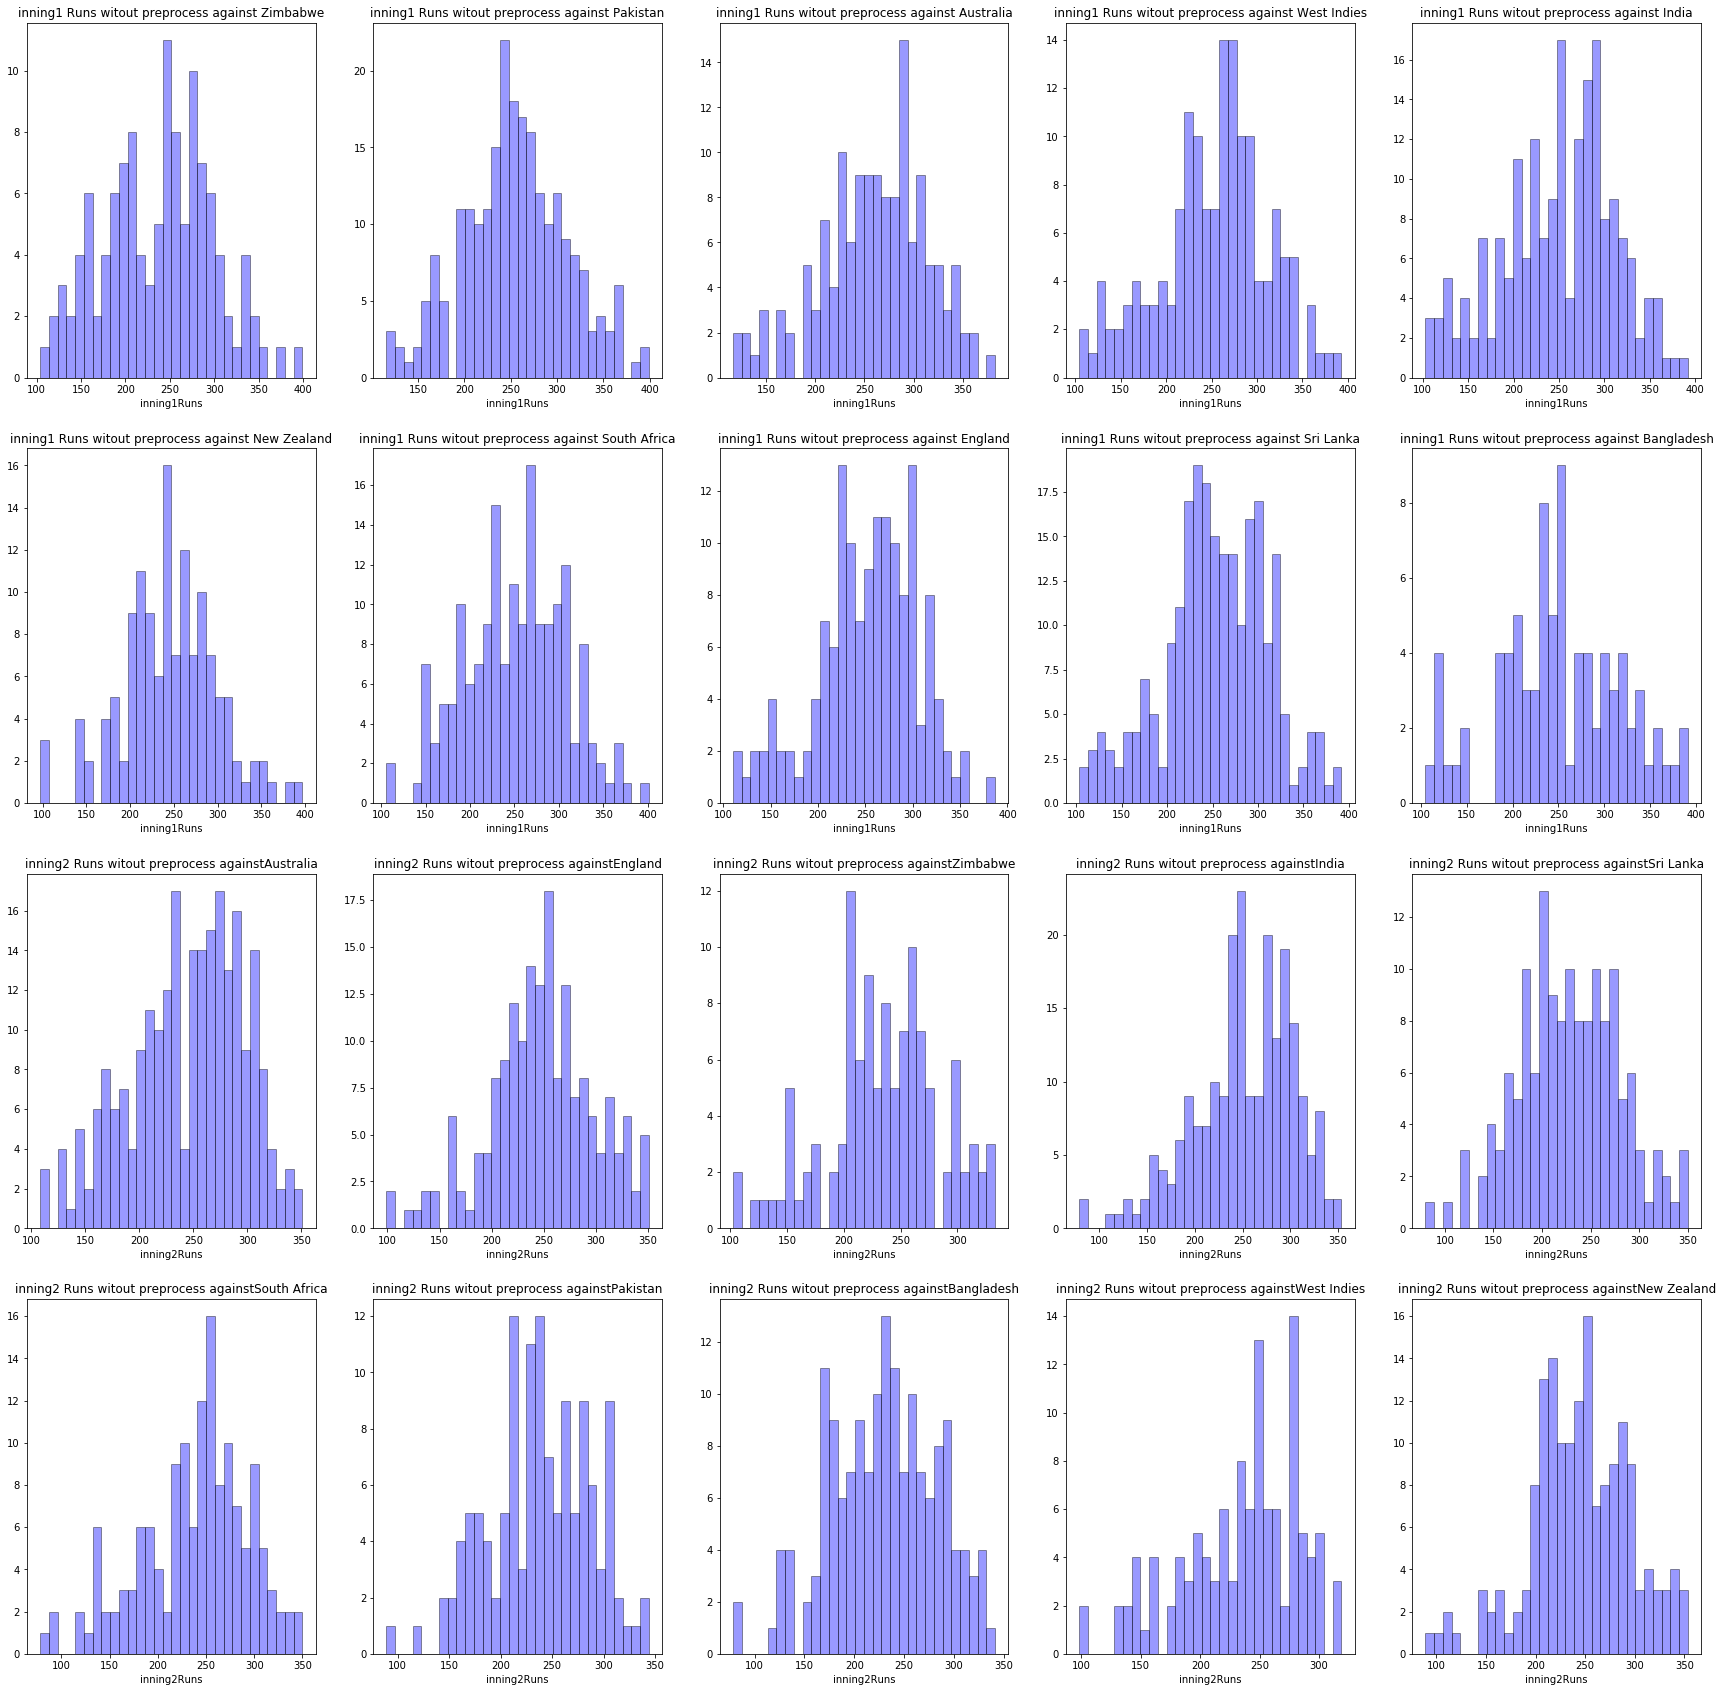

In [411]:
pdf1 = PdfPages((str(matchinProgressDataFolderResult)+"innings1_2RunsEDA_charts_OppositionWise.pdf"))


# inning1FeatureVectorCompleteJitter= inning1FeatureVectorComplete.copy()
# for i in range(len(inning1FeatureVectorComplete)):
#     inning1FeatureVectorCompleteJitter['inning1Runs'].loc[i] = abs(inning1FeatureVectorCompleteJitter['inning1Runs'].iloc[i] + random.uniform(-30,20))

fig, axs = plt.subplots(4, 5, figsize=(30, 30))    

# axs[0,0].scatter(inning1FeatureVectorCompleteJitter['inning1Runs'],inning1FeatureVectorCompleteJitter['inning2Runs'],s=8, c=np.sqrt(inning1FeatureVectorComplete['inning1Runs']))#, bins=20, rwidth=0.9)
# axs[0,0].set_title("inng1 & inng2 Runs with jitter,color=inng1Runs") 
# axs[0,0].set_xlabel("inning1Runs")
# axs[0,0].set_ylabel("inning2Runs")


# axs[0,1].scatter(inning1FeatureVectorCompleteJitter['inning1Runs'],inning1FeatureVectorCompleteJitter['inning2Runs'],s=8, c=(inning1FeatureVectorComplete['year']), label=inning1FeatureVectorComplete['year'].unique())#, bins=20, rwidth=0.9)
# axs[0,1].set_title("inng1 & inng2 Runs with jitter,color=year") 
# axs[0,1].set_xlabel("inning1Runs")
# axs[0,1].set_ylabel("inning2Runs")



# sns.distplot(inning1FeatureVectorComplete['inning1Runs'], hist=True, kde=False, 
#              bins=30, color = 'blue',
#              hist_kws={'edgecolor':'black'}, ax = axs[0,2])
# axs[0,2].set_title("inning1 Runs Intial witout preprocess") 


# sns.distplot(inning1FeatureVectorComplete['inning2Runs'], hist=True, kde=False, 
#              bins=30, color = 'blue',
#              hist_kws={'edgecolor':'black'}, ax= axs[0,3])
# axs[0,3].set_title("inning2 Runs Intial witout preprocess") 

k=-1
j=0
for team in inning1FeatureVectorComplete['team2'].unique():
    k=k+1
    if(k==5):
        k=0
        j=j+1
    sns.distplot(inning1FeatureVectorComplete[inning1FeatureVectorComplete['team2']==team]['inning1Runs'], hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax= axs[j,k])
    axs[j,k].set_title("inning1 Runs witout preprocess against "+str(team)) 

    
for team in inning1FeatureVectorComplete['team1'].unique():
    k=k+1
    if(k==5):
        k=0
        j=j+1
    sns.distplot(inning1FeatureVectorComplete[inning1FeatureVectorComplete['team1']==team]['inning2Runs'], hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax= axs[j,k])
    axs[j,k].set_title("inning2 Runs witout preprocess against"+str(team)) 

    
pdf1.savefig(fig)
pdf1.close()    

In [ ]:
stdev1 = int(inningFeatureVectorOver1['inning1Runs'].std())
stdev2 = int(inningFeatureVectorOver1['inning2Runs'].std())
mean1 = int(inningFeatureVectorOver1['inning1Runs'].mean())
mean2 = int(inningFeatureVectorOver1['inning2Runs'].mean())



inningFeatureVectorOverIn = inningFeatureVectorOver1[(inningFeatureVectorOver1['inning1Runs']>mean1 -(stdTick*stdev1)) & (inningFeatureVectorOver1['inning1Runs']<mean1+(stdTick*stdev1))].copy()
inning1FeatureVectorCompleteNew = inningFeatureVectorOverIn[(inningFeatureVectorOverIn['inning2Runs']>mean2 -(stdTick*stdev2)) & (inningFeatureVectorOverIn['inning2Runs']<mean2+(stdTick*stdev2))].copy()



TypeError: can't convert complex to int

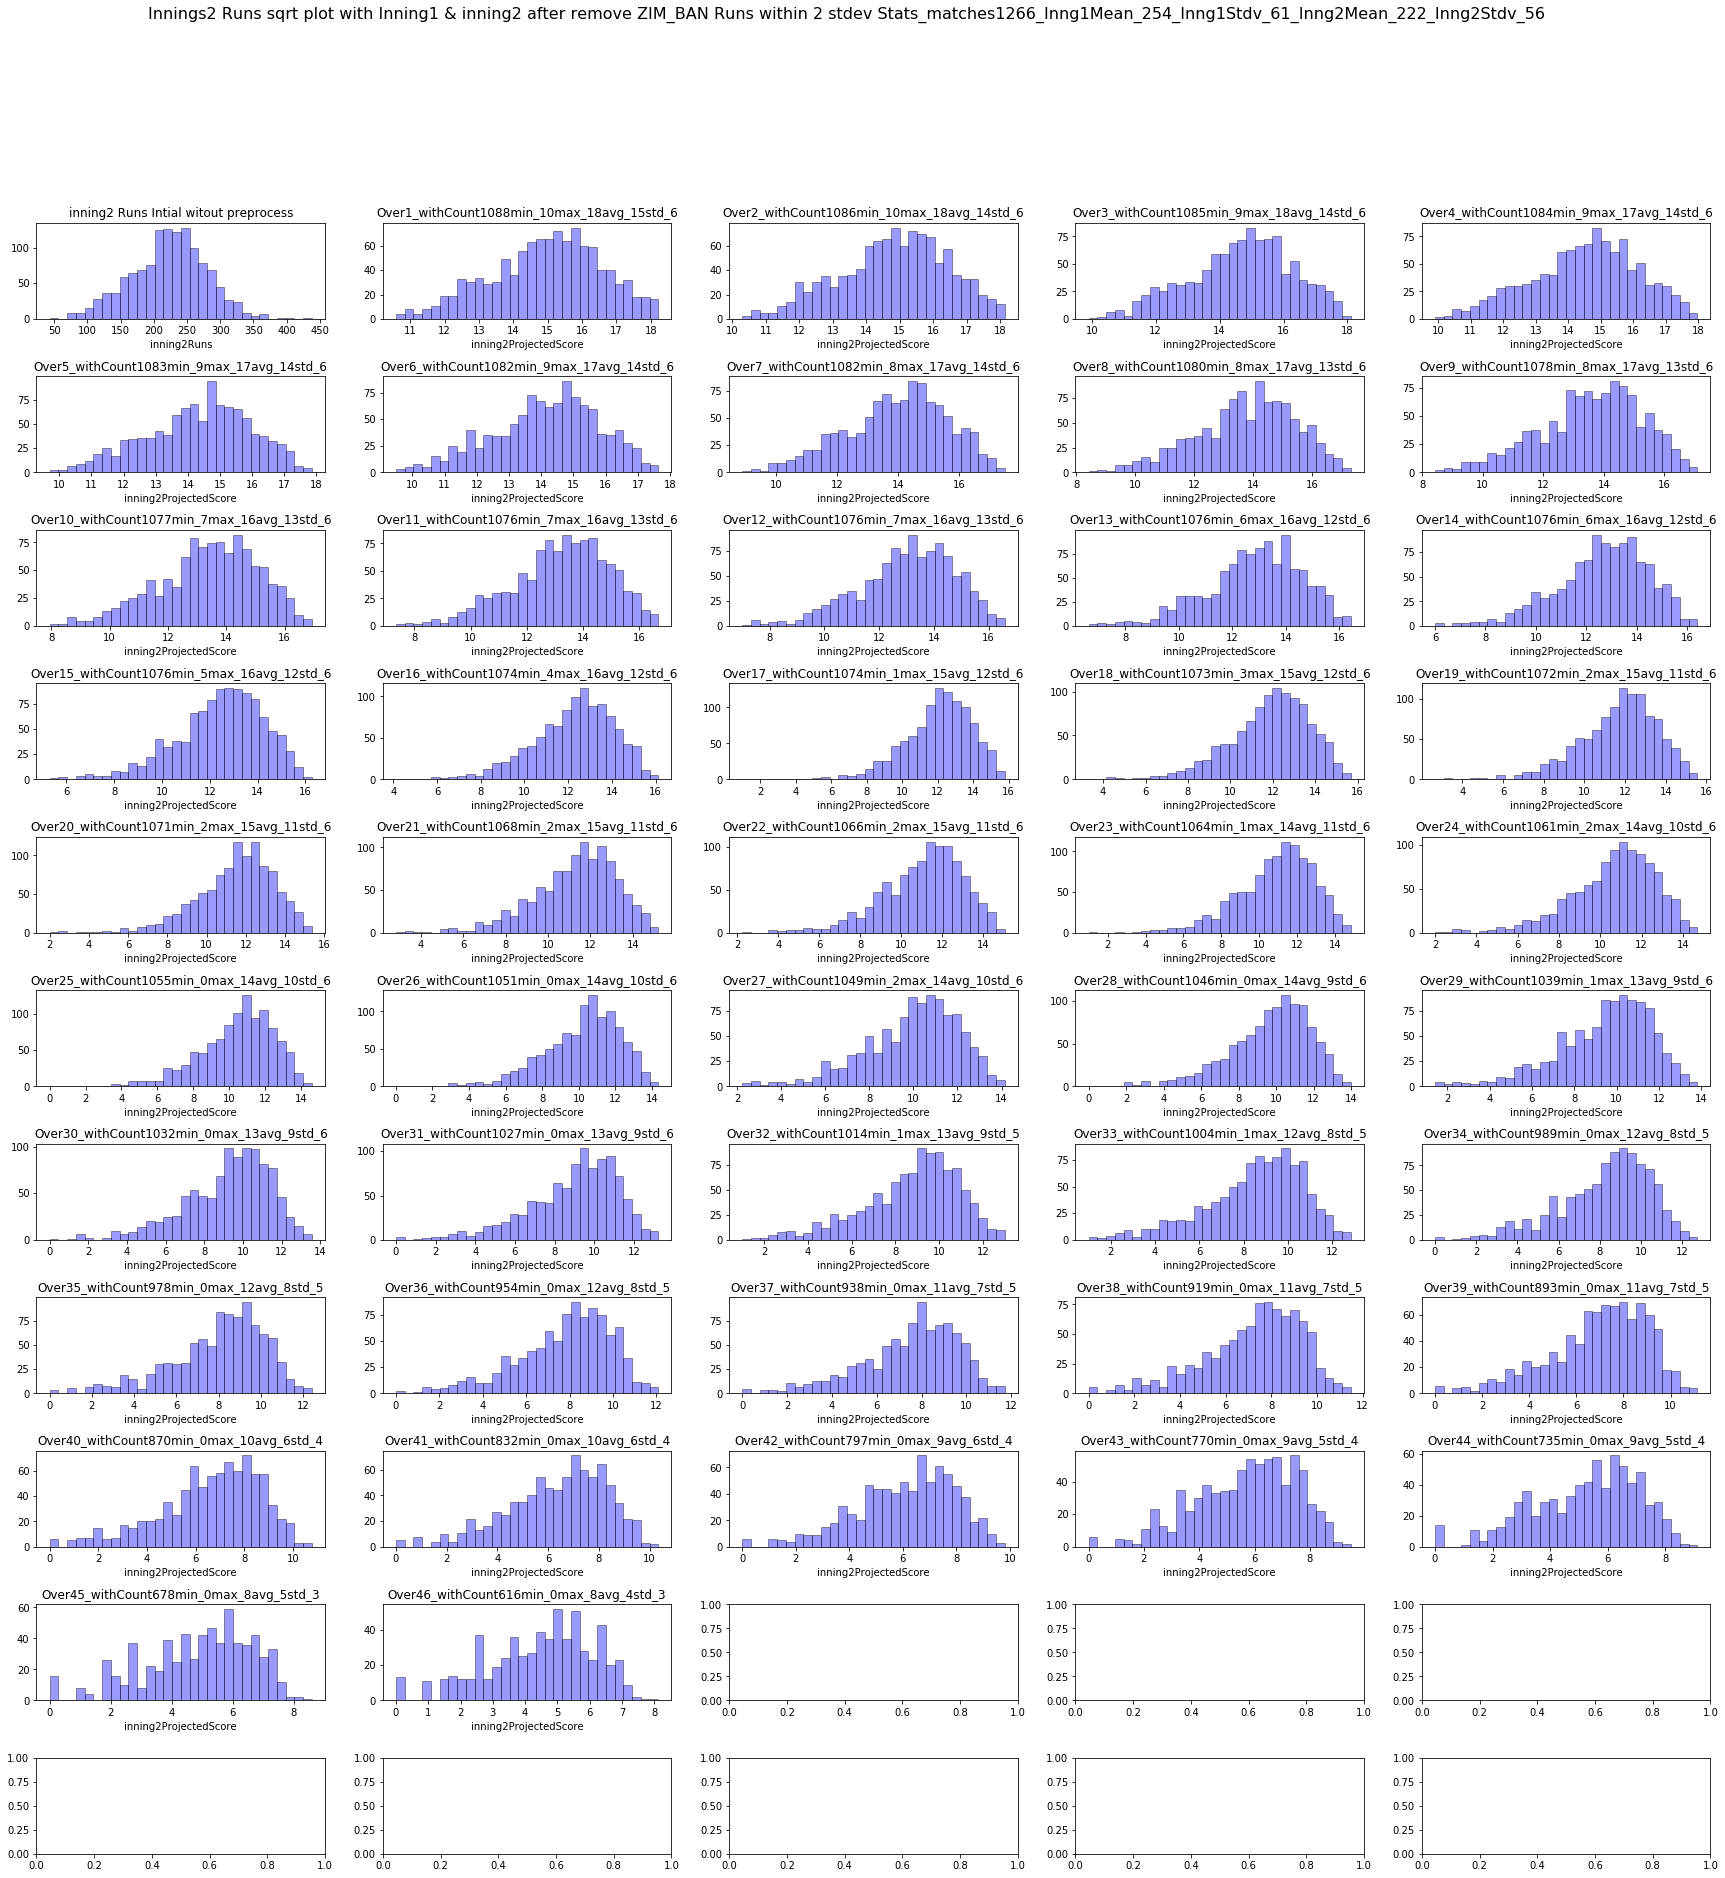

In [260]:
inngs=2
stdTick=2

pdf1 = PdfPages(("C:/python/Scripts/JupyterNotebooks/matchInProgress/InningsOverRecordsBeforeOverBowled/EDA/innings"+str(inngs)+"_EDA_charts_Std_on_"+str(stdTick)+"_withSquareRoot.pdf"))




inningStartFeatureVector = pd.read_csv(str(matchinProgressDataFolder)+'innings1/inprogress_Inng1_over0Records_2001_19.csv')


inning1FeatureVectorCompleteTemp = inningStartFeatureVector[(inningStartFeatureVector['team1']!='Zimbabwe') & (inningStartFeatureVector['team2']!='Zimbabwe') & (inningStartFeatureVector['team1']!='Bangladesh') & (inningStartFeatureVector['team2']!='Bangladesh')] 



stdev1 = int(inning1FeatureVectorCompleteTemp['inning1Runs'].std())
stdev2 = int(inning1FeatureVectorCompleteTemp['inning2Runs'].std())
mean1 = int(inning1FeatureVectorCompleteTemp['inning1Runs'].mean())
mean2 = int(inning1FeatureVectorCompleteTemp['inning2Runs'].mean())

fig, axs = plt.subplots(11, 5, figsize=(30, 30))    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.6)

fig.suptitle("Innings"+str(inngs)+" Runs sqrt plot with Inning1 & inning2 after remove ZIM_BAN Runs within "+str(stdTick)+" stdev Stats_matches"+str(len(inning1FeatureVectorCompleteTemp))+"_Inng1Mean_"+str(mean1)+"_Inng1Stdv_"+str(stdev1)+"_Inng2Mean_"+str(mean2)+"_Inng2Stdv_"+str(stdev2), fontsize=16)


sns.distplot(inning1FeatureVectorCompleteTemp['inning'+str(inngs)+'Runs'], hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = axs[0,0])
axs[0,0].set_title("inning"+str(inngs)+" Runs Intial witout preprocess") 


# sns.distplot(inning1FeatureVectorCompleteTemp['inning2Runs'], hist=True, kde=False, 
#              bins=30, color = 'red',
#              hist_kws={'edgecolor':'black'}, ax= axs[0,1])
# axs[0,1].set_title("inning2 Runs Intial witout preprocess") 







#stdTick = round(stdTick+0.1,2)
#print(stdTick)





inning1FeatureVectorCompleteIn = inning1FeatureVectorCompleteTemp[(inning1FeatureVectorCompleteTemp['inning1Runs']>mean1 -(stdTick*stdev1)) & (inning1FeatureVectorCompleteTemp['inning1Runs']<mean1+(stdTick*stdev1))]
inning1FeatureVectorComplete1 = inning1FeatureVectorCompleteIn[(inning1FeatureVectorCompleteIn['inning2Runs']>mean2 -(stdTick*stdev2)) & (inning1FeatureVectorCompleteIn['inning2Runs']<mean2+(stdTick*stdev2))]
matchIds  = inning1FeatureVectorComplete1['matchId'].unique()

afterLen  = len(inning1FeatureVectorComplete1)
minRuns1  =  int(inning1FeatureVectorComplete1['inning1Runs'].min())
maxRuns1  =  int(inning1FeatureVectorComplete1['inning1Runs'].max())
stdRuns1  =  int(inning1FeatureVectorComplete1['inning1Runs'].std())  
avgRuns1  =  int(inning1FeatureVectorComplete1['inning1Runs'].mean())


afterLen  = len(inning1FeatureVectorComplete1)
minRuns2  =  int(inning1FeatureVectorComplete1['inning2Runs'].min())
maxRuns2  =  int(inning1FeatureVectorComplete1['inning2Runs'].max())
stdRuns2  =  int(inning1FeatureVectorComplete1['inning2Runs'].std())  
avgRuns2  =  int(inning1FeatureVectorComplete1['inning2Runs'].mean())

#print(matchIds)

inning1FeatureVectorComplete = pd.read_csv(str(matchinProgressDataFolder)+'inprogressOfInning'+str(inngs)+'_over1_50Records_withAllEncodedFeatures_Combined.csv')    
  
k=0
j=0

for currOvr in range(1,51):
    inning1FeatureVectorComplete1 = inning1FeatureVectorComplete[inning1FeatureVectorComplete['matchId'].isin(matchIds)]
    #inning1FeatureVectorComplete1 =  inning1FeatureVectorComplete[inning1FeatureVectorComplete['matchId'] in matchhIds]
    inning1FeatureVectorComplete1  = inning1FeatureVectorComplete1[inning1FeatureVectorComplete1['overId']==currOvr]
    #print(len(inning1FeatureVectorComplete1))
    
    afterLen  = len(inning1FeatureVectorComplete1)
    minRuns1  =  int(inning1FeatureVectorComplete1['inning'+str(inngs)+'ProjectedScore'].min()**0.5)
    maxRuns1  =  int(inning1FeatureVectorComplete1['inning'+str(inngs)+'ProjectedScore'].max()**0.5)
    stdRuns1  =  int(inning1FeatureVectorComplete1['inning'+str(inngs)+'ProjectedScore'].std()**0.5)
    avgRuns1  =  int(inning1FeatureVectorComplete1['inning'+str(inngs)+'ProjectedScore'].mean()**0.5)

    #     print('After', len(inning1FeatureVectorComplete1))
#     print('min', inning1FeatureVectorComplete1['inning1Runs'].min())
#     print('max', inning1FeatureVectorComplete1['inning1Runs'].max())
#     print('std', inning1FeatureVectorComplete1['inning1Runs'].std())
#     print('Avg', inning1FeatureVectorComplete1['inning1Runs'].mean())  

    k=k+1
    if(k==5):
        k=0
        j=j+1
    sns.distplot(inning1FeatureVectorComplete1['inning'+str(inngs)+'ProjectedScore']**0.5, hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax= axs[j,k])
    #axs[j,k].set_title("innings Runs for Over"+ str(currOvr))
    axs[j,k].set_title("Over"+ str(currOvr)+"_withCount"+str(afterLen)+"min_"+str(minRuns1)+"max_"+str(maxRuns1)+"avg_"+str(avgRuns1)+"std_"+str(stdRuns1)) 
    #print('j,k', j,k)
pdf1.savefig(fig)


#     k=k+1
#     if(k==3):
#         k=0
#         j=j+1
#     sns.distplot(inning1FeatureVectorComplete1['inning2RunsExpected'], hist=True, kde=False, 
#              bins=30, color = 'red',
#              hist_kws={'edgecolor':'black'}, ax= axs[j,k])
#     axs[j,k].set_title("inning2RunsExpected Lies in "+str(stdTick)+" std _matchCount"+str(afterLen)+"min_"+str(minRuns2)+"max_"+str(maxRuns2)+"avg_"+str(avgRuns2)+"std_"+str(stdRuns2)) 
#     #axs[j,k].set_xticks([100,150,200,250,300,350,400])

pdf1.close()
    

In [588]:



inning1FeatureVectorCompleteNew = pd.read_csv(str(inning1BeforeStartProjectionFolder)+'startOfInnings_Inng2_Records_playerClustCount.csv')
#inning1FeatureVectorCompleteNew = inning1FeatureVectorCompleteTemp.copy()
inning1FeatureVectorCompleteNew = inning1FeatureVectorCompleteNew.fillna(0)



inning1FeatureVectorCompleteNew.team1.unique()

array(['Pakistan', 'England', 'West Indies', 'Zimbabwe', 'Sri Lanka',
       'New Zealand', 'India', 'South Africa', 'Bangladesh', 'Australia'],
      dtype=object)

In [592]:
inning1FeatureVectorCompleteTemp = inning1FeatureVectorCompleteNew[(inning1FeatureVectorCompleteNew['team1']!='Zimbabwe') & (inning1FeatureVectorCompleteNew['team2']!='Zimbabwe') & (inning1FeatureVectorCompleteNew['team1']!='Bangladesh') & (inning1FeatureVectorCompleteNew['team2']!='Bangladesh')] 

print(len(inning1FeatureVectorCompleteTemp))
print(inning1FeatureVectorCompleteTemp.team1.unique())
print(inning1FeatureVectorCompleteTemp.team2.unique())

1266
['Pakistan' 'England' 'West Indies' 'Sri Lanka' 'New Zealand' 'India'
 'South Africa' 'Australia']
['England' 'Australia' 'Pakistan' 'India' 'New Zealand' 'Sri Lanka'
 'South Africa' 'West Indies']


In [597]:
#print("Globel mean,", round(inning1FeatureVectorCompleteTemp['inning2Runs'].mean(),2))
print("Globel std,", round(inning1FeatureVectorCompleteTemp['inning2Runs'].std(),2))
for team in inning1FeatureVectorCompleteTemp.team2.unique():
    #print(team,',',round(inning1FeatureVectorCompleteTemp[inning1FeatureVectorCompleteTemp['team2']==team]['inning2Runs'].mean(),2))
    print(team,',',round(inning1FeatureVectorCompleteTemp[inning1FeatureVectorCompleteTemp['team2']==team]['inning2Runs'].std(),2))
    

Globel std, 56.55
England , 56.38
Australia , 54.08
Pakistan , 53.39
India , 54.3
New Zealand , 61.23
Sri Lanka , 59.6
South Africa , 52.75
West Indies , 59.9


In [587]:
print("Globel mean,", round(inning1FeatureVectorCompleteTemp['inning2Runs'].mean(),2))
print("Globel std,", round(inning1FeatureVectorCompleteTemp['inning2Runs'].std(),2))
for team in inning1FeatureVectorCompleteTemp.team2.unique():
    print(team,',',round(inning1FeatureVectorCompleteTemp[inning1FeatureVectorCompleteTemp['team2']==team]['inning2Runs'].mean(),2))
    print(team,',',round(inning1FeatureVectorCompleteTemp[inning1FeatureVectorCompleteTemp['team2']==team]['inning2Runs'].std(),2))
    

Globel mean, 223.17
Globel std, 53.09
England , 223.19
England , 50.73
Australia , 230.22
Australia , 51.98
Pakistan , 221.76
Pakistan , 51.27
India , 231.14
India , 53.81
New Zealand , 210.48
New Zealand , 58.7
Sri Lanka , 226.22
Sri Lanka , 51.87
South Africa , 219.04
South Africa , 48.45
West Indies , 218.06
West Indies , 56.27


In [823]:
##############   Z-score   outlier detection  


from scipy import stats
import numpy as np
z = np.abs(stats.zscore(inning1FeatureVectorComplete['inning2Runs'])) #['inning1Runs']
print(z)
print(np.where(z>2.5))

inning1FeatureVectorComplete['zScore'] =z
print('Max Z Score', inning1FeatureVectorComplete['zScore'].max())
print('max',inning1FeatureVectorComplete[inning1FeatureVectorComplete['zScore']<1.5]['inning2Runs'].max())
print('min',inning1FeatureVectorComplete[inning1FeatureVectorComplete['zScore']<1.5]['inning2Runs'].min())
print('std',inning1FeatureVectorComplete[inning1FeatureVectorComplete['zScore']<1.5]['inning2Runs'].std())


# inning1FeatureVector_trainTest['zScore'] =z
# inning1FeatureVector_trainTest[inning1FeatureVector_trainTest['zScore']>2.5]


In [59]:
#############    IQR outlier detection ####################
Q1 = inning1FeatureVectorComplete['inning1Runs'].quantile(0.25)
Q3 = inning1FeatureVectorComplete['inning1Runs'].quantile(0.75)
IQR = Q3 - Q1
print(Q1,Q3,IQR)

tick= IQR
print('max',inning1FeatureVectorComplete[~((inning1FeatureVectorComplete['inning1Runs']) < (Q1 - tick * IQR)) | ((inning1FeatureVectorComplete['inning1Runs']) > (Q3 + tick * IQR))]['inning1Runs'].max())

print('min',inning1FeatureVectorComplete[~((inning1FeatureVectorComplete['inning1Runs']) < (Q1 - tick * IQR)) | ((inning1FeatureVectorComplete['inning1Runs']) > (Q3 + tick * IQR))]['inning1Runs'].min())
print('std',inning1FeatureVectorComplete[~((inning1FeatureVectorComplete['inning1Runs']) < (Q1 - tick * IQR)) | ((inning1FeatureVectorComplete['inning1Runs']) > (Q3 + tick * IQR))]['inning1Runs'].std())



220.0 294.0 74.0
max 481
min 35
std 58.704286771389


In [936]:
inning1FeatureVectorComplete.columns

Index(['matchId', 'year', 'venueCountry', 'team1', 'team2', 'homeTeam',
       'toss_winner_team', 'inning1Runs', 'inning1RunRate', 'innings1Wickets',
       'inning2Runs', 'inning2RunRate', 'inning2RunsExpected',
       'innings2Wickets', 'team2Cluster', 'team1Cluster', 'Continent',
       'tossWinner', 'venueCountryCode', 'yearId', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_0', 'batsmenOfClust_1',
       'batsmenOfClust_4', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_0', 'bowlerOfClust_1', 'bowlerOfClust_4',
       'onCreasebatsman1', 'bats1CurrOvrRuns', 'bats1CurrOvrBalls',
       'bats1TotalRuns', 'bats1TotalBalls', 'onCreasebatsman2',
       'bats2CurrOvrRuns', 'bats2CurrOvrBalls', 'bats2TotalRuns',
       'bats2TotalBalls', 'totalRunsScoredCurrentOvr',
       'totalRunsScoredtillNow', 'onCreasebowlerOfTheOvr', 'overId', 'wicket',
       'wicket.1', 'wicket.2', 'wicket.3', 'wicket.4', 'wicket.5',
       'totalRunsScoredBeforeThisOvr', 'bats1Tota

In [791]:
# ########     KNN 
fileWriteOutput =  open(str(matchinProgressDataFolderResult)+"inprogressOfInning1_50oversPrediction_KNN.csv",'w')
fileWriteOutput.write('overId,kFold, dataConstraint,K_neighbors,targetVariable,MAE, RMSE \n')
fileWriteOutput.close()

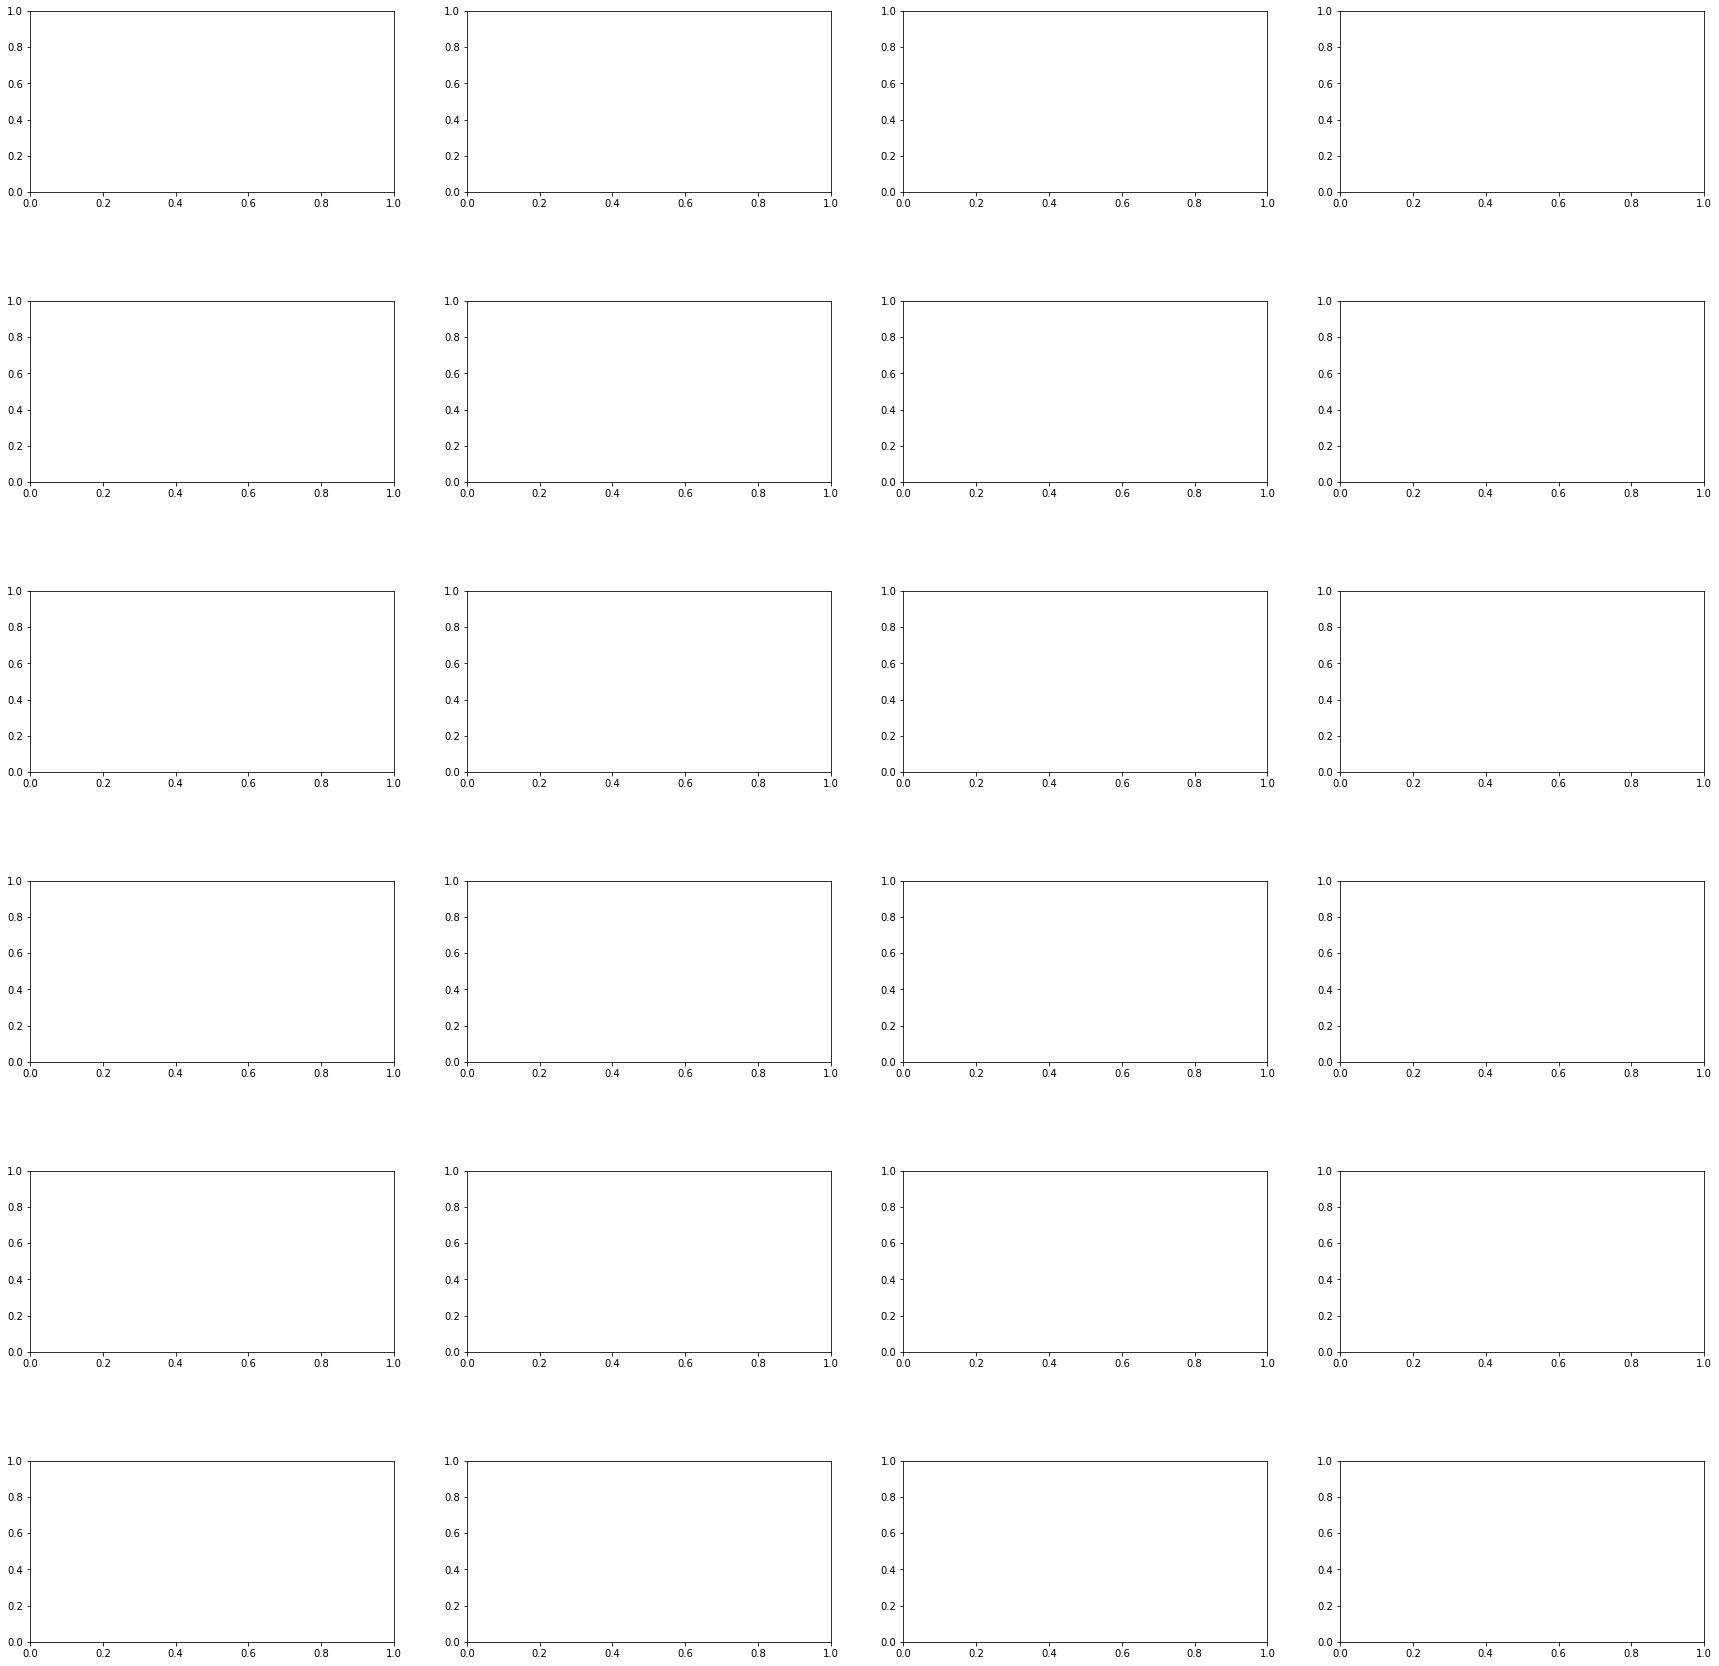

In [762]:
pdf = PdfPages((str(matchinProgressDataFolderResult)+"inprogressOfInning"+str(inngs)+"_LR_dataConstraintVar_"+str(constraintvar)+"__targetVar_"+str(targetVar)+"_randomMatch2.pdf"))#MAE%age


fig, axs = plt.subplots(6, 4, figsize=(30, 30))    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.6)


In [49]:

#######################     columns selection #######################


columnsRemoveInng1=['matchId', 'year','team1', 'team2', 'venueCountry','homeTeam',
       'toss_winner_team', 'inning1Runs', 'inning1RunRate', 'innings1Wickets',
       'inning2Runs', 'inning2RunRate', 'inning2RunsExpected',
       'innings2Wickets', 'team2Cluster', 'team1Cluster', 'Continent','tossWinner','yearId'
       'tossWinner', 'yearId', 'bats1CurrOvrRuns', 'bats1CurrOvrBalls',
       'bats1TotalRuns', 'bats1TotalBalls', 
       'bats2CurrOvrRuns', 'bats2CurrOvrBalls', 'bats2TotalRuns',
       'bats2TotalBalls',
       'totalRunsScoredtillNow','bats1TotalBallsBeforeThisOvr','bats1TotalRunsBeforeThisOvr','bats2TotalBallsBeforeThisOvr','bats2TotalRunsBeforeThisOvr','totalRunsScoredCurrentOvr', 'inning1ProjectedScore'
                  , 'wicket',
       'wicket.1', 'wicket.2', 'wicket.3', 'wicket.4', 'wicket.5' ,'teamOpp','inning2ProjectedScoreSq',
                    'overId','venueCountryCode',
                    'totalRunsScoredBeforeThisOvr','onCreasebowlerOfTheOvr','onCreasebatsman1','onCreasebatsman2'
                    
     
                   ] #'onCreasebowlerOfTheOvr','overId', 'venueCountryCode',  'onCreasebatsman1', 'onCreasebatsman2',  , 'totalRunsScoredBeforeThisOvr'



columnsRemoveInng2=['matchId', 'year','team1', 'team2', 'venueCountry','homeTeam',
       'toss_winner_team', 
       'inning2Runs', 'inning2RunRate', 'inning2RunsExpected',
       'innings2Wickets', 'team2Cluster', 'team1Cluster', 'Continent','tossWinner','yearId'
       'tossWinner', 'yearId', 'bats1CurrOvrRuns', 'bats1CurrOvrBalls',
       'bats1TotalRuns', 'bats1TotalBalls', 
       'bats2CurrOvrRuns', 'bats2CurrOvrBalls', 'bats2TotalRuns',
       'bats2TotalBalls',
       'totalRunsScoredtillNow','bats1TotalBallsBeforeThisOvr','bats1TotalRunsBeforeThisOvr',
     'bats2TotalBallsBeforeThisOvr','bats2TotalRunsBeforeThisOvr','totalRunsScoredCurrentOvr', 'inning2ProjectedScore'
         , 'wicket','wicket.1', 'wicket.2', 'wicket.3', 'wicket.4', 'wicket.5' ,'teamOpp','inning2ProjectedScoreSq',
                    'overId','venueCountryCode',
                         
                    'totalRunsScoredBeforeThisOvr','onCreasebowlerOfTheOvr','onCreasebatsman1','onCreasebatsman2'
     
                   ] #'onCreasebowlerOfTheOvr', 'inning1RunRate', ,  'onCreasebatsman1', 'onCreasebatsman2',  , 'totalRunsScoredBeforeThisOvr'






########################### columns selection end here ##################





import random
matchinProgressDataFolder = 'C:/python/Scripts/JupyterNotebooks/matchInProgress/InningsOverRecordsBeforeOverBowled/'
#matchinProgressDataFolder = str(matchinProgressDataFolder)+'innings2/'


#### concatenate all over records ###########

def CombinedInningsOvers(inngs):
    inningsInProgressOversCombined =pd.DataFrame()
    for inningsOver in range(1,51):
        df2 =  pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over'+str(inningsOver)+'Records_withAllEncodedFeatures.csv')  
        inningsInProgressOversCombined  =pd.concat([inningsInProgressOversCombined, df2], sort=True)

    inningsInProgressOversCombined.to_csv(str(matchinProgressDataFolder)+'inprogressOfInning'+str(inngs)+'_over1_50Records_withAllEncodedFeatures_Combined.csv',index=False, header=True)          
    
    return inningsInProgressOversCombined





#########    parameters settings     ################

kfolds= 10
stdTick=2
upperLimitRuns = 400
lowerLimitRuns = 165
constraintvar  ='inning1Runs'
inngs=2


k_neighbors=50

targetVar =  'inning2ProjectedScore'   #  'inning1ProjectedScore'   #    'totalRunsScoredCurrentOvr' #   'inning1Runs'  #    'inning2RunsExpected' #       

dataConstraint = 'g'+str(lowerLimitRuns)+'_l'+str(upperLimitRuns)

matchinProgressDataFolderResult = str(matchinProgressDataFolder)+'innings'+str(inngs)+'/Results/'

#overSplit=False


oversData=[]
MAE_Records=[]
MAE_allOvers=[]
predData=[]

######### Parameter settings end here     ############



##########     Results output file writing starts here                   ##############

fileNameOut = str(matchinProgressDataFolderResult)+"inprogressOfInning"+str(inngs)+"_50oversPrediction_LR_dataConstraintVar_"+str(constraintvar)+"_LR_data"+str(dataConstraint)+".csv"

# fileWriteOutput =  open(fileNameOut, "w") #str(matchinProgressDataFolderResult)+"inprogressOfInning1_50oversPrediction_LR"+str(dataConstraint)+".csv",'w')
# fileWriteOutput.write('overId,kFold, dataConstraint,targetVariable,MAE, RMSE \n')
# fileWriteOutput.close() 
#########   Output file header writing ends here        ##############


#inningsOver= 1






inningStartFeatureVector = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over1Records_playerClustCount.csv')


print('Before', len(inningStartFeatureVector))
print('min', inningStartFeatureVector['inning1Runs'].min())
print('max', inningStartFeatureVector['inning1Runs'].max())
print('std', inningStartFeatureVector['inning1Runs'].std())
print('Avg', inningStartFeatureVector['inning1Runs'].mean())  




inningFeatureVectorOver1 = inningStartFeatureVector[(inningStartFeatureVector['team1']!='Zimbabwe') & (inningStartFeatureVector['team2']!='Zimbabwe') & (inningStartFeatureVector['team1']!='Bangladesh') & (inningStartFeatureVector['team2']!='Bangladesh')] 


stdev1 = int(inningFeatureVectorOver1['inning1Runs'].std())
stdev2 = int(inningFeatureVectorOver1['inning2Runs'].std())
mean1 = int(inningFeatureVectorOver1['inning1Runs'].mean())
mean2 = int(inningFeatureVectorOver1['inning2Runs'].mean())



inningFeatureVectorOverIn = inningFeatureVectorOver1[(inningFeatureVectorOver1['inning1Runs']>mean1 -(stdTick*stdev1)) & (inningFeatureVectorOver1['inning1Runs']<mean1+(stdTick*stdev1))].copy()
inning1FeatureVectorCompleteNew = inningFeatureVectorOverIn[(inningFeatureVectorOverIn['inning2Runs']>mean2 -(stdTick*stdev2)) & (inningFeatureVectorOverIn['inning2Runs']<mean2+(stdTick*stdev2))].copy()



print('Before', len(inning1FeatureVectorCompleteNew))
print('min', inning1FeatureVectorCompleteNew['inning1Runs'].min())
print('max', inning1FeatureVectorCompleteNew['inning1Runs'].max())
print('std', inning1FeatureVectorCompleteNew['inning1Runs'].std())
print('Avg', inning1FeatureVectorCompleteNew['inning1Runs'].mean())  




matchIdsSelectData = inning1FeatureVectorCompleteNew['matchId'].unique()
# for i in range(len(matchIdsSelectData)):
#     print(matchIdsSelectData[i])
print(len(matchIdsSelectData))


MAEDataForallOvers=[]
absErrorMeanForallOvers=[]
absErrorDevForallOvers=[]
absErrorPercentForallOvers=[]
def predictRunsForMatch(currMatchId,inningsId,overSplit):
    j=0
    k=-1
    notFound=1
    
    targetVar =  'inning'+str(inningsId)+'ProjectedScore'  
    
    for i in range(1):
        k=k+1
        inngs = inningsId

        
        randomNum = random.randint(0,len(matchIdsSelectData))
        notFound=1
        
        currMatch = 932853 #currMatchId #matchIdsSelectData[randomNum]   # # # 66276 #902647 #   
       
        if overSplit==True and (currMatchId not in matchIdsSelectData):
            print('Match Id not found in filtered Matches')
            notFound=0
            #return notFound,0
            #break
        elif overSplit==True and (currMatchId in matchIdsSelectData):
            overSplit=True
            inningsInProgressOversCombined = CombinedInningsOvers(inngs)
            predData=[]
        if(1==1):
            inningsInProgressOversCombined = CombinedInningsOvers(inngs)
            print('match length', len(inningsInProgressOversCombined[inningsInProgressOversCombined['matchId']==currMatch])+1)
            if(overSplit==True):
                matchRange = len(inningsInProgressOversCombined[inningsInProgressOversCombined['matchId']==currMatch])+1
            elif(overSplit==False): 
                matchRange = 51
                
            for inningsOver in range(1,matchRange):
                #oversData.append(inningsOver)
                print('overProcessing', inningsOver)
                predOver = inningsOver
                #inningsInProgressOversCombined #
                inningsInProgressOversCombined = CombinedInningsOvers(inngs)

                inningsInProgressOversCombined['inning2ProjectedScoreSq'] =0 
                
                #inningsInProgressOversCombined['inning2ProjectedScoreSq'] = inningsInProgressOversCombined['inning2ProjectedScore']
                
                #inningsInProgressOversCombined['inning2ProjectedScoreSq'] = inningsInProgressOversCombined['inning2ProjectedScoreSq']**0.5
                runsConvert =1 #2
                inning1FeatureVectorComplete = inningsInProgressOversCombined[inningsInProgressOversCombined['overId']==inningsOver].copy() # pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/inprogressOfInning'+str(inngs)+'_over'+str(inningsOver)+'Records_withAllEncodedFeatures.csv')  


                inning1FeatureVectorCompleteNew = inning1FeatureVectorComplete[(inning1FeatureVectorComplete['team1']!='Zimbabwe') & (inning1FeatureVectorComplete['team2']!='Zimbabwe') & (inning1FeatureVectorComplete['team1']!='Bangladesh') & (inning1FeatureVectorComplete['team2']!='Bangladesh')] 


                inning1FeatureVectorCompleteIn = inning1FeatureVectorCompleteNew[(inning1FeatureVectorCompleteNew['inning1Runs']>mean1 -(stdTick*stdev1)) & (inning1FeatureVectorCompleteNew['inning1Runs']<mean1+(stdTick*stdev1))].copy()
                inning1FeatureVectorComplete = inning1FeatureVectorCompleteIn[(inning1FeatureVectorCompleteIn['inning2Runs']>mean2 -(stdTick*stdev2)) & (inning1FeatureVectorCompleteIn['inning2Runs']<mean2+(stdTick*stdev2))].copy()

                print("lentgh fo this opver", len(inning1FeatureVectorComplete))
               # inning1FeatureVectorComplete['teamOpp']= inning1FeatureVectorComplete['team1'].astype(str) +" "+inning1FeatureVectorComplete['team2']
                
                #print(inning1FeatureVectorComplete.columns)
                
                
#                 labels = inning1FeatureVectorComplete['teamOpp'].astype('category').cat.categories.tolist()
#                 replace_continent_comp = {'teamOpp' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
#                 inning1FeatureVectorComplete .replace(replace_continent_comp, inplace=True)
#                 

                labels = inning1FeatureVectorComplete['team1'].astype('category').cat.categories.tolist()
                replace_continent_comp = {'team1' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
                inning1FeatureVectorComplete .replace(replace_continent_comp, inplace=True)
#                 
                
                
                labels = inning1FeatureVectorComplete['team2'].astype('category').cat.categories.tolist()
                replace_continent_comp = {'team2' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
                inning1FeatureVectorComplete .replace(replace_continent_comp, inplace=True)
                
                
                #print(inning1FeatureVectorComplete['teamOpp'].unique())
                #print(len(inning1FeatureVectorComplete['teamOpp'].unique()))
                #break
#                 
                
                #print('Before', len(inning1FeatureVectorComplete))

                ##############  categorical variable to one-hot encoding ##########################   
                inning1FeatureVectorComplete['team1Cluster'] = pd.Categorical(inning1FeatureVectorComplete['team1Cluster'])
                inning1FeatureVectorComplete['team2Cluster'] = pd.Categorical(inning1FeatureVectorComplete['team2Cluster'])
                
                inning1FeatureVectorComplete['team1'] = pd.Categorical(inning1FeatureVectorComplete['team1'])
                inning1FeatureVectorComplete['team2'] = pd.Categorical(inning1FeatureVectorComplete['team2'])
                #inning1FeatureVectorComplete['teamOpp'] = pd.Categorical(inning1FeatureVectorComplete['teamOpp'])
                inning1FeatureVectorComplete['Continent'] = pd.Categorical(inning1FeatureVectorComplete['Continent'])
                inning1FeatureVectorComplete['year'] = pd.Categorical(inning1FeatureVectorComplete['year'])
                #inning1FeatureVectorComplete['venueCountryCode'] = pd.Categorical(inning1FeatureVectorComplete['venueCountryCode'])
                #inning1FeatureVectorComplete['tossWinner'] = pd.Categorical(inning1FeatureVectorComplete['tossWinner'])


                dfDummies1 = pd.get_dummies(inning1FeatureVectorComplete['team1'], prefix = 'team1c')
                dfDummies2 = pd.get_dummies(inning1FeatureVectorComplete['team2'], prefix = 'team2c')
                dfDummies3 = pd.get_dummies(inning1FeatureVectorComplete['Continent'], prefix = 'VenueClass')
                #dfDummies4 = pd.get_dummies(inning1FeatureVectorComplete['year'], prefix = 'myear') #,dfDummies4
                #dfDummies5 = pd.get_dummies(inning1FeatureVectorComplete['overId'], prefix = 'Over') #,dfDummies4
                #dfDummies6 = pd.get_dummies(inning1FeatureVectorComplete['tossWinner'], prefix = 'tossWinnerTeam') #,dfDummies4
                
                
                inning1FeatureVectorComplete = pd.concat([inning1FeatureVectorComplete,dfDummies1,dfDummies2 ,dfDummies3], axis=1) #dfDummies4,#dfDummies5, ,dfDummies6

                #inning1FeatureVectorComplete = inning1FeatureVectorComplete.drop(['team1c_4'], axis=1)
                #inning1FeatureVectorComplete = inning1FeatureVectorComplete.drop(['team2c_4'], axis=1)
                #inning1FeatureVectorComplete = inning1FeatureVectorComplete.drop(['VenueClass_2'], axis=1)
                
                
                
                
#                 for col in inning1FeatureVectorComplete.columns:       ## Remove batsman Cluster ids columns
#                     if col.startswith('batsmenOfClust'):
#                         inning1FeatureVectorComplete[col] = inning1FeatureVectorComplete[col]/11


#                 for col in inning1FeatureVectorComplete.columns:        ## Remove bowler Cluster ids columns
#                     if col.startswith('bowlerOfClust'):     
#                         inning1FeatureVectorComplete[col] = inning1FeatureVectorComplete[col] / 110
               
#                 for col in inning1FeatureVectorComplete.columns:
#                     if col.startswith('batsmenOfClust') or  col.startswith('bowlerOfClust') :
#                         inning1FeatureVectorComplete[col] = inning1FeatureVectorComplete[col].fillna(-1)
#                         inning1FeatureVectorComplete[col] = inning1FeatureVectorComplete[col].replace('-', -1)                   
              

#                 for col in inning1FeatureVectorComplete.columns:
#                     if col.startswith('batsmenOfClust') or  col.startswith('bowlerOfClust') :# 
#                         maxVal = inning1FeatureVectorComplete[col].max()
#                         minVal = inning1FeatureVectorComplete[col].min()
#                         inning1FeatureVectorComplete[col] = round((inning1FeatureVectorComplete[col]- minVal)/ (maxVal- minVal),2)  
                
                if(inningsOver==1):
                    print("here iN")
                    #inning1FeatureVectorComplete.to_csv(str(matchinProgressDataFolder)+'inprogress_Inng'+str(inngs)+'_Over_1_Team_Opp_Combined_oneHotEncoded_std_'+str(stdTick)+'.csv', index=False)
#               
                
      


                inning1FeatureVectorComplete[targetVar]=  inning1FeatureVectorComplete[targetVar].astype(int)
                y = inning1FeatureVectorComplete[targetVar]
                
#                 baselinePrediction=[]
#                 for i in range(len(inning1FeatureVectorComplete)):
#                     thisTeam1 =inning1FeatureVectorComplete['team1'].iloc[i]
#                     thisTeam2 =inning1FeatureVectorComplete['team2'].iloc[i]
                            
#                     meanVal= inning1FeatureVectorComplete[(inning1FeatureVectorComplete['team1']==thisTeam1) & (inning1FeatureVectorComplete['team2']==thisTeam2)][targetVar].mean()
#                     baselinePrediction.append(round(meanVal,2))
 
                y = y.astype(int)
                if(overSplit==True):
            
                    print("In Over Slpit")
                    inning1FeatureVector_test  =  inning1FeatureVectorComplete[(inning1FeatureVectorComplete['matchId']==currMatch)].copy()
                    
                    #inning1FeatureVector_test  =  inning1FeatureVectorComplete[(inning1FeatureVectorComplete['matchId']==currMatch)& (inning1FeatureVectorComplete['overId']==inningsOver)]

                    ytest                      =  inning1FeatureVector_test[targetVar]
                    #inning1FeatureVector_train,inning1FeatureVector_Y, ytrainTarget,ytest = train_test_split(inning1FeatureVector_test,ytestVar ,test_size=0.1) 
                    inning1FeatureVector_train =  inning1FeatureVectorComplete[inning1FeatureVectorComplete['matchId']!=currMatch].copy()
                    ytrain                     =  inning1FeatureVector_train[targetVar]
                    #inning1FeatureVector_train  =pd.concat([inning1FeatureVector_train, inning1FeatureVector_X], sort=True)

                    #inning1FeatureVector_test  = inning1FeatureVector_Y
            
                    
                    #ytrain  = ytrainTarget #pd.concat([ytrain, ytrainTarget], sort=True)
                    if(inngs==2):
                        inning1FeatureVector_train =  inning1FeatureVector_train[inning1FeatureVector_train.columns[~inning1FeatureVector_train.columns.isin(columnsRemoveInng2)]]#,'totalRunsScoredCurrentOvr','totalRunsScoredtillNow'])]]#'batsmenOfClust_4','bowlerOfClust_4',
                        inning1FeatureVector_test =  inning1FeatureVector_test[inning1FeatureVector_test.columns[~inning1FeatureVector_test.columns.isin(columnsRemoveInng2)]]#,'totalRunsScoredCurrentOvr','totalRunsScoredtillNow'])]]#'batsmenOfClust_4','bowlerOfClust_4',
                    else:
                        inning1FeatureVector_train =  inning1FeatureVector_train[inning1FeatureVector_train.columns[~inning1FeatureVector_train.columns.isin(columnsRemoveInng1)]]#,'totalRunsScoredCurrentOvr','totalRunsScoredtillNow'])]]#'batsmenOfClust_4','bowlerOfClust_4',
                        inning1FeatureVector_test =  inning1FeatureVector_test[inning1FeatureVector_test.columns[~inning1FeatureVector_test.columns.isin(columnsRemoveInng1)]]#,'totalRunsScoredCurrentOvr','totalRunsScoredtillNow'])]]#'batsmenOfClust_4','bowlerOfClust_4',
#                     if(targetVar=='totalRunsScoredCurrentOvr'):
#                         inning1FeatureVector_train =  inning1FeatureVector_train[inning1FeatureVector_train.columns[~inning1FeatureVector_train.columns.isin(['totalRunsScoredCurrentOvr'])]]#,'totalRunsScoredCurrentOvr','totalRunsScoredtillNow'])]]#'batsmenOfClust_4','bowlerOfClust_4',
#                         inning1FeatureVector_test =  inning1FeatureVector_test[inning1FeatureVector_test.columns[~inning1FeatureVector_test.columns.isin(['totalRunsScoredCurrentOvr'])]]#,'totalRunsScoredCurrentOvr','totalRunsScoredtillNow'])]]#'batsmenOfClust_4','bowlerOfClust_4',
                    #print(inning1FeatureVector_train.columns)
                else:
                   
                    if(inngs==1):
                        inning1FeatureVector_trainTest = inning1FeatureVectorComplete[inning1FeatureVectorComplete.columns[~inning1FeatureVectorComplete.columns.isin(columnsRemoveInng1)]]
                        #inning1FeatureVectorComplete.columns.isin(['matchId','year','venueCountry','team1','team2','homeTeam','toss_winner_team','team1Cluster','team2Cluster','Continent','overId','tossWinner','yearId','venueCountryCode','venueCountry','team1','team2','homeTeam','toss_winner_team','inning1Runs','inning1ProjectedScore','onCreasebowlerOfTheOvr','wicket','wicket.1','wicket.2','wicket.3','wicket.4','wicket.5','innings1Wickets','inning1RunRate','inning2Runs','innings2Wickets','inning2RunRate','zScore'])]]#,'totalRunsScoredCurrentOvr','totalRunsScoredtillNow'])]]#'batsmenOfClust_4','bowlerOfClust_4',
                    elif(inngs==2):
                        inning1FeatureVector_trainTest = inning1FeatureVectorComplete[inning1FeatureVectorComplete.columns[~inning1FeatureVectorComplete.columns.isin(columnsRemoveInng2)]]#,'totalRunsScoredCurrentOvr','totalRunsScoredtillNow'])]]#'batsmenOfClust_4','bowlerOfClust_4',
                    print('Length',len(inning1FeatureVector_trainTest))
                    print(inning1FeatureVector_trainTest.columns)
#                     if(targetVar=='totalRunsScoredCurrentOvr'):
#                              inning1FeatureVector_trainTest = inning1FeatureVector_trainTest[inning1FeatureVector_trainTest.columns[~inning1FeatureVector_trainTest.columns.isin(['totalRunsScoredCurrentOvr'])]]#,,'totalRunsScoredtillNow'])]]#'batsmenOfClust_4','bowlerOfClust_4',
                
               
                        
                #print(len(inning1FeatureVector_train),len(ytrain), len(inning1FeatureVector_test),len(ytest))   
                 

                #inning1FeatureVector_train, inning1FeatureVector_testData, ytrain,ytest = train_test_split(inning1FeatureVector_trainTest,y ,test_size=0.1)

                if overSplit==False:
                    print('Ima here')
                    MAE_overs,resultDataFrame = RegressionForkFold(inning1FeatureVector_trainTest,y,inningsOver,kfolds,targetVar,fileNameOut,runsConvert)#,fileWriteOutput)

                    #MAE_overs,resultDataFrame =KNNForkFold(inning1FeatureVector_trainTest,y,inningsOver,kfolds,k_neighbors,targetVar)#,fileWriteOutput)
    # #                 #MAE_overs = RegressionForRandomSplit(inning1FeatureVector_train,inning1FeatureVector_testData,ytrain,ytest,y,predOver,targetVar,predOver)#,fileWrite):

                    #resultDataFrame['baselinePrediction'] =0
                    #resultDataFrame['baselinePrediction'] = baselinePrediction
                    #resultDataFrame.to_csv(str(matchinProgressDataFolder)+'Results/Predictions/inprogress_Inng'+str(inngs)+'_Over_'+str(inningsOver)+'_Combined_'+str(targetVar)+'_Result_teamIndInfo.csv', index=False)
                        
                    absErrorMeanForallOvers.append(np.mean(resultDataFrame['AbsError']))
                    absErrorDevForallOvers.append(np.std(resultDataFrame['AbsError']))
                    absErrorPercentForallOvers.append(MAE_overs)
                else:
                    
                    meanAbsError, yprediction = RegressionFor1Type(inning1FeatureVector_train,inning1FeatureVector_test,ytrain,ytest)
                    predData.append(yprediction[0])
                    #MAE_allOvers.append(meanAbsError)
     
            if overSplit==False:
                print("eher")
                print(len(absErrorMeanForallOvers),len(absErrorDevForallOvers), len(absErrorPercentForallOvers))
                import matplotlib.pyplot as plt
                #pdf2 = PdfPages(("C:/python/Scripts/JupyterNotebooks/matchInProgress/InningsOverRecordsBeforeOverBowled/EDA/innings_2_prediction_with_Std"+str(stdTick)+"_remBAN_ZIM_results.pdf"))
                # Create some mock data

                #data1 = MAEDataForallOvers #np.exp(t)
                #data2 = data_length#np.sin(2 * np.pi * t)

                fig, ax1 = plt.subplots(figsize=(12,10))

                color = 'tab:red'
                ax1.set_xlabel('inng1 and inng2 runs in this std')
                ax1.set_ylabel('MAE', color=color)
                #ax1.plot(np.arange(1,51), absErrorMeanForallOvers, color=color, label='MAE')
                ax1.errorbar(np.arange(1,51), absErrorMeanForallOvers,absErrorDevForallOvers, marker='s', mfc='red',
                mec='green', color=color, label='MAE')
                ax1.tick_params(axis='y', labelcolor=color)
                ax1.grid()
                ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

                color = 'tab:blue'
                ax2.set_ylabel('Abs Percent error ', color=color)  # we already handled the x-label with ax1
                ax2.plot(np.arange(1,51), absErrorPercentForallOvers,'go-', color=color, label='AbsPercentError')
                ax2.tick_params(axis='y', labelcolor=color)
                #             #ax2.set
                plt.title("Abs error mean,dev with Team wise combine for all overs within stdev"+str(stdTick))
                plt.xticks(np.arange(1,51))
                plt.legend()
                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                plt.show()
                #pdf2.savefig(fig)
                #pdf2.close()
            else:
                   
                ##############    For overwise predicton of single match #########
                MAE_allOvers = meanAbsError
                MeanPercentError = np.zeros(len(meanAbsError))
                #print(len(ytest))
                for m in range(len(ytest)):
                    #print(ytest.iloc[m])
                    if(ytest.iloc[m]!=0):
                        MeanPercentError[m]= round(meanAbsError[m]/ytest.iloc[m],2)*100
                    else:
                        MeanPercentError[m] = round(meanAbsError[m],2)*100


                #predData = yprediction
                #print(MAE_allOvers)
                oversData=[]
                oversData=np.arange(1,len(MAE_allOvers)+1)
                maxOverRuns =ytest.max()
                minOverRuns =ytest.min()
                avgOverRuns =round(ytest.mean(),2)


                inningFeatureVectorCompletePlayers = pd.DataFrame()
                inningFeatureVectorCompletePlayerId = inningFeatureVectorCompletePlayers.copy()                                                                                          #inning1FeatureVectorTest['runPredicted']=0
                #print(len(inningFeatureVectorCompletePlayerId), len(predData))
                inningFeatureVectorCompletePlayerId['runPredicted'] = predData
                print('predict Runs', predData)
                #inningFeatureVectorCompletePlayerId.to_csv((str(matchinProgressDataFolderResult)+"inprogressOfInning_matchId_"+str(currMatch)+"_"+str(inngs)+"_LR_targetVar_"+str(targetVar)+".csv"))#MAE%age
                return notFound,predData

        
            #################    For overwise predicton of single match :::::::: Ends here  #########

    #     if(k==4):
    #         j=j+1
    #         k=0
    #     #fig=plt.figure(figsize=(8,6))
    #     axs[j,k].plot(oversData,MeanPercentError)
    #     axs[j,k].set_title("MAE match_"+str(currMatch)+"_max"+str(maxOverRuns)+"_min"+str(minOverRuns)+"_avg"+str(avgOverRuns))
    #     axs[j,k].set_xlabel("Over")
    #     axs[j,k].set_ylabel("Mean Absolute Error")
    #     axs[j,k].grid()
    #     #plt.show()
    #         #plt.savefig((str(matchinProgressDataFolderResult)+"inprogressOfInning"+str(inngs)+"_match_"+str(currMatch)+"_LR_dataConstraintVar_"+str(constraintvar)+"_"+str(dataConstraint)+"_targetVar_"+str(targetVar)+"allOvers.pdf"))#MAE%age
    #     pdf.savefig(fig)

    # pdf.close()
    
    
    
    

Before 1668
min 35
max 481
std 64.19303837601599
Avg 249.23501199040768
Before 1110
min 132
max 371
std 50.3500965928249
Avg 255.3153153153153
1110


match length 36
overProcessing 1
lentgh fo this opver 1110
here iN
Length 1110
Index(['RemainingWickets', 'batsmenOfClust_0', 'batsmenOfClust_1',
       'batsmenOfClust_2', 'batsmenOfClust_3', 'batsmenOfClust_4',
       'bowlerOfClust_0', 'bowlerOfClust_1', 'bowlerOfClust_2',
       'bowlerOfClust_3', 'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs',
       'innings1Wickets', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2'],
      dtype='object')
Ima here
KFold(n_splits=10, random_state=None, shuffle=False)
mean for all MAE: 29.170944007401836
mean % for all MAE: 14.209144144144146
mean for all RMSE: 38.05406404366352
Coefficients  [  0.          -2.3081684   -6.68096019   9.90663996  -1.34903388
  -7.62187157   7.76805954  15.47542597 -16.32955513   1.41081678
   8.3745634  -11.89528832   0

lentgh fo this opver 1102
Length 1102
Index(['RemainingWickets', 'batsmenOfClust_0', 'batsmenOfClust_1',
       'batsmenOfClust_2', 'batsmenOfClust_3', 'batsmenOfClust_4',
       'bowlerOfClust_0', 'bowlerOfClust_1', 'bowlerOfClust_2',
       'bowlerOfClust_3', 'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs',
       'innings1Wickets', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2'],
      dtype='object')
Ima here
KFold(n_splits=10, random_state=None, shuffle=False)
mean for all MAE: 27.955968231823853
mean % for all MAE: 16.372441016333937
mean for all RMSE: 35.763656973046615
Coefficients  [ 10.62339271   1.06742825 -13.88980302   9.32660775  -4.1979771
 -14.49297848   8.52112559   9.48022195 -15.84148032  -7.65052455
  12.38016725 -13.3435435    0.76962393   1.7116827   -5.3357099
   4.8

lentgh fo this opver 1098
Length 1098
Index(['RemainingWickets', 'batsmenOfClust_0', 'batsmenOfClust_1',
       'batsmenOfClust_2', 'batsmenOfClust_3', 'batsmenOfClust_4',
       'bowlerOfClust_0', 'bowlerOfClust_1', 'bowlerOfClust_2',
       'bowlerOfClust_3', 'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs',
       'innings1Wickets', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2'],
      dtype='object')
Ima here
KFold(n_splits=10, random_state=None, shuffle=False)
mean for all MAE: 27.69224213253052
mean % for all MAE: 21.29424408014572
mean for all RMSE: 34.90664905266725
Coefficients  [  7.84897944   2.29067757  -0.77579456   6.35786113   0.20398571
  -0.81867072   8.98290918   4.16230827 -13.45272866  -6.20282533
  10.4588431  -15.41773004   0.76528473   1.43045761  -2.50434976
   0.91

lentgh fo this opver 1087
Length 1087
Index(['RemainingWickets', 'batsmenOfClust_0', 'batsmenOfClust_1',
       'batsmenOfClust_2', 'batsmenOfClust_3', 'batsmenOfClust_4',
       'bowlerOfClust_0', 'bowlerOfClust_1', 'bowlerOfClust_2',
       'bowlerOfClust_3', 'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs',
       'innings1Wickets', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2'],
      dtype='object')
Ima here
KFold(n_splits=10, random_state=None, shuffle=False)
mean for all MAE: 27.152807611989942
mean % for all MAE: 29.70888684452622
mean for all RMSE: 33.72230994810842
Coefficients  [  8.32730731  -1.43806831  -1.59905254   2.20281439   3.02518609
  -0.14896513   8.96180919   1.40949524  -9.53199446  -2.94652014
   4.39688622 -23.45321859   0.84716077   1.11264227  -2.82470367
   2.2

lentgh fo this opver 1059
Length 1059
Index(['RemainingWickets', 'batsmenOfClust_0', 'batsmenOfClust_1',
       'batsmenOfClust_2', 'batsmenOfClust_3', 'batsmenOfClust_4',
       'bowlerOfClust_0', 'bowlerOfClust_1', 'bowlerOfClust_2',
       'bowlerOfClust_3', 'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs',
       'innings1Wickets', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2'],
      dtype='object')
Ima here
KFold(n_splits=10, random_state=None, shuffle=False)
mean for all MAE: 25.601166370441593
mean % for all MAE: 56.51881019830028
mean for all RMSE: 31.749733158734166
Coefficients  [  7.72325902   0.46213197  -3.58563803   2.34164554   6.3947197
  -6.48244841   2.00568335  -2.93226433  -2.35233751  -5.12526343
   1.6991099  -23.73365725   0.78645956   0.4201634   -0.31680416
   1.1

lentgh fo this opver 973
Length 973
Index(['RemainingWickets', 'batsmenOfClust_0', 'batsmenOfClust_1',
       'batsmenOfClust_2', 'batsmenOfClust_3', 'batsmenOfClust_4',
       'bowlerOfClust_0', 'bowlerOfClust_1', 'bowlerOfClust_2',
       'bowlerOfClust_3', 'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs',
       'innings1Wickets', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2'],
      dtype='object')
Ima here
KFold(n_splits=10, random_state=None, shuffle=False)
mean for all MAE: 21.870037015001135
mean % for all MAE: 91.52770471053077
mean for all RMSE: 26.798766264799326
Coefficients  [ 6.51117863e+00 -6.27427606e+00 -4.85270142e+00  2.59433506e+00
  1.01975316e+01 -5.57745716e+00  2.51487924e-02  1.03875950e+00
 -1.83449559e+00 -6.55677313e+00  7.08235581e+00 -3.02444078e+01
  8.097636

mean for all MAE: 16.13303031525923
mean % for all MAE: 131.48233377228348
mean for all RMSE: 19.423644729752645
Coefficients  [  3.89381453  -7.01693046  -8.45589781   8.94777229   6.73882611
  -5.60848365   3.14328325   1.66259218  -6.63370883  -8.03132815
   3.98166716 -24.21948903   0.62633054   0.41804686  -0.45720389
   0.57664468   3.40630881   1.02633852  -1.6093921   -1.31436017
  -4.58270801   2.95437217   0.37140991   0.1254379   -1.89425188
   2.75477774  -2.79133862   0.60345818  -2.36150668   3.19201345
   0.47506503  -0.47506503]
overProcessing 43
lentgh fo this opver 785
Length 785
Index(['RemainingWickets', 'batsmenOfClust_0', 'batsmenOfClust_1',
       'batsmenOfClust_2', 'batsmenOfClust_3', 'batsmenOfClust_4',
       'bowlerOfClust_0', 'bowlerOfClust_1', 'bowlerOfClust_2',
       'bowlerOfClust_3', 'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs',
       'innings1Wickets', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 't

mean for all MAE: 5.130611426239814
mean % for all MAE: 135.16152073904433
mean for all RMSE: 6.19594002294411
Coefficients  [ 0.36343295 -3.36537065  0.85337411  3.09469568 -0.76401181 -3.71884348
 -2.20558238  3.48203014 -1.54725725 -2.35257209  1.52724901 -3.10329796
  0.09384062  0.13061536  0.29302285  1.77063046 -0.9045616   0.70381135
 -0.8835882  -0.33410533 -0.84055912  0.19534959  0.92249985  1.23841521
 -1.32037852  0.6067985  -0.82035456  0.49283669 -0.10563498 -1.0141822
  0.76898053 -0.76898053]
overProcessing 50
lentgh fo this opver 226
Length 226
Index(['RemainingWickets', 'batsmenOfClust_0', 'batsmenOfClust_1',
       'batsmenOfClust_2', 'batsmenOfClust_3', 'batsmenOfClust_4',
       'bowlerOfClust_0', 'bowlerOfClust_1', 'bowlerOfClust_2',
       'bowlerOfClust_3', 'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs',
       'innings1Wickets', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
  

ValueError: shape mismatch: objects cannot be broadcast to a single shape

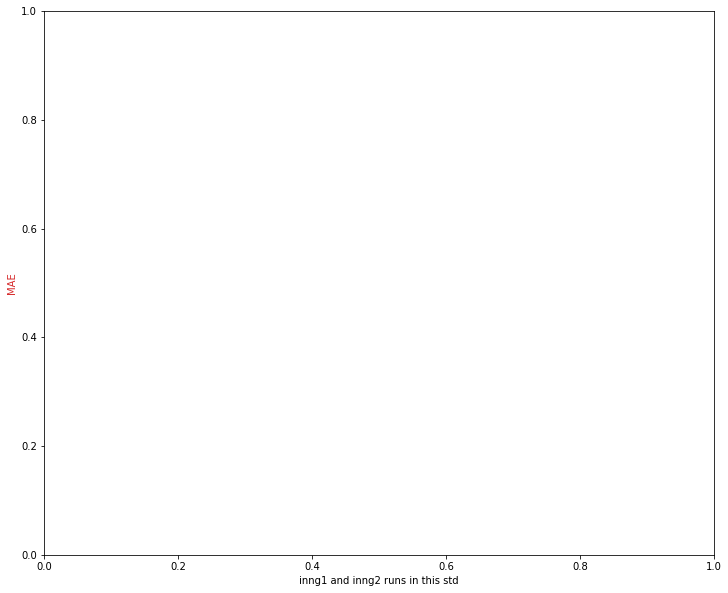

In [51]:
predictRunsForMatch(0,2,False)

In [7]:
#################   Contribution measuring from expectedRuns of an over ############

#inningsCompleteData = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/Results/inprogressOfInning_matchId_'+str(currMatch)+'_'+str(inngs)+'_LR_targetVar_totalRunsScoredCurrentOvr.csv')  


def findContributionForTeam(currMatchId,inningsId):
    
    
    
    inningFeatureVectorCompletePlayerId = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inningsId)+'/inprogress_Inng'+str(inningsId)+'_over1_50Records_2001_19.csv')  
    singleMatch=True
    matchFound,predictedData = predictRunsForMatch(currMatchId,inningsId,singleMatch)
    if(matchFound!=0):
    
        inningFeatureVectorCompletePlayerId = inningFeatureVectorCompletePlayerId[inningFeatureVectorCompletePlayerId['matchId']==currMatchId]#.copy()

        inningFeatureVectorCompletePlayerId.drop_duplicates(keep='first',subset=['overId'], inplace=True)

        inningFeatureVectorCompletePlayerId['runPredicted'] = 0

        #print(inningFeatureVectorCompletePlayerId)

        
        inningsCompleteData = inningFeatureVectorCompletePlayerId.copy()
        inningsCompleteData['runPredicted'] = predictedData
        #print(inningsCompleteData)

        

        inningsCompleteData['bats1Contribution']=0
        inningsCompleteData['bats2Contribution']=0


        team1Players=[]
        team2Players=[]

        team1PlayersContribution= np.zeros(11)

        for i in range(1):
            for col in inningsCompleteData.columns:
                if col.startswith('batsman'):
                    team1Players.append(inningsCompleteData[col].iloc[i])
                if col.startswith('bowler'):
                    team2Players.append(inningsCompleteData[col].iloc[i])

        print('team',team1Players)

        for i in range(len(inningsCompleteData)):

            expectedRunsOver = inningsCompleteData['runPredicted'].iloc[i]
            expectedRunsBall = expectedRunsOver/6

            expectedRunsForBatsman1 = (inningsCompleteData['bats1CurrOvrBalls'].iloc[i]*expectedRunsBall)
            expectedRunsForBatsman2 = (inningsCompleteData['bats2CurrOvrBalls'].iloc[i]*expectedRunsBall)
            batsman1Contribution = (inningsCompleteData['bats1CurrOvrRuns'].iloc[i] -  expectedRunsForBatsman1)
            batsman2Contribution = (inningsCompleteData['bats2CurrOvrRuns'].iloc[i] - expectedRunsForBatsman2)

            inningsCompleteData['bats1Contribution'].loc[i]=  batsman1Contribution
            inningsCompleteData['bats2Contribution'].loc[i]=  batsman2Contribution

            playerIndex = team1Players.index(int(inningsCompleteData['onCreasebatsman1'].iloc[i]))
            #print(playerIndex)
            team1PlayersContribution[playerIndex] = team1PlayersContribution[playerIndex]+ batsman1Contribution

            playerIndex = team1Players.index(inningsCompleteData['onCreasebatsman2'].iloc[i])
            team1PlayersContribution[playerIndex] = team1PlayersContribution[playerIndex]+ batsman2Contribution
 
        inningsCompleteData.to_csv('C:/python/Scripts/JupyterNotebooks/matchInProgress/InningsOverRecordsBeforeOverBowled/contribution/contribution_inngs'+str(inningsId)+'_match'+str(currMatchId)+'temp.csv', index=False)
       
        #inningsCompleteData.to_csv(str(matchinProgressDataFolder)+'Results/inprogressOfInning_matchId_'+str(currMatchId)+'_'+str(inningsId)+'_LR__targetVar_totalRunsScoredCurrentOvrallOvers_Contribution.csv', index=False)  
        return team1Players,team1PlayersContribution
    
    else:
        return 0,0


In [119]:
#################   Contribution measuring from expectedRuns of an over ############

#inningFeatureVectorCompletePlayerId = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inngs)+'/Results/inprogressOfInning_matchId_'+str(currMatch)+'_'+str(inngs)+'_LR_targetVar_totalRunsScoredCurrentOvr.csv')  


def findContributionForTeambyProjection(currMatchId,inningsId):
    
    
    
    inningFeatureVectorCompletePlayerId = pd.read_csv(str(matchinProgressDataFolder)+'innings'+str(inningsId)+'/inprogress_Inng'+str(inningsId)+'_over1_50Records_2001_19_withBeforeOverInfo.csv')  
    singleMatch=True
    
    matchFound,predictedData = predictRunsForMatch(currMatchId,inningsId,singleMatch)
    
    print('matchFound', matchFound)
    if(matchFound!=0):
    
        inningFeatureVectorCompletePlayerId = inningFeatureVectorCompletePlayerId[inningFeatureVectorCompletePlayerId['matchId']==currMatchId]#.copy()

        inningFeatureVectorCompletePlayerId.drop_duplicates(keep='first',subset=['overId'], inplace=True)
        print('Length',len(inningFeatureVectorCompletePlayerId), len(predictedData))
        inningFeatureVectorCompletePlayerId['runPredicted'] = 0
        inningFeatureVectorCompletePlayerId['expectedRunsforThisOver']=0
        #print(inningFeatureVectorCompletePlayerId)

        
        #inningFeatureVectorCompletePlayerId = inningFeatureVectorCompletePlayerId #.copy()
        inningFeatureVectorCompletePlayerId['runPredicted'] = predictedData
        

#         runsForThisOver=0
#         for i in range(len(inningFeatureVectorCompletePlayerId)):
#             k=i
#             if(i==(len(inningFeatureVectorCompletePlayerId)-1)):
#                 expectedRunsOver  = (inningFeatureVectorCompletePlayerId['runPredicted'].iloc[i])
#             else:
#                  expectedRunsOver = (inningFeatureVectorCompletePlayerId['runPredicted'].iloc[i]- inningFeatureVectorCompletePlayerId['runPredicted'].iloc[i+1])
#             #print('k',k) 
#             print('expectedRunsOver',expectedRunsOver)
#             inningFeatureVectorCompletePlayerId['expectedRunsforThisOver'].loc[i] =  expectedRunsOver  
            
            #inningFeatureVectorCompletePlayerId['expectedRunsforThisOver'].loc[i] =  expectedRunsOver              

#             #print('expected',inningFeatureVectorCompletePlayerId.at[i,'expectedRunsforThisOver'])
#             #print('expected runs for this over',inningFeatureVectorCompletePlayerId['expectedRunsforThisOver'].iloc[i])
#             if((math.isnan(inningFeatureVectorCompletePlayerId['wicket'].iloc[i]))==False):
                
#                 #print((inningFeatureVectorCompletePlayerId['wicket'].iloc[i]))
#                 playerIndex = teamPlayers.index((inningFeatureVectorCompletePlayerId['wicket'].iloc[i]))
#                 teamPlayersContribution[playerIndex] = teamPlayersContribution[playerIndex]+ (expectedRunsOver*(0.5)*(-1))
#                 expectedRunsOver = expectedRunsOver*0.5
                
#             expectedRunsBall = expectedRunsOver/6    
#             expectedRunsForBatsman1 = (inningFeatureVectorCompletePlayerId['bats1CurrOvrBalls'].iloc[i]*expectedRunsBall)
#             expectedRunsForBatsman2 = (inningFeatureVectorCompletePlayerId['bats2CurrOvrBalls'].iloc[i]*expectedRunsBall)
#             batsman1Contribution = (inningFeatureVectorCompletePlayerId['bats1CurrOvrRuns'].iloc[i] -  expectedRunsForBatsman1)
#             batsman2Contribution = (inningFeatureVectorCompletePlayerId['bats2CurrOvrRuns'].iloc[i] - expectedRunsForBatsman2)

#             inningFeatureVectorCompletePlayerId['bats1Contribution'].loc[i]=  batsman1Contribution
#             inningFeatureVectorCompletePlayerId['bats2Contribution'].loc[i]=  batsman2Contribution

#             playerIndex = teamPlayers.index(int(inningFeatureVectorCompletePlayerId['onCreasebatsman1'].iloc[i]))
#             #print(playerIndex)
#             teamPlayersContribution[playerIndex] = teamPlayersContribution[playerIndex]+ batsman1Contribution

#             playerIndex = teamPlayers.index(inningFeatureVectorCompletePlayerId['onCreasebatsman2'].iloc[i])
#             teamPlayersContribution[playerIndex] = teamPlayersContribution[playerIndex]+ batsman2Contribution
        print('I am here in contribution func')
        inningFeatureVectorCompletePlayerId.to_csv('C:/python/Scripts/JupyterNotebooks/matchInProgress/InningsOverRecordsBeforeOverBowled/contribution/year17/contribution_inngs'+str(inningsId)+'_match_'+str(currMatchId)+'.csv', index=False)
       
    #(str(matchinProgressDataFolder)+'Results/inprogressOfInning_matchId_'+str(currMatchId)+'_'+str(inningsId)+'_LR__targetVar_PrjectedScore_allOvers_Contribution.csv', index=False)  
        return 1,1#teamPlayers,teamPlayersContribution
    
    else:
        return 0,0


In [ ]:
#manOfMatchRecords  = pd.read_csv('F:/LUMS/Cricket Data/manOfTheMatch_ODI_2003_15.csv')


manOfMatchRecords = pd.read_csv(str(matchinProgressDataFolder)+'innings1/inprogressOfInning1_over1Records_playerClustCount.csv')  

manOfMatchRecords = manOfMatchRecords[(manOfMatchRecords['year']==2017)]
print('Matches in 17', len(manOfMatchRecords))


manOfMatchPredDataFile = open('C:/python/Scripts/JupyterNotebooks/matchInProgress/InningsOverRecordsBeforeOverBowled/Results/manOfMatch/manOfTheMatch_predictionData_matchiIdsYear17_File.csv','w')
manOfMatchPredDataFile.write('matchId,manOfTheMatch,matchFound,momPos\n')

# matchIds =[423793,426428,446957,455234,467886,461569,439151,578625,65662,256614,430887,520601,64859,64861,578618,350046,433596,433564,239917,902643,238198,489217,667649,65638,249213,291365,518965,446968,
#           211425,430889,860277,257771,319134,249748,433586,343732,514026,489224,65642,667897,656437,
#           386534,636162,567358,293078,249752,597925,474469,860269,415282,461569]


#matchIdsReq =[1072310,1072311,1072312,1072313,1072314]
#for match in range(len(manOfMatchRecords)):
for matchId in manOfMatchRecords['matchId']:    
    try:
     
        if(match%100==0):
            print('Done', match)

        currMatchId = matchId# manOfMatchRecords['match_id'].iloc[match] #238189 # 237568# 247505 #  #int(len(manOfMatchRecords)
        manOfMatch =  0#manOfMatchRecords['mom_id'].iloc[match] #  33335 # 36185# 49289 # 

        manOfMatchPredDataFile.write(str(currMatchId)+',')
        manOfMatchPredDataFile.write(str(manOfMatch)+',')
        if(currMatchId not in matchIds):

            print('current Match id', currMatchId,'MoM', manOfMatch)
            team1Players,team1PlayersContribution  = findContributionForTeambyProjection(int(currMatchId),1) # findContributionForTeam(int(currMatchId),1)

            team2Players,team2PlayersContribution  = findContributionForTeambyProjection(int(currMatchId),2) #findContributionForTeam(int(currMatchId),2)

#         print("team1:",team1Players )
#         print("Contribution: ",team1PlayersContribution )
        
#         print("\n")
#         print("team2:",team2Players )
#         print("Contribution: ",team2PlayersContribution )
        
        if(team1Players==0 or team2Players==0):
            
            manOfMatchPredDataFile.write('0,')
            manOfMatchPredDataFile.write('-1\n')
        else:
            manOfMatchPredDataFile.write('1,')
            manOfMatchPredDataFile.write('-1\n')
#         else:


#             highestRaterTeam1 = team1Players[list(team1PlayersContribution).index(team1PlayersContribution.max())]
#             highestRaterTeam2 = team2Players[list(team2PlayersContribution).index(team2PlayersContribution.max())]

                
#             #team1PlayersContributionSorted = team1PlayersContribution#.sort()
#             team1PlayersContributionSorted= -np.sort(-team1PlayersContribution)
#             team2PlayersContributionSorted= -np.sort(-team2PlayersContribution)

#             manOfMatchPredDataFile.write('1,')
            

#             if(int(manOfMatch) in team1Players):
#                 manOfMatchPosteam1 = list(team1PlayersContributionSorted).index(team1PlayersContribution[list(team1Players).index(manOfMatch)])
#                 print("manOfMatchPosteam1:",manOfMatchPosteam1)
#                 manOfMatchPredDataFile.write(str(manOfMatchPosteam1)+'\n')

#             else:
#                 manOfMatchPosteam2 = list(team2PlayersContributionSorted).index(team2PlayersContribution[list(team2Players).index(manOfMatch)])
#                 print("manOfMatchPosteam2:",manOfMatchPosteam2)
#                 manOfMatchPredDataFile.write(str(manOfMatchPosteam2)+'\n')

    except:
        print('some error')

# print(currMatch)
manOfMatchPredDataFile.close()


Matches in 17 78
current Match id 1000887 MoM 0
match length 51
here iN
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.08120425e+00 -3.21280039e+00 -5.78534532e-01  3.00456743e-01
  4.09673928e-01 -3.79552782e-02  2.23732087e-01 -4.42904017e-01
  2.63614013e-01 -6.48680485e-03  1.20374044e+01  6.02675300e-01
  1.28135682e+01 -8.73268625e+00  2.41110409e+00  2.47505679e+00
 -1.31183587e+01 -8.48876375e+00 -1.22857310e+01 -5.71172845e+00
  1.23186216e+01 -5.62676656e+00  7.20317622e+00 -1.17397

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.74102985e+01  1.27043898e+01  1.40801296e+01  1.49211566e+01
  1.46811366e+01 -1.27878129e-03  2.18170172e-01 -4.51801502e-01
  2.60633028e-01 -2.57229163e-02  5.97503030e+00 -3.34655713e+00
  1.12350905e+01 -3.22794172e+00  2.94512102e+00  3.16910245e+00
 -1.14574414e+01 -5.29240405e+00 -8.56573622e+00 -5.64853994e+00
  9.73869053e+00 -1.33810129e+00  3.86181186e+00 -1.08123793e+01
  6.91088446e+00  5.85336994e+00 -1.00497992e+00  1.00497992e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.60145407  13.44535117  14.92771512  15.56632657  13.22333605
   0.03523786   0.20255679  -0.46017101   0.29256082  -0.07018446
   3.95182058  -3.28114794   7.04877698  -1.27966742   4.14578177
   3.29524607  -8.99618998  -4.88462008  -7.91921019  -2.34617236
  10.24622533  -1.12331176   6.31804602 -12.02452795   3.7702798
   3.07867111  -1.89961431   1.89961431  -0.86564147   0.86564147]
intercept 56.24684190330787
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.13754259  11.26977135  14.97858076  14.94376588  11.90080857
   0.06506882   0.1239935   -0.35056755   0.25959205  -0.09808682
   4.9463532   -2.24854357  -1.34330935   1.7879518    3.79027302
   2.21360244  -9.65334859   0.50702105  -5.40822734  -0.46020957
   4.93829743   2.1789013    2.85553364 -10.09647949   3.09792949
   2.89425454  -1.48754861   1.48754861  -1.23373449   1.23373449]
intercept 32.852659193812755
Index(['batsmenOfClust_0', '

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.11485589e+01  1.01758083e+01  1.26437798e+01  1.16331950e+01
  1.00057916e+01  9.09500725e-02  9.89253771e-03 -2.94231400e-01
  1.93252690e-01  1.36099107e-04  4.16065559e+00  1.24142826e+00
 -3.68384117e+00  2.77713309e+00  2.82252638e+00  1.51888164e+00
 -7.73802037e+00 -1.09876343e+00 -3.22173798e+00 -7.29399914e-01
  4.47486339e+00  1.60081288e+00  2.84170555e+00 -7.52344554e+00
  6.40840509e-01  1.91636110e+00 -8.36420852e-01  8.36420852e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.85644454  6.60628312  9.3192725   9.20523014  6.45009831  0.03235041
 -0.02107706 -0.099792   -0.01118076  0.09969941  2.47186406  0.07779852
 -4.16962176  3.56661988  1.81316687  0.80767468 -3.27165864 -1.29584361
 -1.49098372 -0.07676302  0.12743326  2.57368023  1.01270167 -3.78270221
  1.22920447  0.40742932 -0.52717317  0.52717317 -1.0389072   1.0389072 ]
intercept 5.69285182012451
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClus

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.33024770e+00  5.19681292e+00  9.07215929e+00  7.25839200e+00
  7.17237153e+00 -9.51235210e-03  1.74680550e-01 -2.65000383e-01
  2.55712130e-02  7.42609727e-02 -1.10323562e+01  7.74659987e-01
  1.49726369e+00 -8.54560616e+00  5.80118192e+00  7.58135340e+00
 -5.93399457e-02  3.68888821e-01 -4.57362623e+00 -3.25906647e+00
  2.68621467e+00  1.04482688e+01  3.61471442e+00  5.86501083e+00
 -7.9

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.41415084   5.67977369   9.57886205   7.56555072   8.17760749
   0.05986454   0.0750356   -0.26580383  -0.04418367   0.17508736
 -14.82080629   0.7795257    1.34901418  -3.3580634    3.30287022
   6.22359038  -0.60999863  -0.44657896  -3.64044493  -4.53923938
   3.06786471   8.36366965   1.42642831   5.2958504   -6.71087333
   1.71462998  -0.22652033  -9.82347056  -0.03971412  -0.2614846


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.32122098   7.43444666   9.0428278    8.39973725   8.40721688
   0.07802084   0.04348346  -0.19150267  -0.07202308   0.14202146
 -17.55439662   0.78615448   0.98562122  -0.55765926   0.71704116
   5.30232085   0.43658471  -1.43831802  -1.86358638  -6.01584445
   3.41946137   4.76290885  -0.27180655   4.50679847  -2.37591992
   5.8643448   -3.20337566  -8.75443139  -0.52851859  -0.60865742

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.26230013e+00  6.09137709e+00  7.48252766e+00  7.81616174e+00
  5.62023760e+00  6.39549667e-02 -3.22527880e-02 -5.87315037e-02
 -1.01133369e-02  3.71426619e-02 -2.19194578e+01  7.80289457e-01
  1.98632847e-01 -6.51002473e-01  1.38544535e+00  2.40806220e+00
  2.52292127e+00 -3.55262148e+00 -7.94672701e-02 -4.70678810e+00
  2.67345051e+00  2.40586134e+00  8.30322658e-01  8.93416383e-01
  5.5

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.18832680e+00  5.77485533e+00  7.49211702e+00  7.96405979e+00
  4.56118091e+00 -2.50570779e-02 -1.08893632e-02  5.52329084e-02
 -1.05681181e-01  8.63947133e-02 -2.40821105e+01  7.55443446e-01
 -3.19001464e-02  1.35974993e+00  5.48424667e-01  2.21314823e+00
  2.27532088e+00 -4.25372305e+00 -4.43141243e-01 -5.02064624e+00
  3.32086683e+00  1.67190958e+00 -4.60596607e-01 -2.75310989e+00
  3.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.32411306e+00  3.01589845e+00  5.96031569e+00  6.00445705e+00
  3.15814310e+00  5.48123855e-02  5.58048595e-02  5.57382616e-04
 -1.60031493e-01  4.88568659e-02 -1.84533046e+01  5.29806124e-01
 -2.16233680e-01  1.05792118e+00 -1.51853421e+00  2.35239225e+00
  2.21605338e+00 -3.21655386e+00  1.02728597e+00 -3.19765056e+00
  1.27908585e+00  2.73881584e+00 -4.49750707e-01 -3.63934691e+00
  3.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 19.03853375  14.25120651  15.70195401  16.59579382  15.9355298
  -0.02450594   0.1776172   -0.42310023   0.29501831  -0.02502933
   9.06214452  -0.85576731  11.4421507   -6.17993641   2.47821836
   3.98392805 -13.29152126  -6.63921664 -10.33650591  -5.03120742
  11.03841107  -3.2064031    5.1292922   -9.97084096   6.39831718
   5.97893693  -0.69336021   0.69336021  -0.07666193   0.07666193]
intercept 79.29515344114441
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.68829610e+01  1.33851055e+01  1.52927643e+01  1.60031396e+01
  1.41211470e+01 -8.20865686e-04  2.35886398e-01 -4.86664732e-01
  2.56703212e-01 -5.10401255e-03  6.04981703e+00 -2.44874299e+00
  9.18267492e+00 -4.25781262e+00  1.69441987e+00  3.52550618e+00
 -8.81099862e+00 -4.93486378e+00 -8.36427049e+00 -4.78277753e+00
  1.02858106e+01 -5.71307700e-01  5.16764938e+00 -1.13185698e+01
  5.36505390e+00  4.21841165e+00 -1.53108749e+00  1.53108749e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.28894672  12.70414922  15.37743066  15.85324611  12.54699426
   0.03486616   0.19372813  -0.42205778   0.26609003  -0.07262655
   4.98964411  -1.72045306   4.16445778  -0.77092319   3.05069297
   3.18195181 -10.83449063  -2.06087979  -6.26109841  -1.79120261
   7.63879448  -0.61350572   5.42563314 -10.7667862    4.19455148
   2.17361384  -1.8689839    1.8689839   -0.37102226   0.37102226]
intercept 43.04943035142675
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 14.09293282  11.09104014  14.66986609  14.38936848  10.69636155
   0.08006225   0.066718    -0.30722977   0.21692027  -0.05647075
   4.26704987   0.09156261  -2.92902766   2.87674161   2.71583042
   2.95806217 -10.07543034   0.09521132  -3.5905752   -1.34095172
   3.81305638   1.81348006   3.12571844  -8.73615192   1.96516773
   2.95025623  -0.90921071   0.90921071  -2.04855343   2.04855343]
intercept 21.741518114287118
Index(['batsmenOfClust_0', '

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.66954668e+00  8.87220622e+00  1.17797756e+01  1.10052961e+01
  9.13057345e+00  9.62494871e-03 -9.04802802e-03 -1.94766088e-01
  1.42417827e-01  5.17713407e-02  3.65936627e+00  1.13760028e+00
 -3.64020439e+00  3.17339890e+00  1.42502373e+00  3.86683454e-01
 -4.24989703e+00 -1.89197121e+00 -3.08989457e+00 -7.74994752e-01
  1.68896079e+00  2.69146181e+00  1.99426280e+00 -4.25727083e+00
  1.58926694e+00  1.58207809e-01 -6.70836468e-01  6.70836468e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.49122802  1.88925571  4.18691132  4.10586414  3.07076677  0.02988273
  0.0356345  -0.04103406 -0.08537513  0.06089196 -0.26897939 -1.32491224
 -1.38418521  3.66745778 -0.5316684   0.54399686 -0.95309437  0.25138498
 -0.40709186  0.52820854  0.34137299  2.60972626  0.29604359 -2.42472965
 -0.02530648 -0.91822339  0.03624287 -0.03624287 -0.76234537  0.76234537]
intercept 5.710249314857364
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.07278471e+01  7.53148502e+00  1.14689153e+01  9.62712020e+00
  8.72352971e+00  3.09096833e-03  1.39390151e-01 -2.56906960e-01
 -2.71848179e-02  1.41610659e-01 -1.23655710e+01  7.64613762e-01
  1.50226460e+00 -4.60649232e+00  3.93584075e+00  6.82949210e+00
 -3.15394769e-01 -2.65051967e-01 -4.91249186e+00 -3.50148671e+00
  2.83558478e+00  8.18872708e+00  2.32394703e+00  5.07549463e+00
 -6.1

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.55947972   6.70509486   8.37883937   7.19608338   7.98897712
   0.07321241   0.03108413  -0.21086276  -0.05647044   0.16303666
 -15.83798654   0.76937362   1.08538587  -1.08501801   0.67949884
   5.07976138   0.42411598  -0.42670717  -2.28671839  -5.70612801
   3.32119538   6.55675516   0.51236323   5.24667853  -5.37633333
   4.77919483  -2.56905742  -8.71473254  -0.43486846  -0.69570593

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.86915364e+00  7.79618961e+00  7.96112163e+00  8.05185072e+00
  7.26754825e+00  8.47080119e-02  1.24459039e-02 -1.23409259e-01
 -1.57727461e-02  4.20280896e-02 -2.19831303e+01  8.09434856e-01
  7.20727940e-01 -1.54563817e+00  2.32928782e+00  3.14056676e+00
  1.12912251e+00 -3.32999225e+00 -6.00063295e-03 -5.08291008e+00
  3.36556405e+00  1.95415893e+00  1.82906162e+00  2.80897002e+00
 -3.9

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.28229417e+00  7.23815241e+00  7.53257394e+00  7.93627097e+00
  5.37117690e+00  7.65551121e-02  4.92310664e-03 -2.02402180e-02
 -9.64645508e-02  3.52265501e-02 -2.31641072e+01  7.66827743e-01
  5.24030896e-02  1.19537397e+00  1.50039447e+00  1.93407650e+00
  3.49404162e+00 -4.03011004e+00 -1.68772388e+00 -5.22888901e+00
  2.82283638e+00  1.35686257e+00  2.94934482e-01 -1.67582302e+00
  3.3

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 4.14883235e+00  4.40304872e+00  6.58427171e+00  7.27509236e+00
  4.48775260e+00  2.06486886e-02  1.61265934e-02  7.01331050e-02
 -1.78153247e-01  7.12448604e-02 -2.48062408e+01  6.91415795e-01
  6.67396608e-02  2.39141802e+00 -9.75751003e-01  3.17701945e+00
  3.41690855e+00 -4.64922226e+00 -3.34711550e-01 -4.24189147e+00
  1.21623027e+00  2.89933566e+00 -1.19691062e+00 -2.16856162e+00
  3.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 0.67546422  1.79502398  3.71430405  3.82465798  0.69846062  0.02774711
  0.15532916 -0.06676952 -0.23114574  0.11483899 -8.64707429  0.27581368
  0.24638872 -0.73987484  1.64577609  1.64328389  2.83436608 -2.66268445
 -0.86999315 -2.80751319  0.95663958 -0.08376932 -0.95656514 -1.36616667
  0.44012707 -2.3795281   2.42304721 -0.19422595  2.1170809   0.96785285
 -0.96785285 -0.65547584  0.65

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 18.98790126  14.21671143  15.6192804   16.42119157  15.98266393
  -0.02172292   0.17933986  -0.42406881   0.30086933  -0.03441746
   8.9336952   -0.93422135  11.47293138  -6.18503198   2.59185705
   4.01382948 -13.32772748  -6.5653323  -10.22559724  -4.90940474
  11.02055568  -3.1576005    4.83182646  -9.898086     6.410772
   5.92753434  -0.64766239   0.64766239  -0.1482798    0.1482798 ]
intercept 80.02050563535067
Index(['batsmenOfClust_0', 'bat

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.69106465e+01  1.34270733e+01  1.52731368e+01  1.59479335e+01
  1.41720347e+01  1.25204824e-03  2.36747498e-01 -4.87241625e-01
  2.59181921e-01 -9.93984306e-03  5.97477563e+00 -2.45740981e+00
  9.20559458e+00 -4.23290554e+00  1.69077346e+00  3.55222831e+00
 -8.83347526e+00 -4.89958138e+00 -8.35633197e+00 -4.71811019e+00
  1.02791297e+01 -5.28833737e-01  5.01884994e+00 -1.12707662e+01
  5.36485205e+00  4.21121038e+00 -1.50194485e+00  1.50194485e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.32228909  12.7558202   15.3769601   15.84263926  12.55560352
   0.03834233   0.19575422  -0.42330314   0.26636425  -0.07715766
   4.90235956  -1.66974224   4.16090256  -0.71777017   2.95554443
   3.23185941 -10.83626141  -2.02689214  -6.3253208   -1.71797101
   7.63799415  -0.54844972   5.26837045 -10.70002025   4.19391439
   2.1914828   -1.8314268    1.8314268   -0.38017239   0.38017239]
intercept 42.9965122009981
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 14.0938573   11.07900527  14.68069195  14.36199044  10.7491714
   0.07916546   0.06550962  -0.30729512   0.22189127  -0.05927124
   4.23960859   0.04165333  -2.93785019   2.85304504   2.83633491
   2.95021437 -10.08088159   0.09787553  -3.46662574  -1.32249543
   3.80028935   1.80236805   3.05161791  -8.73419812   1.95943715
   2.90960683  -0.90816933   0.90816933  -2.08522298   2.08522298]
intercept 21.767849991345756
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.67202244e+00  8.85503928e+00  1.17685579e+01  1.09389408e+01
  9.20748523e+00  8.83188412e-03 -1.12970675e-02 -1.95206921e-01
  1.51505546e-01  4.61665579e-02  3.60634515e+00  1.08546890e+00
 -3.64455511e+00  3.15748756e+00  1.56913777e+00  3.92041455e-01
 -4.26638147e+00 -1.89954425e+00 -2.95425584e+00 -7.39757965e-01
  1.67641197e+00  2.69190476e+00  1.86816677e+00 -4.23713083e+00
  1.58558097e+00  1.09080171e-01 -6.64236300e-01  6.64236300e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.49328175  1.88809423  4.19365489  4.1123865   3.08707722  0.02967007
  0.03509723 -0.04087551 -0.0828339   0.05894211 -0.30038276 -1.33821752
 -1.38918771  3.66155028 -0.47427302  0.54463338 -0.95001765  0.24589502
 -0.34824033  0.5408948   0.32682902  2.61349388  0.24104527 -2.41245127
 -0.02916578 -0.9324056   0.04062983 -0.04062983 -0.78049907  0.78049907]
intercept 5.730344686092256
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.03575486e+01  7.04112155e+00  1.14604552e+01  9.58680732e+00
  8.40256861e+00  2.28614764e-03  1.18968381e-01 -2.51427955e-01
  5.67984728e-03  1.24493579e-01 -1.20290318e+01  7.63184661e-01
  1.59052946e+00 -5.15081963e+00  4.20288438e+00  7.12934112e+00
 -3.54161966e-01 -2.99022613e-01 -4.49554410e+00 -3.68356463e+00
  2.65088743e+00  8.14561369e+00  1.83875210e+00  4.88522285e+00
 -5.5

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.83231175e+00  6.51000564e+00  8.75944015e+00  7.21067589e+00
  8.27992011e+00  8.52845156e-02  4.53809873e-02 -2.28594871e-01
 -6.81338131e-02  1.66063181e-01 -1.55374225e+01  7.72919676e-01
  1.20133577e+00 -1.22185383e+00  1.20429930e+00  5.30282967e+00
  6.95092776e-01 -8.21548448e-01 -2.58300829e+00 -5.84617562e+00
  3.27036444e+00  6.73922385e+00  8.46394368e-01  5.48774077e+00
 -6.1

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.72960174   7.75886258   8.15456412   8.01094279   8.0310463
   0.11062719   0.02521022  -0.14035104  -0.04198059   0.04649421
 -22.90476171   0.83712065   0.79999729  -1.37438172   2.21256193
   3.52027339   1.14830558  -4.33071869   0.2238737   -4.98943709
   3.58952291   2.05025957   0.60565481   3.60761602  -0.97177304
   5.66884142  -2.02836722  -7.77897795  -1.1532536   -0.07115292


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.30387595e+00  7.23819418e+00  7.51222275e+00  7.88405231e+00
  5.33319030e+00  8.02523275e-02  7.28591597e-03 -2.31582846e-02
 -9.58356222e-02  3.14556634e-02 -2.31216133e+01  7.66261704e-01
  5.88384832e-02  1.16581724e+00  1.57600193e+00  1.94502452e+00
  3.54482355e+00 -4.22297286e+00 -1.63549552e+00 -5.22911369e+00
  2.85591482e+00  1.20072547e+00  3.39539717e-01 -1.67274089e+00
  3.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 4.13062578e+00  4.40509423e+00  6.59610316e+00  7.30669680e+00
  4.52240017e+00  1.82235458e-02  1.43405970e-02  7.21856785e-02
 -1.77526412e-01  7.27765909e-02 -2.48297253e+01  6.91640038e-01
  6.42560412e-02  2.41805836e+00 -1.02684804e+00  3.17066927e+00
  3.38335532e+00 -4.52689723e+00 -3.64752055e-01 -4.24191299e+00
  1.18832738e+00  2.99028788e+00 -1.23217467e+00 -2.16759079e+00
  3.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 0.61305074  1.82911465  3.76704243  3.97779456  0.71103077  0.02153612
  0.15250952 -0.06071674 -0.23726776  0.12393886 -8.79398064  0.27815366
  0.23573865 -0.7124639   1.48450938  1.62423865  2.72016042 -2.25206461
 -0.97153414 -2.79976297  0.90691718  0.17289453 -0.99709002 -1.40471991
  0.33962255 -2.31181913  2.32736962 -0.13748491  2.01122728  0.90650799
 -0.90650799 -0.7258434   0.72

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 18.662818    13.42649314  14.81344587  15.62973842  15.21441975
   0.02211553   0.20822497  -0.4443142    0.26212446  -0.04815076
   6.7698533   -2.8716003   11.07558307  -3.44478352   3.19959935
   3.80738024 -12.952836    -5.58319614  -8.97251853  -5.81119759
   9.8283362   -1.80117659   3.74205898  -9.46773625   6.29590771
   6.18632607  -0.94241823   0.94241823  -0.06158024   0.06158024]
intercept 78.65102793186725
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.71222213e+01  1.36207874e+01  1.51801045e+01  1.57581178e+01
  1.37104001e+01  1.26154455e-02  2.09201519e-01 -4.61126748e-01
  2.85648160e-01 -4.63383765e-02  4.58125779e+00 -3.30845283e+00
  7.33052886e+00 -2.44551956e+00  4.37960588e+00  2.62518032e+00
 -8.54104908e+00 -4.62155138e+00 -7.48508147e+00 -2.25896763e+00
  1.01799712e+01 -1.43760961e+00  5.82190200e+00 -1.25674616e+01
  4.62202732e+00  3.12521982e+00 -1.74270500e+00  1.74270500e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.02905934  11.02416636  15.0711483   14.88547698  11.77632962
   0.08621422   0.14442774  -0.41561571   0.27513385  -0.0901601
   4.95260306  -1.87796215  -0.80021626   1.61274419   3.43056954
   2.88758031 -10.61043399   0.4051153   -5.95193029  -0.50554073
   5.71219397   1.77629442   3.05024485 -10.59463416   2.87146303
   3.64190891  -1.24899869   1.24899869  -1.14230499   1.14230499]
intercept 37.23712189250848
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[11.37279865 10.3398493  12.46991279 11.54682534 10.33000477  0.0621584
  0.02232635 -0.29256389  0.23555018 -0.02747104  4.79344392  0.87559914
 -3.4304486   2.88730928  2.69842025  1.89762891 -8.79112423 -0.93082867
 -3.28093587 -0.50286035  4.62576727  1.92247839  2.40874762 -7.7731151
  0.48468893  2.1152291  -0.62870122  0.62870122 -2.1806267   2.1806267 ]
intercept 22.300478411240505
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClus

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.79052504e+00  7.00706299e+00  1.02598854e+01  9.74797185e+00
  7.24776232e+00  3.84569964e-02 -1.24290411e-02 -1.42463475e-01
  1.56349282e-02  1.00800592e-01  3.18146612e+00  1.22932919e-04
 -4.00029150e+00  2.52618791e+00  1.99975378e+00  3.60799182e-01
 -2.79836330e+00 -1.26967512e+00 -1.58790898e+00  5.43435457e-01
  9.12023955e-01  1.96061279e+00  1.30580024e+00 -4.00334315e+00
  7.73906276e-01  9.54734184e-02 -6.33025676e-01  6.33025676e-01

match length 45
here iN
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  0.82495028  -2.04783805   1.63537954   0.05706713  -0.4695589
  -0.02033113   0.18366482  -0.26021661   0.03642469   0.06045822
 -11.17789908   0.77614922   1.4855515   -9.55467829   6.41071753
   8.29427444  -0.04172274   0.46977299  -5.04883549  -2.80171478
   2.27218634  10.96414527   3.56394226   6.34034487  -8.99439501
  -2.51387869   0.92364032  -4.87004117  -

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.77256782   6.06015062  10.18721365   8.25538266   8.16724653
   0.05387322   0.09433077  -0.28346443  -0.04178023   0.17704067
 -13.72393877   0.76784197   1.43336468  -3.5851511    3.55535596
   6.19164435  -0.9162721   -0.15698957  -4.05996932  -4.57022076
   3.54160253   8.7259101    2.46016787   5.04043837  -6.95149284
   0.530089     0.23359079  -9.19059779  -0.84810549  -0.11868303

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.66043888   6.66068236   8.60064451   7.36674915   7.68213968
   0.0664726    0.02618535  -0.20905211  -0.04681853   0.16321269
 -17.17318216   0.78573198   0.96203598  -1.0570073    0.55537146
   5.88408242   0.0396374   -0.75979961  -2.49968805  -6.26311208
   4.10051577   5.9010773    0.01839203   4.86052407  -3.90600462
   4.9007928   -2.36098538  -8.75308589  -0.66071031  -0.62510849

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.63367480e+00  7.07768598e+00  8.31927857e+00  8.43877655e+00
  6.22007261e+00  5.51169167e-02 -2.68934424e-02 -5.81577589e-02
 -2.39460360e-03  3.23288882e-02 -2.15278560e+01  7.76848729e-01
  3.18717540e-01 -9.12457633e-01  1.53986909e+00  2.86117059e+00
  1.64328841e+00 -3.24814716e+00  6.13572499e-02 -4.45654550e+00
  2.51146494e+00  1.49725174e+00  1.70774295e+00  1.18910071e+00
  1.6

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.11376229e+00  5.87510006e+00  7.53074325e+00  8.17729998e+00
  4.21690004e+00 -1.77144600e-03 -1.15619510e-03  1.45031674e-02
 -9.47510340e-02  8.31755077e-02 -2.27018289e+01  7.44935507e-01
 -3.98131952e-02  9.21930696e-01  1.85009667e+00  1.75922558e+00
  2.41632154e+00 -3.55152714e+00 -1.74011922e+00 -5.11325716e+00
  3.45732903e+00  5.33203580e-01  3.52716294e-01 -2.11693664e+00
  4.3

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.93027069e+00  3.10427939e+00  6.33608206e+00  6.28714514e+00
  3.55804598e+00  5.99092292e-02  1.04957338e-02 -1.28156806e-02
 -9.62058890e-02  3.86166066e-02 -2.29976756e+01  6.39915932e-01
 -6.70283262e-02  1.03930894e+00 -1.00347684e+00  2.89370054e+00
  1.99870084e+00 -3.50249877e+00  8.56449194e-01 -3.70643764e+00
  1.42425374e+00  2.54823175e+00  3.42696770e-01 -2.66858769e+00
  2.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.62773149e+01  2.04247159e+01  2.23410052e+01  2.31350969e+01
  2.28139179e+01 -5.59702236e-02  1.83889730e-01 -4.35144613e-01
  3.22843363e-01 -1.56182569e-02  1.16880925e+01  5.26706463e-01
  1.24869896e+01 -7.54847914e+00  2.62349275e+00  3.26420837e+00
 -1.36777125e+01 -9.36329807e+00 -1.06348824e+01 -7.02941255e+00
  1.21712343e+01 -5.75377347e+00  7.88938629e+00 -1.12812103e+01
  7.68370648e+00  6.95495158e+00 -4.83319390e-01  4.83319390e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.73849065e+01  1.27217651e+01  1.45782649e+01  1.51904342e+01
  1.44500939e+01 -2.20500028e-03  2.10632142e-01 -4.62857381e-01
  2.54300079e-01  1.30159083e-04  6.91008190e+00 -4.03517770e+00
  1.00163765e+01 -3.56452842e+00  2.63840133e+00  3.20137342e+00
 -1.03639772e+01 -4.80254985e+00 -8.07074514e+00 -5.92059561e+00
  9.07881910e+00 -1.19994233e+00  5.11385925e+00 -1.10782708e+01
  6.62841913e+00  5.44845637e+00 -1.24969630e+00  1.24969630e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.71023612e+01  1.30490469e+01  1.50309025e+01  1.58118793e+01
  1.29034025e+01 -9.53020256e-04  1.94997594e-01 -4.35686035e-01
  2.92849412e-01 -5.12079510e-02  3.80140577e+00 -3.39367886e+00
  6.34060963e+00 -3.93638375e-01  4.44720184e+00  3.64204594e+00
 -9.87544715e+00 -4.56849878e+00 -7.60498667e+00 -2.03403437e+00
  9.43169447e+00 -1.35880771e+00  5.94643015e+00 -1.20793449e+01
  4.04022942e+00  3.65881959e+00 -1.85788981e+00  1.85788981e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.34778545  11.20121854  14.56544743  14.5345104   11.54153174
   0.05731997   0.11718129  -0.34440817   0.24768234  -0.07777543
   4.80188488  -2.34794775  -1.37592737   2.11471526   4.03084262
   2.10351537 -10.11945243   0.79236941  -4.95849175  -0.72007098
   4.57418488   2.46184527   3.31557283 -10.18811559   2.7339181
   2.78115724  -1.37245994   1.37245994  -1.15445432   1.15445432]
intercept 31.406477320981153
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.06321331e+01  9.87488322e+00  1.19694054e+01  1.07738803e+01
  9.82916451e+00  7.57030404e-02  2.18614206e-02 -3.12953144e-01
  2.04831231e-01  1.05574519e-02  4.33471496e+00  1.44806236e+00
 -3.34562855e+00  2.38708542e+00  2.85686902e+00  3.87152174e-01
 -6.61739843e+00 -1.45085696e+00 -4.07602691e+00 -9.85421984e-01
  4.08804284e+00  2.47816432e+00  3.42197355e+00 -6.74212486e+00
  8.59040322e-01  9.56352724e-01 -9.84945462e-01  9.84945462e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.21027147e+00  6.41086723e+00  8.77554569e+00  8.63856289e+00
  6.05260217e+00  9.54014291e-03  4.76730085e-03 -1.23261807e-01
  2.64859230e-02  8.24684399e-02  2.09893323e+00 -2.60669666e-02
 -3.41445460e+00  3.53897118e+00  1.29864917e+00  4.02597719e-01
 -2.72397693e+00 -1.17465281e+00 -1.28125066e+00 -6.77643442e-02
  6.61356431e-01  2.01573879e+00  9.95689080e-01 -4.31063125e+00
  1.22552266e+00  7.61339288e-01 -3.81397709e-01  3.81397709e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.25391738e+00  5.21757626e+00  8.95405739e+00  7.17322678e+00
  6.96014653e+00 -8.98542763e-04  1.74411048e-01 -2.68018448e-01
  1.99937131e-02  7.45122297e-02 -1.10381793e+01  7.72772846e-01
  1.45162452e+00 -8.72516904e+00  5.66393853e+00  7.65100350e+00
  9.39127723e-03  3.90475779e-01 -4.51126747e+00 -3.29742472e+00
  2.81905214e+00  1.04257593e+01  3.77113253e+00  5.73278771e+00
 -7.7

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 9.43303726e+00  5.81170714e+00  9.52045342e+00  7.55801560e+00
  8.16037799e+00  7.15212945e-02  7.72656569e-02 -2.69086037e-01
 -5.32757355e-02  1.73574822e-01 -1.48278429e+01  7.77040216e-01
  1.29269513e+00 -3.54338448e+00  3.12200209e+00  6.30503655e+00
 -5.06982119e-01 -4.67937378e-01 -3.55654370e+00 -4.57412567e+00
  3.22193471e+00  8.34925748e+00  1.56535952e+00  5.20502018e+00
 -6.5

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.30937854   7.55490362   9.00960811   8.40972958   8.42494631
   0.08980854   0.04557744  -0.19452884  -0.0805381    0.13968096
 -17.55866789   0.78365669   0.9282948   -0.72955546   0.52283034
   5.38346208   0.54080008  -1.45196853  -1.78250991  -6.02712054
   3.54406194   4.74883548  -0.14278885   4.37648147  -2.27518468
   5.55369468  -3.13212924  -8.65941854  -0.46949032  -0.60189777

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.29464854e+00  6.19345982e+00  7.40144596e+00  7.80205053e+00
  5.61255796e+00  7.84714871e-02 -2.92128874e-02 -6.30926317e-02
 -1.95112139e-02  3.33452457e-02 -2.18981670e+01  7.76947319e-01
  1.37254445e-01 -8.07518088e-01  1.13545084e+00  2.51083692e+00
  2.60518741e+00 -3.53143739e+00 -3.61506779e-03 -4.70899762e+00
  2.80009300e+00  2.38248207e+00  9.28418748e-01  7.61130790e-01
  6.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.18391853e+00  5.92801990e+00  7.41955182e+00  7.95912600e+00
  4.67401347e+00 -1.01599496e-02 -8.37401580e-03  5.09521944e-02
 -1.12568871e-01  8.01506417e-02 -2.40032823e+01  7.51128190e-01
 -8.73748818e-02  1.24364439e+00  2.97501460e-01  2.29893247e+00
  2.37834440e+00 -4.25371019e+00 -3.78542347e-01 -5.01995160e+00
  3.43378143e+00  1.66494179e+00 -3.79184937e-01 -2.90556807e+00
  3.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.32207118e+00  3.13158028e+00  5.88749252e+00  6.02380875e+00
  3.27084713e+00  6.73954088e-02  5.75066724e-02 -2.82984170e-03
 -1.63572363e-01  4.15001238e-02 -1.83989215e+01  5.26056296e-01
 -2.64057292e-01  1.00619199e+00 -1.75302043e+00  2.41857744e+00
  2.30505039e+00 -3.21959795e+00  1.05468502e+00 -3.18078905e+00
  1.36890259e+00  2.72893296e+00 -4.13948286e-01 -3.77715927e+00
  3.1

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[-0.17694509  0.78079387  1.58989368  1.25020104 -0.59292265 -0.02183565
  0.05847987 -0.05746111  0.01437028  0.00644661 -1.42394186  0.08093933
  0.169164   -0.57807687  0.08411668 -0.03134446  0.58903765  1.15529637
 -0.32444671  0.1616693  -1.05625195  0.43809907 -0.91415611 -1.02205087
  1.84641847 -1.19008151  1.90499264 -0.76435066 -0.29887104  0.17874134
 -0.17874134 -0.55761547  0.55

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.80173508e+01  1.33395232e+01  1.47216549e+01  1.54612622e+01
  1.51398746e+01  8.78330369e-03  2.08755758e-01 -4.40873715e-01
  2.84206750e-01 -6.08720975e-02  8.10276123e+00 -1.25644771e+00
  1.07446027e+01 -5.56011650e+00  2.76756874e+00  4.11780352e+00
 -1.30615089e+01 -5.85466305e+00 -1.01140334e+01 -5.24185956e+00
  1.04357935e+01 -2.66607979e+00  3.50311308e+00 -8.43700673e+00
  6.24114590e+00  6.27892701e+00 -7.02136969e-01  7.02136969e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.70300531e+01  1.29596210e+01  1.48272165e+01  1.53233772e+01
  1.34984423e+01  1.65251179e-02  2.35708351e-01 -4.74996198e-01
  2.54371325e-01 -3.16085962e-02  5.57260204e+00 -2.35769658e+00
  8.96155579e+00 -3.17172339e+00  2.68154736e+00  2.94856880e+00
 -9.22254520e+00 -5.41230882e+00 -7.86347702e+00 -4.35895885e+00
  9.76464370e+00 -4.28811990e-01  4.93566096e+00 -1.15252240e+01
  5.67779345e+00  3.79837371e+00 -1.70916465e+00  1.70916465e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.78557463  12.15604493  15.03857826  15.39242398  12.16400778
   0.05229567   0.18219729  -0.44004334   0.25993793  -0.05438754
   4.05605329  -1.96898442   2.45928594   0.48023119   2.82671517
   3.21704586 -10.26958465  -0.80076237  -6.58739434  -1.04544401
   7.49371739  -0.0720183    4.34424646 -10.84276755   3.53722301
   3.17243734  -1.73581201   1.73581201  -0.72744426   0.72744426]
intercept 43.52383403067556
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[13.27920565 10.89235506 14.231445   14.02616545 10.54436843  0.12204218
  0.06212247 -0.31444243  0.20321663 -0.07293885  4.31616277  0.44832827
 -3.57091362  3.33680244  3.47652408  2.07300665 -9.69389118 -0.38601941
 -3.24462666 -0.24434611  4.24975394  1.52736261  2.64159445 -8.42292292
  1.18957056  2.30361413 -0.73590747  0.73590747 -2.1141893   2.1141893 ]
intercept 21.29259241619532
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.86318811  8.18592494 11.31540412 10.64521888  8.37099669  0.02866456
 -0.01164319 -0.19495906  0.13300265  0.04493504  3.37661237  0.92146016
 -3.90397116  2.95469505  1.50823176 -0.22208587 -3.11880445 -1.51613787
 -3.25928617 -0.54858493  1.59134946  2.02604581  2.01915966 -4.0765768
  1.83732921  0.41056375 -0.76640522  0.76640522 -1.59298727  1.59298727]
intercept 8.70970802660247
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.66860418  1.39228574  2.34604482  2.67317122  1.63031691  0.00682875
  0.03421789  0.00271742 -0.05559107  0.01182702 -0.36016603 -0.22865167
 -1.31355325  2.45520395  0.06810737  0.33414578 -1.15020986  0.19512371
 -0.193929    0.90718791 -0.07904137  1.54154937 -0.81231272 -0.99056544
  0.50934669 -0.88223544  0.19031157 -0.19031157 -0.80202731  0.80202731]
intercept 7.073031705187201
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.07637849e+01  7.60104209e+00  1.14764244e+01  9.66809614e+00
  8.69824879e+00  9.07515359e-03  1.41354000e-01 -2.61089994e-01
 -3.51161913e-02  1.45777032e-01 -1.24222396e+01  7.63455258e-01
  1.48609368e+00 -4.64238639e+00  3.92156319e+00  6.91631153e+00
 -3.14721233e-01 -2.65558007e-01 -4.90600263e+00 -3.59573914e+00
  2.88653268e+00  8.12907223e+00  2.39773324e+00  5.09060011e+00
 -6.1

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.56694864   6.72929175   8.3558753    7.20076714   7.91740515
   0.0774845    0.03366062  -0.21415601  -0.06402948   0.16704038
 -15.8799436    0.76896338   1.06959627  -1.15538014   0.67446573
   5.14014724   0.43840705  -0.44206147  -2.26975467  -5.75807881
   3.37225507   6.5118139    0.60037124   5.24846541  -5.32736707
   4.62548743  -2.51611225  -8.71212578  -0.43053287  -0.66249356

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.86402551e+00  7.79692420e+00  7.96797103e+00  8.05315133e+00
  7.28609101e+00  8.39281833e-02  1.14086032e-02 -1.22822377e-01
 -1.33921051e-02  4.08776960e-02 -2.19792608e+01  8.09214636e-01
  7.23745769e-01 -1.51683611e+00  2.32925057e+00  3.13347523e+00
  1.12048409e+00 -3.31997701e+00 -1.43590449e-02 -5.08172029e+00
  3.34968256e+00  1.95694048e+00  1.80508267e+00  2.80834951e+00
 -4.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.29493857e+00  7.28153469e+00  7.53287769e+00  7.96643271e+00
  5.28713236e+00  8.28327707e-02  8.60028175e-03 -2.37613439e-02
 -1.08447006e-01  4.07752977e-02 -2.32516967e+01  7.66950880e-01
  3.59329676e-02  1.12852338e+00  1.50203027e+00  2.00010684e+00
  3.49429204e+00 -4.06463412e+00 -1.66099201e+00 -5.27958134e+00
  2.88025495e+00  1.30390803e+00  3.90169260e-01 -1.68552038e+00
  3.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 4.14580981e+00  4.43348280e+00  6.59421118e+00  7.29659223e+00
  4.43776175e+00  2.37965133e-02  1.74710983e-02  6.88767837e-02
 -1.83824393e-01  7.36799973e-02 -2.48392644e+01  6.90952515e-01
  5.97290804e-02  2.37864614e+00 -9.68577621e-01  3.20461196e+00
  3.40506874e+00 -4.66152586e+00 -3.21790489e-01 -4.27084895e+00
  1.23441607e+00  2.87594938e+00 -1.15352593e+00 -2.17987719e+00
  3.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 0.66970503  1.80857431  3.70957779  3.83039803  0.70602397  0.03038935
  0.15670986 -0.06747674 -0.23625952  0.11663705 -8.66239419  0.27547069
  0.24205352 -0.76008084  1.65544296  1.66247937  2.84211199 -2.68191851
 -0.8642164  -2.82506303  0.97124447 -0.09270719 -0.93106285 -1.36454403
  0.44142916 -2.43428756  2.43839316 -0.18343097  2.12621028  0.98413389
 -0.98413389 -0.66431943  0.66

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.34335060e+01  1.79895640e+01  1.95036586e+01  2.04381819e+01
  2.04205868e+01 -5.02430340e-02  1.76045328e-01 -4.28367508e-01
  3.17874681e-01 -1.53094667e-02  9.84862277e+00  7.77006836e-01
  1.22146416e+01 -6.83432923e+00  2.51719212e+00  3.30471572e+00
 -1.38846679e+01 -7.94318198e+00 -1.18830539e+01 -6.45879397e+00
  1.14685887e+01 -4.40373323e+00  7.45602928e+00 -1.05126873e+01
  7.02216413e+00  7.31148639e+00 -3.47092936e-01  3.47092936e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.73700807e+01  1.29536728e+01  1.46367124e+01  1.52110170e+01
  1.49015444e+01 -1.73311858e-03  2.00738499e-01 -4.47637919e-01
  2.60511835e-01 -1.18792967e-02  6.69340739e+00 -3.41928229e+00
  1.02919778e+01 -4.31464607e+00  2.90119596e+00  3.70606019e+00
 -1.04579659e+01 -5.40074707e+00 -7.63059301e+00 -5.75194747e+00
  8.75698653e+00 -9.35088349e-01  4.42423680e+00 -1.06250652e+01
  6.68611211e+00  5.07535855e+00 -1.34112101e+00  1.34112101e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.63371942e+01  1.25415635e+01  1.50754200e+01  1.59045671e+01
  1.26100818e+01  1.16748051e-02  1.66402902e-01 -4.27733917e-01
  3.18772294e-01 -6.91160832e-02  3.90766896e+00 -2.68806913e+00
  4.98220696e+00 -6.72438696e-01  4.20874763e+00  3.37493117e+00
 -9.55323036e+00 -3.55981654e+00 -7.13526203e+00 -2.05363920e+00
  8.84416428e+00 -6.95476410e-01  5.23394314e+00 -1.14599663e+01
  4.12336721e+00  3.14286927e+00 -1.65290629e+00  1.65290629e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[14.77959574 11.15724569 14.40887279 14.38354472 11.28740494  0.0537151
  0.1022497  -0.33372456  0.25886653 -0.08110677  4.150627   -1.73881377
 -2.32547968  2.57651003  3.22656436  2.87484091 -9.8203521   1.05610325
 -4.43334506 -0.5841487   3.78876825  2.67433034  3.39779784 -9.75794626
  2.28705449  2.62748909 -0.89501127  0.89501127 -1.40112607  1.40112607]
intercept 29.51457894383246
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClus

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.01863644e+01  9.68519627e+00  1.20866349e+01  1.08344237e+01
  9.66208602e+00  5.53902529e-02  7.48306935e-03 -2.64082101e-01
  1.71709297e-01  2.94994822e-02  4.11264549e+00  1.71144934e+00
 -3.74756161e+00  2.00148871e+00  2.05772136e+00  8.36552986e-01
 -5.47206695e+00 -1.50022933e+00 -3.13650165e+00 -1.19715790e+00
  3.63959876e+00  2.69005551e+00  3.16188845e+00 -6.51820145e+00
  1.45253075e-01  1.21506520e+00 -7.22717540e-01  7.22717540e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 5.71423643  5.7805094   7.56365323  7.67759715  4.87564603  0.02661249
  0.04942644 -0.09917166 -0.07352657  0.09665929  0.46599089  0.71095178
 -3.02494096  4.04396925  0.49412685  0.67543914 -2.65867788 -0.70685906
 -1.93234478  0.56994946  0.23128746  2.3653491   0.46892632 -3.02053791
  0.93733285  0.38003749 -0.11825657  0.11825657 -0.98385601  0.98385601]
intercept 5.1235651476099875
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfCl

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.04005511e+01  6.92237534e+00  1.13853968e+01  9.23552212e+00
  9.23871609e+00 -8.15197856e-03  1.40442289e-01 -2.43591560e-01
 -5.42300473e-03  1.16724254e-01 -1.23865590e+01  7.93874042e-01
  1.59612485e+00 -7.08535581e+00  4.53329768e+00  6.97243961e+00
 -1.12832508e-01 -8.42515898e-01 -4.64109472e+00 -2.60925618e+00
  3.78531782e+00  1.00525586e+01  2.86962320e+00  5.27153366e+00
 -6.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.63608739   6.59151412   9.57254546   7.77509916   8.54562721
   0.07675195   0.04427274  -0.25801951  -0.06768427   0.20467909
 -15.36156075   0.77509866   1.20175975  -1.73325879   2.19530423
   5.60298353  -0.67498412  -0.41355846  -3.0933659   -5.52450607
   3.64138557   7.28548799   1.02002914   5.2915418   -6.22086935
   2.79954633  -0.73170254  -9.28410976  -0.15992362  -0.54472672

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.04620666   7.26707598   8.60477955   7.84690591   8.179495
   0.07227098   0.06221576  -0.19321077  -0.060742     0.11946602
 -18.96013053   0.79483636   0.89597685  -1.40416012   0.76660336
   4.64733564   0.86644264  -1.69490293  -0.74811023  -5.42472704
   2.99151868   3.86421811  -0.09226636   4.28158288  -2.19298793
   5.70898781  -2.81268345  -7.9193027   -0.83754837  -0.48241058
 

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.08409216e+00  6.60254467e+00  7.31366277e+00  7.83153646e+00
  5.61312245e+00  3.57341390e-02 -5.52593519e-02  1.31754433e-02
 -8.33937466e-03  1.46891444e-02 -2.31287649e+01  7.84812062e-01
  1.31223731e-01  5.02789243e-01  1.54349136e+00  1.48390529e+00
  2.72644669e+00 -4.86686205e+00 -1.05755660e+00 -4.08286427e+00
  3.75065033e+00  2.66123466e+00  5.38363448e-01 -1.01870402e+00
  3.2

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 5.98837478e+00  5.29208806e+00  7.26623030e+00  8.04935927e+00
  4.70228139e+00 -2.23092962e-02 -1.55469030e-02  4.10914182e-02
 -7.42319877e-02  7.09967687e-02 -2.12445238e+01  6.60117330e-01
 -5.44410570e-02  1.61448907e+00 -1.00851659e+00  2.06640407e+00
  3.75903336e+00 -3.41465187e+00  2.04939195e-01 -4.51401164e+00
  1.29231440e+00  1.77522522e+00 -3.19611557e-01 -1.76781671e+00
  4.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.86362460e+01  1.34883462e+01  1.49498328e+01  1.58749778e+01
  1.53083966e+01  2.26821971e-02  2.00536927e-01 -4.41703318e-01
  2.55628635e-01 -3.71444408e-02  6.94368772e+00 -2.89464860e+00
  1.10815100e+01 -3.66129888e+00  3.31766641e+00  3.70561717e+00
 -1.27948816e+01 -5.69765222e+00 -8.98977525e+00 -6.01156965e+00
  9.84610947e+00 -1.90733146e+00  4.17417906e+00 -9.58609037e+00
  6.23183447e+00  6.24264373e+00 -1.02680050e+00  1.02680050e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.71126353e+01  1.36845636e+01  1.53030650e+01  1.59808238e+01
  1.38152368e+01  1.26720122e-02  2.01808348e-01 -4.57756072e-01
  2.80229965e-01 -3.69542531e-02  4.72962655e+00 -3.34991546e+00
  7.34744581e+00 -2.61426963e+00  4.48920363e+00  2.51605898e+00
 -8.40931738e+00 -4.70883250e+00 -7.47649856e+00 -2.40689486e+00
  1.01840324e+01 -1.53517118e+00  6.19595626e+00 -1.26789864e+01
  4.56182520e+00  3.15573710e+00 -1.81972572e+00  1.81972572e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.00885077  11.09246303  15.17218706  15.08590087  11.82735637
   0.08759581   0.14012026  -0.4131845    0.26624478  -0.08077636
   5.09758213  -1.86486699  -0.79224115   1.40380355   3.51790093
   2.80349486 -10.49439046   0.32871713  -6.01088074  -0.64323535
   5.73383046   1.69040486   3.39961517 -10.68183262   2.82553185
   3.68656637  -1.32087688   1.32087688  -1.08102007   1.08102007]
intercept 36.32251608602013
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[11.36284362 10.37676817 12.51834079 11.65788388 10.3585329   0.06284946
  0.01914131 -0.2900987   0.23005677 -0.02194884  4.87111052  0.8782343
 -3.42327447  2.79138344  2.76019695  1.84206059 -8.74066477 -0.97904655
 -3.28357866 -0.58122619  4.62319705  1.8650185   2.60918232 -7.81963429
  0.44814371  2.13889757 -0.66484202  0.66484202 -2.15178032  2.15178032]
intercept 21.836298695202288
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.78229462e+00  6.99946106e+00  1.02794227e+01  9.80853415e+00
  7.28223307e+00  3.94323749e-02 -1.41205330e-02 -1.41229801e-01
  1.07109292e-02  1.05207030e-01  3.24485440e+00 -4.11265094e-03
 -3.97591159e+00  2.41917532e+00  2.05761201e+00  3.18571608e-01
 -2.76559191e+00 -1.29459718e+00 -1.63361167e+00  4.85957679e-01
  9.30132052e-01  1.91460667e+00  1.47157064e+00 -4.03610647e+00
  7.53525743e-01  1.13925361e-01 -6.62914261e-01  6.62914261e-01

match length 48
here iN
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  0.83864753  -1.9950331    1.61841778   0.03273609  -0.4947683
  -0.01979817   0.18485383  -0.26075473   0.03305158   0.06264748
 -11.18410796   0.77530054   1.47590007  -9.57868429   6.44863607
   8.32688371  -0.15292126   0.45288305  -5.02189487  -2.79035393
   2.31545153  10.82107001   3.62527541   6.36305339  -8.94466065
  -2.62164934   0.98713893  -4.8286404   -

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.9289991    6.25052385  10.24520128   8.32969954   8.16401756
   0.05561015   0.09792977  -0.28375506  -0.05275048   0.18296561
 -13.72382051   0.76550334   1.41135525  -3.61534092   3.63143331
   6.24913227  -1.18185993  -0.21689425  -3.97656102  -4.54455934
   3.65464989   8.38214184   2.61994635   5.09513324  -6.83985244
   0.33049174   0.36421226  -9.15406713  -0.79800587  -0.08155941

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.83858818   6.90777025   8.70113417   7.47287913   7.68258143
   0.06804647   0.03105815  -0.20683085  -0.06484488   0.1725711
 -17.16901625   0.78218485   0.91906506  -1.10653957   0.66548865
   5.95958208  -0.38000023  -0.85661216  -2.35498236  -6.17997636
   4.25303994   5.33750086   0.26253981   4.91105793  -3.73817648
   4.60497768  -2.17688454  -8.66675042  -0.53426485  -0.57516027


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.76444034e+00  7.29906841e+00  8.33593149e+00  8.43958753e+00
  6.26713888e+00  5.53327941e-02 -2.31936581e-02 -5.42390645e-02
 -1.90774225e-02  4.11773509e-02 -2.15486013e+01  7.73207813e-01
  2.64891961e-01 -9.98631041e-01  1.70334744e+00  2.94266917e+00
  1.14121906e+00 -3.32007269e+00  2.21072367e-01 -4.32932138e+00
  2.63971708e+00  8.76248542e-01  1.95475470e+00  1.27017742e+00
  3.2

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.20891653e+00  6.01764030e+00  7.55139959e+00  8.13699487e+00
  4.22291656e+00 -5.07192143e-03  1.00123634e-04  2.12372684e-02
 -1.06885661e-01  9.06201900e-02 -2.25987755e+01  7.39768696e-01
 -9.25000498e-02  8.88596293e-01  2.01515788e+00  1.79759055e+00
  1.92389005e+00 -3.57634538e+00 -1.60482042e+00 -4.97682707e+00
  3.53275809e+00 -2.21167857e-02  5.33385974e-01 -2.06693421e+00
  4.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.96493521e+00  3.22336211e+00  6.39039417e+00  6.25379815e+00
  3.57005465e+00  5.96585392e-02  1.25726519e-02 -9.87198309e-03
 -1.07738654e-01  4.53794466e-02 -2.28337320e+01  6.34439297e-01
 -1.04767822e-01  9.80196290e-01 -8.63089333e-01  2.96517099e+00
  1.59738018e+00 -3.50936523e+00  9.35391480e-01 -3.60178413e+00
  1.49609975e+00  2.10744299e+00  5.03276682e-01 -2.65615076e+00
  2.1

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 0.59762647  0.52789358  2.38567728  2.21535283 -0.22953062 -0.04778498
  0.05595686 -0.01597341 -0.03434237  0.0421439  -1.88458136  0.10878842
  0.07523411 -0.21205654  0.48873005 -0.14634693  0.56580779  0.31750416
  0.37595812 -0.12339722 -1.26619944  1.04188906 -1.84365561 -1.25008771
  0.96620995 -1.68496433  2.62290375 -1.50827007  1.65597496  0.16102281
 -0.16102281 -0.10805654  0.10

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.86616697e+01  1.34968120e+01  1.49569010e+01  1.58998935e+01
  1.52991976e+01  2.52934363e-02  1.96800330e-01 -4.40943419e-01
  2.55460984e-01 -3.66113316e-02  6.94224655e+00 -2.90065006e+00
  1.10855389e+01 -3.53611056e+00  3.35038985e+00  3.59422980e+00
 -1.28249680e+01 -5.71067650e+00 -8.84924181e+00 -6.02905000e+00
  9.83796753e+00 -1.90082689e+00  4.20245520e+00 -9.60136196e+00
  6.06325283e+00  6.27680510e+00 -1.01600130e+00  1.01600130e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 17.12189248  13.73321878  15.32109041  16.01946494  13.84205962
   0.01829003   0.19872224  -0.45692478   0.27634982  -0.03643732
   4.73232232  -3.33117419   7.37374208  -2.51478351   4.51852354
   2.32837324  -8.39303298  -4.7139705   -7.3458375   -2.4074222
  10.18596194  -1.50040979   6.21503807 -12.67398994   4.31239877
   3.21426065  -1.80271155   1.80271155  -0.63808074   0.63808074]
intercept 54.91950253163009
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.03237662  11.11741002  15.17486424  15.12232618  11.84352314
   0.09430873   0.13477472  -0.41115146   0.26196384  -0.07989583
   5.10393092  -1.86574454  -0.75958581   1.58498804   3.58576439
   2.55746951 -10.52039976   0.31357725  -5.78845322  -0.65391801
   5.71695235   1.72620842   3.42721502 -10.68740961   2.49967901
   3.75972605  -1.29882074   1.29882074  -1.06757855   1.06757855]
intercept 36.108661817172035
Index(['batsmenOfClust_0', '

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[11.35971141 10.40649212 12.51825823 11.67856717 10.3688372   0.06906706
  0.01610942 -0.28859842  0.22473943 -0.02131749  4.88102701  0.89862765
 -3.40135834  2.88579827  2.80092352  1.65351898 -8.73607502 -0.98246207
 -3.15476262 -0.57940813  4.61716438  1.89736104  2.62655784 -7.80959377
  0.20555355  2.19712771 -0.64647076  0.64647076 -2.13314009  2.13314009]
intercept 21.694258479818018
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfCl

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.77428821e+00  7.00152188e+00  1.02762176e+01  9.81200333e+00
  7.28584917e+00  4.15877384e-02 -1.71597942e-02 -1.39507582e-01
  9.58997067e-03  1.05489667e-01  3.25328637e+00 -1.26703910e-02
 -3.97152431e+00  2.50497339e+00  2.06997544e+00  2.33632589e-01
 -2.77075384e+00 -1.30691925e+00 -1.52807525e+00  4.78720902e-01
  9.13511663e-01  1.92117129e+00  1.48382066e+00 -4.04317074e+00
  6.38809645e-01  1.35211822e-01 -6.54662325e-01  6.54662325e-01

match length 39
here iN
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  0.68669076  -1.98928241   1.64551319   0.15778871  -0.50071025
  -0.01644764   0.1836387   -0.26041179   0.03067071   0.06255001
 -11.20216943   0.77652301   1.48661056  -9.60537448   6.3565709
   8.24357609  -0.10173246   0.3487312   -4.65817931  -2.86015844
   2.27656651  10.79522969   3.60530568   6.28142405  -9.0533257
  -2.67379759   0.91543641  -4.28755021  -5

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.68514889   6.21508707  10.25200201   8.44318198   8.09900838
   0.06088866   0.09636808  -0.2844659   -0.05308585   0.180295
 -13.77943679   0.76805293   1.43508497  -3.67880342   3.50665649
   6.13899782  -0.97170642  -0.32085101  -3.58353013  -4.65874588
   3.56798255   8.51648745   2.60041907   4.94990519  -6.99582278
   0.21066499   0.27078257  -8.53931448  -1.013122    -0.11181011
 

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.57303278   6.7444985    8.56933114   7.43360143   7.562533
   0.07655034   0.02984029  -0.210825    -0.06254983   0.1669842
 -17.25477071   0.78547341   0.95847146  -1.21049991   0.54785557
   5.86316328   0.02782485  -0.91449255  -2.09199952  -6.35833485
   4.13648313   5.74134743   0.18328325   4.82109649  -3.93558317
   4.53153257  -2.28898422  -8.32247241  -0.73021994  -0.58635533
  

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.53112670e+00  7.18988871e+00  8.25627160e+00  8.46058573e+00
  6.15194761e+00  6.59549811e-02 -2.22497450e-02 -6.00136282e-02
 -2.11490529e-02  3.74574451e-02 -2.17127791e+01  7.78766580e-01
  3.21226759e-01 -1.08531258e+00  1.51641938e+00  2.83916839e+00
  1.60043012e+00 -3.43085030e+00  5.46374542e-01 -4.53026928e+00
  2.54403972e+00  1.34954149e+00  1.84817836e+00  1.16051650e+00
  1.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.04327342e+00  5.81357472e+00  7.50043350e+00  7.97853707e+00
  4.57289873e+00 -1.81436351e-02 -1.05649239e-02  5.25945495e-02
 -1.16097427e-01  9.22114363e-02 -2.40579822e+01  7.54932709e-01
 -4.68776690e-02  1.16155282e+00  5.22670850e-01  2.17876375e+00
  2.24325666e+00 -4.33110100e+00 -6.86792232e-02 -5.05589501e+00
  3.34943116e+00  1.62626607e+00 -3.59177809e-01 -2.83315350e+00
  3.7

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.60919264e+01  2.06570865e+01  2.24608407e+01  2.33856007e+01
  2.30948124e+01 -5.05995750e-02  1.79075238e-01 -4.27864257e-01
  3.22347446e-01 -2.29588524e-02  1.14744409e+01  8.93139343e-01
  1.24361509e+01 -7.74904041e+00  2.48073697e+00  3.18003287e+00
 -1.30097142e+01 -9.70574640e+00 -1.06833033e+01 -7.02737772e+00
  1.22536681e+01 -5.78297060e+00  7.57866720e+00 -1.08182072e+01
  7.63012826e+00  6.84939521e+00 -3.99189170e-01  3.99189170e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.72928109e+01  1.32967473e+01  1.47492326e+01  1.54585080e+01
  1.50999207e+01  1.06251973e-02  1.98432798e-01 -4.47040627e-01
  2.62935593e-01 -2.49529608e-02  6.51681400e+00 -3.46914998e+00
  1.02843798e+01 -4.49277824e+00  2.79710139e+00  3.66754490e+00
 -9.71653233e+00 -5.58737951e+00 -7.71115656e+00 -5.83571876e+00
  8.65111976e+00 -9.29781903e-01  4.33431928e+00 -1.01543861e+01
  6.66819660e+00  4.97740768e+00 -1.38975369e+00  1.38975369e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.25447716  13.16564147  15.43702798  16.36263533  12.48016551
   0.06158182   0.15818285  -0.42276629   0.3047988   -0.10179717
   3.57283986  -2.07694999   4.7123439   -0.78283232   3.55761607
   3.38641992  -8.99439321  -3.37504423  -7.00487372  -2.03771435
   8.25500835  -0.5272412    5.31326629 -10.83300174   3.98512701
   2.84942937  -2.02468149   2.02468149  -0.47001026   0.47001026]
intercept 45.36467432809533
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[14.49420423 11.28447136 14.26304667 14.19615435 11.09793558  0.05066646
  0.10809689 -0.31757026  0.25338822 -0.09458131  3.87594232 -0.94575995
 -2.31911332  2.55850826  2.67802252  2.56107651 -9.48242188  1.07374555
 -4.60340424 -0.41927062  3.72464204  2.48969965  2.59358756 -8.98525439
  3.08532208  2.11467793 -0.96545147  0.96545147 -1.67535536  1.67535536]
intercept 26.75358557792059
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 9.47419802e+00  9.15059869e+00  1.17496995e+01  1.08373293e+01
  9.51369936e+00  2.21146012e-02 -4.13535424e-04 -2.25707041e-01
  1.68090954e-01  3.59150214e-02  3.65930445e+00  1.28919328e+00
 -3.59217905e+00  1.97700938e+00  2.02849597e+00  5.23068010e-01
 -4.52543140e+00 -1.35946064e+00 -3.23464094e+00 -7.93575150e-01
  2.39927559e+00  2.85807159e+00  2.50005611e+00 -5.67736216e+00
  1.01146233e+00  9.36712640e-01 -6.36638893e-01  6.36638893e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.03941320e+01  7.05493499e+00  1.14800285e+01  9.63623294e+00
  8.38633278e+00 -7.87614224e-03  1.21624469e-01 -2.51175358e-01
  8.67945634e-03  1.28747576e-01 -1.20067724e+01  7.61764546e-01
  1.57598357e+00 -5.18783526e+00  4.09816069e+00  7.13372125e+00
 -4.54965306e-01 -1.35424417e-01 -4.55978828e+00 -3.42703723e+00
  2.53316855e+00  8.26443828e+00  1.76685015e+00  4.86368029e+00
 -5.6

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.79952358   6.48381411   8.77529538   7.27396728   8.28364918
   0.07937065   0.0423998   -0.22560731  -0.06938315   0.17322001
 -15.5710827    0.77306972   1.18408096  -1.20102618   1.07392268
   5.30048284   0.5976353   -0.49606303  -2.67224908  -5.8122257
   3.20952317   7.01435798   0.78106419   5.47370592  -6.24875094
   4.32909509  -1.98921279  -9.25102029  -0.10923915  -0.51350311


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.71705272e+00  7.75628062e+00  8.17992312e+00  8.08205098e+00
  8.04601932e+00  1.04974946e-01  2.27665738e-02 -1.37380480e-01
 -4.30502258e-02  5.26891866e-02 -2.29430367e+01  8.37377132e-01
  7.85361750e-01 -1.35643367e+00  2.09562672e+00  3.51489725e+00
  1.06243438e+00 -4.05808188e+00  1.48773426e-01 -4.94760393e+00
  3.54038769e+00  2.27784688e+00  5.48485806e-01  3.59704929e+00
 -1.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.78222233e+00  6.55710615e+00  7.17068238e+00  7.78462158e+00
  5.44950558e+00  4.34206454e-02 -1.43753769e-02 -5.76899064e-03
 -4.87148307e-02  2.54385529e-02 -2.38519353e+01  7.87563520e-01
  3.29141358e-02  9.39091097e-01  1.05743603e+00  1.97804717e+00
  3.79037171e+00 -5.11864871e+00 -1.09567983e+00 -4.60048384e+00
  3.04986636e+00  1.96973676e+00  3.47868906e-01 -1.69500030e+00
  2.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.89984736e+01  1.42383342e+01  1.56017754e+01  1.64168146e+01
  1.59546287e+01 -1.58020498e-02  1.87172005e-01 -4.28142300e-01
  2.87201308e-01 -3.04289632e-02  8.92383546e+00 -8.01804968e-01
  1.15135765e+01 -6.36200907e+00  2.43943440e+00  4.08624270e+00
 -1.32688092e+01 -6.53046577e+00 -1.05514732e+01 -4.87729187e+00
  1.10948260e+01 -3.08977376e+00  4.79716463e+00 -9.80795517e+00
  6.41429685e+00  6.02020651e+00 -6.13947239e-01  6.13947239e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.69109067e+01  1.34296786e+01  1.52734022e+01  1.59507614e+01
  1.41606264e+01  2.19130435e-03  2.38039999e-01 -4.87953755e-01
  2.57070434e-01 -9.34798147e-03  5.97198795e+00 -2.43285441e+00
  9.20623830e+00 -4.24957045e+00  1.65686674e+00  3.56535484e+00
 -8.82376893e+00 -4.89425404e+00 -8.40630282e+00 -4.71265546e+00
  1.02910313e+01 -5.19178759e-01  5.01257788e+00 -1.12570986e+01
  5.36708196e+00  4.22454444e+00 -1.49641467e+00  1.49641467e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.31317964  12.73683704  15.37238786  15.82839874  12.56659175
   0.03773575   0.1958636   -0.42343372   0.26638664  -0.07655228
   4.91145877  -1.69272628   4.16652082  -0.76144957   3.02365629
   3.22239924 -10.83892046  -2.03093882  -6.29168817  -1.72789945
   7.64170244  -0.56528584   5.27862258 -10.71051781   4.19704299
   2.17802327  -1.83817618   1.83817618  -0.39371448   0.39371448]
intercept 43.05074486615719
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 14.11698434  11.1198723   14.68192296  14.39175192  10.71886867
   0.07976063   0.06325303  -0.30587563   0.22483417  -0.0619722
   4.2155022    0.07803762  -2.95417087   3.00497829   2.68778832
   2.96307943 -10.09961338   0.10439837  -3.50696632  -1.30100066
   3.77105811   1.8420859    3.03026615  -8.71587423   1.945137
   2.93529405  -0.89434529   0.89434529  -2.04665641   2.04665641]
intercept 21.726545903988125
Index(['batsmenOfClust_0', 'bat

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.69384587e+00  8.90286283e+00  1.17807229e+01  1.09826333e+01
  9.12003352e+00  1.13405777e-02 -1.00647222e-02 -1.95822652e-01
  1.49182364e-01  4.53644325e-02  3.57499162e+00  1.14851646e+00
 -3.66980678e+00  3.26739257e+00  1.39147894e+00  4.28457062e-01
 -4.27187143e+00 -1.86915843e+00 -3.05426043e+00 -7.13887551e-01
  1.67056329e+00  2.73994952e+00  1.83391150e+00 -4.20706982e+00
  1.57860319e+00  1.52190299e-01 -6.41012282e-01  6.41012282e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.50744861e+00  1.91151465e+00  4.18909219e+00  4.11615746e+00
  3.09178924e+00  3.30290333e-02  4.05197480e-02 -4.21867317e-02
 -9.30852007e-02  6.17231511e-02 -3.09902913e-01 -1.28769924e+00
 -1.37128383e+00  3.58731937e+00 -5.20322009e-01  5.67452767e-01
 -9.27668366e-01  2.62104212e-01 -4.74580202e-01  5.56506241e-01
  3.55892584e-01  2.63716549e+00  2.17416708e-01 -2.38719941e+00
  3.67713183e-03 -9.08878552e-01  5.07547796e-02 -5.07547796e-02

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.03595927e+01  7.07011575e+00  1.15002477e+01  9.65936456e+00
  8.44206074e+00 -4.10943851e-04  1.16835072e-01 -2.49870723e-01
  4.85481229e-03  1.28591783e-01 -1.20469220e+01  7.63363432e-01
  1.58334623e+00 -5.13159197e+00  4.12274905e+00  7.12844706e+00
 -3.81707162e-01 -1.27184494e-01 -4.55560917e+00 -3.68728272e+00
  2.63217942e+00  8.30889807e+00  1.80834330e+00  4.87617620e+00
 -5.6

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.79596098   6.49286065   8.75901111   7.24176281   8.3020953
   0.08029631   0.04199255  -0.22521474  -0.07025295   0.17317883
 -15.57121017   0.77303071   1.18179757  -1.19124133   1.09465363
   5.30699791   0.55200712  -0.4912908   -2.6606061   -5.83039882
   3.21987839   6.98102882   0.78840499   5.49037713  -6.24287451
   4.3334303   -2.00105991  -9.25121801  -0.0980888   -0.50750382


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.70895810e+00  7.75340808e+00  8.18587806e+00  8.09314233e+00
  8.05185792e+00  1.06176435e-01  2.22653703e-02 -1.37110854e-01
 -4.41817632e-02  5.28508128e-02 -2.29634861e+01  8.37959066e-01
  7.88101813e-01 -1.34700478e+00  2.09668191e+00  3.51085047e+00
  1.08852635e+00 -4.06218766e+00  1.49609515e-01 -4.99184373e+00
  3.55536792e+00  2.29685407e+00  5.54534777e-01  3.59594539e+00
 -1.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.75565283e+00  6.55781466e+00  7.15228468e+00  7.73173034e+00
  5.50691307e+00  5.06670942e-02 -1.59127483e-02 -5.03039302e-03
 -5.64838429e-02  2.67598902e-02 -2.39949165e+01  7.90812201e-01
  3.66186217e-02  9.94133034e-01  1.10923849e+00  1.99398124e+00
  3.74347569e+00 -5.10266004e+00 -1.06786550e+00 -4.78726881e+00
  3.11696590e+00  1.93796733e+00  3.94452428e-01 -1.67055317e+00
  2.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 4.96902335e+00  5.07493938e+00  6.36313158e+00  7.20175832e+00
  4.94331384e+00  1.64104525e-02  9.61445746e-03  1.25540081e-02
 -1.19664790e-01  8.10858721e-02 -2.48107369e+01  6.98824755e-01
 -4.63050845e-02  1.79654276e+00 -3.56520257e-01  2.42561220e+00
  3.54834107e+00 -3.75282933e+00 -7.94546700e-01 -3.59923968e+00
  7.32639929e-01  2.54663306e+00 -8.08249565e-01 -2.58052291e+00
  3.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  1.13205067   2.19515198   4.14191748   4.60580146   1.27973631
   0.01703027   0.15845772  -0.01790055  -0.27001592   0.11242848
 -10.74317086   0.3384063    0.05448489  -0.67151696   1.65743876
   1.72432058   2.02719073  -2.80860527   0.05597453  -2.4497174
   0.46491502   0.91861917   0.23399608  -2.27806854   1.46912999
  -2.66924509   1.78092446  -1.23647149   1.78111543   0.67578188


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.89534664e+01  1.43343731e+01  1.56493538e+01  1.64582866e+01
  1.61094414e+01  3.00209823e-03  1.64866190e-01 -4.18870395e-01
  2.86919243e-01 -3.59171372e-02  9.01338782e+00 -8.42999624e-01
  1.15897749e+01 -6.04486507e+00  2.57597896e+00  3.48345618e+00
 -1.31909197e+01 -6.58381354e+00 -1.00499162e+01 -4.85359469e+00
  1.10065674e+01 -2.99417475e+00  4.90033559e+00 -9.76703770e+00
  5.56078919e+00  6.19703121e+00 -5.46039149e-01  5.46039149e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.68271816e+01  1.34369031e+01  1.52589334e+01  1.59231247e+01
  1.42034368e+01  1.42163894e-02  2.29213460e-01 -4.83906715e-01
  2.50576067e-01 -1.00992010e-02  6.04725085e+00 -2.40936745e+00
  9.24324423e+00 -4.18416688e+00  1.72590263e+00  3.24224878e+00
 -8.74660577e+00 -4.91850639e+00 -8.19613030e+00 -4.69828626e+00
  1.02637056e+01 -4.63428455e-01  5.06078896e+00 -1.12074522e+01
  4.91126337e+00  4.32953921e+00 -1.45326564e+00  1.45326564e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.69944732  12.22864671  15.18299721  15.60431973  12.28208503
   0.06320803   0.16896318  -0.43305518   0.24677057  -0.04588659
   4.25672624  -1.95663083   2.46782286   0.44017159   2.93882042
   2.83910493 -10.07508634  -0.91092887  -6.34340034  -1.14287592
   7.4679299   -0.11735785   4.6858241  -10.8902983    3.07111165
   3.26906677  -1.75827459   1.75827459  -0.73460463   0.73460463]
intercept 42.2951230233723
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[13.18766996 10.91444689 14.26779298 14.07051961 10.61600511  0.13032204
  0.05519943 -0.3092012   0.19382416 -0.07014444  4.41775254  0.46288004
 -3.56113941  3.33724094  3.51881445  1.83057796 -9.5762899  -0.42983663
 -3.09023409 -0.24960567  4.21899072  1.53414385  2.74241871 -8.40589308
  0.88316521  2.36701435 -0.7254667   0.7254667  -2.13059636  2.13059636]
intercept 20.931304125128975
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfCl

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.79126665e+00  8.18818686e+00  1.12586988e+01  1.05291308e+01
  8.39037711e+00  3.52619266e-02 -1.05632949e-02 -1.93812312e-01
  1.27989577e-01  4.11241035e-02  3.37191065e+00  9.63480937e-01
 -3.88970826e+00  3.00005269e+00  1.46988852e+00 -3.23772281e-01
 -3.09852140e+00 -1.49333086e+00 -3.20567052e+00 -4.69992113e-01
  1.57533098e+00  2.10606223e+00  1.87240585e+00 -4.00578324e+00
  1.67662256e+00  4.51024258e-01 -7.19728215e-01  7.19728215e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.69054975e+00  1.39034565e+00  2.34657945e+00  2.67610717e+00
  1.62164652e+00  5.23699681e-03  3.43553436e-02  1.66626653e-03
 -5.25004785e-02  1.12418716e-02 -3.68936542e-01 -2.31162357e-01
 -1.31667622e+00  2.45076495e+00  6.12118652e-02  3.62907943e-01
 -1.15723470e+00  1.99125071e-01 -2.12925661e-01  9.06409955e-01
 -7.37489870e-02  1.54015960e+00 -8.19052149e-01 -9.94141442e-01
  5.43814023e-01 -8.90515342e-01  1.87719567e-01 -1.87719567e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.07712669e+01  7.44760999e+00  1.14599556e+01  9.56778054e+00
  8.71909554e+00 -5.99695823e-04  1.39461080e-01 -2.56312564e-01
 -2.51301720e-02  1.42581352e-01 -1.24010276e+01  7.64243202e-01
  1.50266000e+00 -4.52550350e+00  3.94812179e+00  6.86892294e+00
 -3.01633060e-01 -1.97903783e-01 -5.11682113e+00 -3.46529229e+00
  2.79010903e+00  8.28526391e+00  2.27989066e+00  5.09243971e+00
 -6.1

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.5511708    6.72685597   8.38048389   7.21114086   7.98434778
   0.07433546   0.03138683  -0.21122681  -0.05772074   0.16322524
 -15.8310836    0.76947876   1.08382049  -1.11349858   0.67567355
   5.07302184   0.42335967  -0.44484781  -2.23557705  -5.71395519
   3.33582356   6.53357296   0.53334001   5.24044141  -5.37464618
   4.72969399  -2.55983559  -8.65527355  -0.44729305  -0.692697
 

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.84004512e+00  7.84502440e+00  7.98124692e+00  8.08724695e+00
  7.30950141e+00  8.50556582e-02  1.07098305e-02 -1.22176125e-01
 -1.32946597e-02  3.97052957e-02 -2.19419264e+01  8.09049578e-01
  7.27236105e-01 -1.52576049e+00  2.31814292e+00  3.09744872e+00
  1.11111101e+00 -3.35199552e+00  8.26152998e-02 -5.08852563e+00
  3.35696368e+00  1.91620207e+00  1.80985229e+00  2.79257577e+00
 -4.2

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.24627177e+00  7.29485315e+00  7.54289781e+00  7.99068756e+00
  5.39592987e+00  7.96560907e-02  4.61567065e-03 -1.96807931e-02
 -9.87766004e-02  3.41856321e-02 -2.31136339e+01  7.66723883e-01
  5.61479306e-02  1.15934251e+00  1.48370143e+00  1.88129227e+00
  3.48454789e+00 -4.08292614e+00 -1.52388046e+00 -5.24577365e+00
  2.84369615e+00  1.28904004e+00  3.09766151e-01 -1.69868502e+00
  3.3

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 4.14238414e+00  4.40731833e+00  6.58575841e+00  7.27398741e+00
  4.50006592e+00  2.00119652e-02  1.52443650e-02  7.04285564e-02
 -1.75861508e-01  7.01766220e-02 -2.47925693e+01  6.91102710e-01
  6.89399171e-02  2.40733925e+00 -9.80099034e-01  3.17237772e+00
  3.41127821e+00 -4.64139508e+00 -3.33647799e-01 -4.24226805e+00
  1.20641479e+00  2.89841999e+00 -1.21340073e+00 -2.16834735e+00
  3.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 0.60141452  1.8981132   3.71151122  3.85327513  0.74235473  0.03263875
  0.15444741 -0.06648119 -0.23452318  0.11391822 -8.51294649  0.27478857
  0.25407095 -0.77603054  1.61175077  1.575016    2.8111796  -2.72609505
 -0.64724202 -2.83543989  0.98686113 -0.16510384 -0.94598309 -1.41511148
  0.39198971 -2.40721367  2.40806816  0.0569061   2.07644811  0.94716815
 -0.94716815 -0.63326594  0.63

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 19.81520214  14.49153442  16.10681045  17.10574352  16.32343737
  -0.04517873   0.18376779  -0.42736616   0.30956899  -0.02079189
   9.86139465  -0.37826275  11.53187049  -6.32060275   3.00991289
   4.09889716 -13.79135042  -8.01185928 -11.29044463  -6.6397427
  11.70490885  -4.04175041   6.06760874  -9.89153991   7.54418992
   6.54677015  -0.8125868    0.8125868    0.29307465  -0.29307465]
intercept 77.20750455867403
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.66355456e+01  1.30690495e+01  1.46966519e+01  1.52851567e+01
  1.40282398e+01  6.10652014e-03  2.29048971e-01 -4.77926772e-01
  2.51082215e-01 -8.31093390e-03  6.05887802e+00 -3.43452100e+00
  9.05052850e+00 -3.54427186e+00  1.64538687e+00  4.62908255e+00
 -9.45649569e+00 -4.94858739e+00 -8.09401644e+00 -5.55602523e+00
  9.50101273e+00 -1.14628410e+00  4.80324720e+00 -1.07495550e+01
  6.01785918e+00  5.22376169e+00 -1.41416646e+00  1.41416646e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.41814627  12.99145031  15.42826071  16.27606816  12.43766029
   0.05645796   0.15876689  -0.42387716   0.30419409  -0.09554178
   3.65285711  -2.10223841   4.72507842  -0.41199987   3.64204676
   3.4085727   -9.67142794  -3.24288878  -6.95546693  -1.98562253
   8.30917131  -0.47242423   5.3762149  -11.08507036   3.9037992
   2.90939863  -1.96413277   1.96413277  -0.40980561   0.40980561]
intercept 45.51343471711522
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[14.61380933 11.14032789 14.28186521 14.16450096 11.04754558  0.0457391
  0.10807318 -0.31611749  0.25170327 -0.08939805  3.92020039 -0.95498075
 -2.31299585  2.88382441  2.72212016  2.5849935  -9.99703468  1.15387281
 -4.54492668 -0.37597832  3.74220841  2.54562455  2.63424838 -9.19748503
  3.03730363  2.15900505 -0.91881022  0.91881022 -1.62996873  1.62996873]
intercept 26.72190672555439
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClus

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.03338379e+01  6.89764819e+00  1.13599838e+01  9.21707529e+00
  9.22714586e+00 -3.48363715e-03  1.40687504e-01 -2.43578292e-01
 -9.67795974e-03  1.16052385e-01 -1.25877449e+01  7.98364833e-01
  1.61792747e+00 -7.02861744e+00  4.59005785e+00  6.99358894e+00
 -2.68571326e-01 -8.50727288e-01 -4.61979708e+00 -2.69012233e+00
  3.87418867e+00  1.00713199e+01  2.91966563e+00  5.30066843e+00
 -6.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.57437549   6.57066019   9.54750284   7.76251617   8.5154238
   0.08230639   0.04312569  -0.25697644  -0.07112203   0.2026664
 -15.44616811   0.77733682   1.21409381  -1.67933347   2.25128854
   5.59729468  -0.73603806  -0.41235394  -3.06287577  -5.67227416
   3.71429219   7.30510185   1.07568641   5.30816218  -6.21224807
   2.82343491  -0.92271554  -9.24160198  -0.13581976  -0.52914694
 

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.98809621   7.25262729   8.58507956   7.8432442    8.17823765
   0.08072022   0.06040531  -0.19199337  -0.06566066   0.1165285
 -18.98591002   0.79618238   0.90539345  -1.33639733   0.83676636
   4.63455578   0.8618722   -1.69039383  -0.71096864  -5.67715461
   3.08172008   3.90093973  -0.0352377    4.31204763  -2.19028338
   5.75121003  -3.04136793  -7.89221565  -0.80509275  -0.4567403
 

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.07825460e+00  6.57554109e+00  7.31058164e+00  7.85177095e+00
  5.67072972e+00  4.49777364e-02 -5.61246842e-02  1.55155948e-02
 -1.82139405e-02  1.38452936e-02 -2.37858423e+01  7.98254021e-01
  1.63053250e-01  6.01631970e-01  1.64195048e+00  1.48385206e+00
  2.54840943e+00 -4.87669073e+00 -1.00514491e+00 -4.26594451e+00
  3.87193620e+00  2.69933701e+00  5.92790594e-01 -9.45911392e-01
  3.2

match length 51
here iN
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.11866669e+00 -3.19471179e+00 -5.81468800e-01  2.44693442e-01
  4.12820459e-01 -3.89717981e-02  2.23210246e-01 -4.42475554e-01
  2.64494081e-01 -6.25697472e-03  1.21457146e+01  6.49518614e-01
  1.28596110e+01 -9.05323415e+00  2.42943209e+00  2.48831634e+00
 -1.31143945e+01 -8.40496401e+00 -1.22399417e+01 -5.68540735e+00
  1.23608690e+01 -5.64309930e+00  7.29312689e+00 -1.20501505e+01
  9.22358453e+00  6.74101843e+00 -9.1989

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.73683529e+01  1.26518363e+01  1.40154498e+01  1.48038644e+01
  1.46605980e+01 -2.08871384e-03  2.14159593e-01 -4.51313767e-01
  2.61994599e-01 -2.27517103e-02  6.15061528e+00 -3.34299551e+00
  1.12899833e+01 -3.53584365e+00  2.99377556e+00  3.14553882e+00
 -1.14632597e+01 -5.23781412e+00 -8.52662793e+00 -5.67924972e+00
  9.79851213e+00 -1.40673381e+00  4.09642817e+00 -1.11314554e+01
  6.94110018e+00  5.90802643e+00 -1.03941680e+00  1.03941680e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.54663878  13.37094581  14.81522365  15.37283517  13.21761342
   0.03408573   0.19516049  -0.45993976   0.29578996  -0.06509642
   4.20762615  -3.30465209   7.1335327   -1.6374367    4.21744208
   3.24849588  -9.03621447  -4.82879354  -7.89012746  -2.42631905
  10.33485311  -1.23612394   6.6949224  -12.41680028   3.78585933
   3.15373589  -1.95331512   1.95331512  -0.7985743    0.7985743 ]
intercept 57.005252591125455
Index(['batsmenOfClust_0', '

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.08471191  11.2409778   14.93113432  14.85483677  11.89017476
   0.06425115   0.11744415  -0.35091352   0.26283124  -0.09361303
   5.11202572  -2.27296169  -1.31456198   1.64936889   3.80768471
   2.17865665  -9.65541865   0.49520635  -5.41104237  -0.54639492
   5.00190633   2.07552789   3.15865341 -10.27680904   3.07056919
   2.92758951  -1.530133     1.530133    -1.19673264   1.19673264]
intercept 33.20388397016693
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.11212667e+01  1.01365740e+01  1.25338137e+01  1.14898014e+01
  1.00363986e+01  8.91113741e-02  1.88119370e-03 -2.93282274e-01
  1.98164711e-01  4.12499548e-03  4.35383824e+00  1.19492993e+00
 -3.59926627e+00  2.60582121e+00  2.87491145e+00  1.46380683e+00
 -7.77781054e+00 -1.11623085e+00 -3.25313173e+00 -8.23952234e-01
  4.53740015e+00  1.50590459e+00  3.18076710e+00 -7.74604849e+00
  6.36464454e-01  1.96259617e+00 -8.91660086e-01  8.91660086e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.84764012  6.59544094  9.27573944  9.14685638  6.47691097  0.03181036
 -0.02502576 -0.09893452 -0.00990496  0.10205488  2.5679674   0.05987279
 -4.13722729  3.49189705  1.83718263  0.7863278  -3.2903115  -1.31570889
 -1.4969967  -0.12747283  0.15429129  2.52635026  1.18407768 -3.88984905
  1.21347387  0.43612548 -0.55510787  0.55510787 -1.01594323  1.01594323]
intercept 5.863638221192609
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.23181342e+00  5.21594929e+00  8.99196229e+00  7.17802991e+00
  6.96841658e+00 -2.40847362e-03  1.74148431e-01 -2.67531194e-01
  1.57703642e-02  8.00208721e-02 -1.09781319e+01  7.73624912e-01
  1.52382343e+00 -8.65897760e+00  5.83388391e+00  7.65433452e+00
 -2.58105861e-01  3.60674777e-01 -4.48713351e+00 -3.32243312e+00
  2.87775689e+00  1.04550573e+01  3.82322489e+00  5.82110717e+00
 -7.7

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.37886787   5.79591739   9.5781315    7.5639581    8.10999372
   0.06800773   0.07690389  -0.26760937  -0.05902071   0.18171847
 -14.76449422   0.77850144   1.38072805  -3.46635646   3.35144705
   6.2911153   -0.80888177  -0.51449829  -3.52636126  -4.59514266
   3.26867809   8.37136521   1.64987347   5.28943286  -6.58539893
   1.25999228  -0.35144719  -9.64956231   0.01574461  -0.1727316


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.31390808   7.54188723   9.10177466   8.44783854   8.37517209
   0.08684197   0.04542284  -0.19230882  -0.08891563   0.14895965
 -17.47828724   0.785062     1.0273347   -0.63364895   0.75624751
   5.35717387   0.18640017  -1.49363028  -1.73801401  -6.04658036
   3.61205206   4.77856887  -0.07377643   4.48484104  -2.28473719
   5.47837173  -3.38205621  -8.58365574  -0.41755608  -0.53313761

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.27099868   6.17677068   7.51211078   7.83609719   5.57079274
   0.07514315  -0.03011828  -0.06067873  -0.02889425   0.04454811
 -21.81866898   0.77864462   0.23087291  -0.73244357   1.40700923
   2.48235806   2.295198    -3.57623827   0.02711813  -4.75822981
   2.85522824   2.41073566   1.00824096   0.87828445   0.62882906
   5.78183442  -2.13240642  -8.1852258   -0.39029233  -0.15868405

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 5.89174244e+00  5.81846439e+00  7.57047365e+00  8.06991309e+00
  4.85168526e+00  4.75544131e-03 -1.63310193e-02  2.36334884e-02
 -8.60309609e-02  7.39730505e-02 -2.31643536e+01  7.13188621e-01
  9.21740388e-02  9.00575547e-01 -2.88221834e-01  2.87614388e+00
  2.66751338e+00 -3.71345354e+00  7.27421504e-02 -3.93814507e+00
  1.42284549e+00  1.06286428e+00  1.74338076e-01 -2.14833505e+00
  4.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  2.93018352   2.1469637    5.3778766    5.68850949   3.06628219
   0.03624131   0.0358803    0.04958     -0.20594635   0.08424474
 -19.01475705   0.5328559    0.2047764    1.0580496    0.68608417
   1.44888523   0.91752857  -1.42355012  -0.27933365  -4.19427019
   1.78660639   1.92018474  -0.87600511  -2.4535416    2.08371871
  -1.66356608   0.10916787  -2.8307185    3.71075996   0.11923893

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[-0.81993395  0.91411321  0.92275427  0.27022692 -1.34399245 -0.05892515
  0.05726395  0.00410404 -0.04031026  0.03786743 -1.83305182  0.06632792
  0.1445581   0.62808     1.7644022  -0.75430461  0.26853616 -0.56939856
 -0.27992765 -1.01477623 -0.04261132  0.98010682  0.93663747 -1.38233313
  1.02995605 -0.71673937  0.67826333 -0.21061411 -1.31527706  0.64077139
 -0.64077139 -0.35747911  0.35

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.88862143e+01  1.33230688e+01  1.55674240e+01  1.62353526e+01
  1.48919537e+01 -1.22230876e-02  2.12133596e-01 -4.49497610e-01
  2.75814939e-01 -2.62278377e-02  7.59787173e+00 -1.80377687e+00
  1.00858960e+01 -3.88997429e+00  2.69699803e+00  4.32549286e+00
 -1.25723936e+01 -6.44011384e+00 -9.26410622e+00 -5.86314147e+00
  9.70616692e+00 -1.77562388e+00  4.51962653e+00 -9.58740734e+00
  6.12049442e+00  6.14399106e+00 -6.85614326e-01  6.85614326e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.67852483e+01  1.31176870e+01  1.50385191e+01  1.56800064e+01
  1.32680563e+01  1.16438887e-02  2.07981092e-01 -4.57785508e-01
  2.55955830e-01 -1.77953032e-02  4.81715468e+00 -2.77892504e+00
  8.13630593e+00 -2.74605061e+00  3.23929773e+00  2.55587278e+00
 -8.54524924e+00 -4.67840623e+00 -7.47843058e+00 -3.53013025e+00
  1.03464274e+01 -9.35460649e-01  5.72230210e+00 -1.28731102e+01
  5.59413045e+00  3.15427170e+00 -1.86608743e+00  1.86608743e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.3961716   11.1482221   15.35566154  15.40464579  11.72901622
   0.08201911   0.15882802  -0.4340506    0.27111834  -0.07791487
   4.96801602  -2.15383168   0.34871353   0.9202988    3.60931554
   3.65294026 -10.56998148  -0.77547099  -5.90089165  -0.28042016
   6.31572956   0.56594877   3.33413978 -10.87452764   2.75816073
   4.08186059  -1.55779813   1.55779813  -0.75652675   0.75652675]
intercept 38.21313588638628
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[12.12371121 10.74080297 12.94855812 12.43041736 10.18768692  0.03788422
  0.03127396 -0.25640677  0.23148655 -0.04423797  5.03985979  1.08048589
 -3.17595917  2.53081067  2.76268194  1.76158073 -9.57726745 -0.4221924
 -3.2631759  -0.26175568  4.30370373  1.59859883  1.77939804 -7.61772174
  0.97621802  2.48473469 -0.83231192  0.83231192 -2.12245599  2.12245599]
intercept 22.032476010350294
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.18494972e+00  7.51158524e+00  1.07704364e+01  1.02614758e+01
  8.28367170e+00  5.24269533e-02 -1.52091689e-03 -1.86957911e-01
  5.02119897e-02  8.58398850e-02  3.30826487e+00  8.79735798e-03
 -3.37615780e+00  2.30032835e+00  2.28746258e+00 -8.37687649e-01
 -2.24590312e+00 -1.44510458e+00 -2.77276351e+00 -4.27069769e-01
  2.12113435e+00  1.30295242e+00  1.85036494e+00 -3.84864311e+00
  1.32166248e+00  4.52362202e-01 -9.34479237e-01  9.34479237e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 0.77046664  0.43813786  0.89339346  1.08529253  0.56158654 -0.02152997
  0.03134014  0.01555989 -0.01594945 -0.0094206   0.13834157 -0.10051709
 -0.49814115  1.86776313 -0.21266582 -0.23559682 -0.53216896 -0.42701486
 -0.16708642  0.1347178  -0.10541862  0.73210859 -0.65032219 -0.40163886
  0.81570207 -0.35806236  0.15369457 -0.15369457 -0.35460708  0.35460708]
intercept 5.965822907012991
predict Runs [271, 272, 272, 270, 267, 264, 262, 259, 256, 2

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.05884049e+01  7.44655138e+00  1.14058225e+01  9.69975124e+00
  8.52894496e+00  4.60703969e-03  1.34463723e-01 -2.57776516e-01
 -2.31098807e-02  1.41815633e-01 -1.24268661e+01  7.66227515e-01
  1.53255651e+00 -4.71198403e+00  3.78490437e+00  6.76516569e+00
 -3.94174292e-01 -3.38133345e-01 -4.22763942e+00 -3.70047371e+00
  2.82233473e+00  7.90138184e+00  2.28049747e+00  4.96012782e+00
 -5.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.58393082   6.76883187   8.43471382   7.40647634   7.89015001
   0.07623258   0.02843002  -0.21336817  -0.0571396    0.16584517
 -15.88499503   0.77078565   1.10812975  -1.23347743   0.51405472
   5.02847897   0.35609735  -0.52676574  -1.5926717   -5.90087627
   3.3551601    6.25554679   0.5165567    5.14825258  -4.63365901
   4.64472994  -2.56546981  -8.81039119  -0.555566    -0.70061745

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.79055176e+00  7.73212949e+00  7.92994236e+00  8.07722129e+00
  7.16005481e+00  8.58129337e-02  9.62343703e-03 -1.24338921e-01
 -1.38961888e-02  4.27987395e-02 -2.20740819e+01  8.11486681e-01
  7.46844957e-01 -1.61914515e+00  2.23194072e+00  3.09917083e+00
  1.07126054e+00 -3.38819946e+00  4.66394501e-01 -5.20955072e+00
  3.34812874e+00  1.80197320e+00  1.76514872e+00  2.74584884e+00
  7.1

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.23817411e+00  7.18562395e+00  7.40459912e+00  7.80876035e+00
  5.29868854e+00  7.89190329e-02  4.13488290e-03 -2.49427256e-02
 -9.47284655e-02  3.66172754e-02 -2.32860077e+01  7.69440947e-01
  6.89478721e-02  1.06204983e+00  1.42616839e+00  1.95422275e+00
  3.46283825e+00 -4.05374698e+00 -1.34745224e+00 -5.33162625e+00
  2.82754625e+00  1.29668501e+00  2.52634071e-01 -1.68027673e+00
  3.7

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 19.00229486  14.23672055  15.59739692  16.4327843   15.94064916
  -0.01917633   0.18110874  -0.42418372   0.29503494  -0.03278363
   8.92910718  -0.8339      11.49588099  -6.12870752   2.4500805
   3.9268441  -13.29595621  -6.54334904 -10.32728094  -4.87537428
  11.0397872   -3.23431942   4.80963269  -9.85307729   6.42813496
   6.01249708  -0.62137562   0.62137562  -0.13504442   0.13504442]
intercept 80.0568385436504
Index(['batsmenOfClust_0', 'bat

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.69227753e+01  1.34319063e+01  1.52797986e+01  1.59534997e+01
  1.41662205e+01  1.76812473e-03  2.36580470e-01 -4.87768133e-01
  2.60650754e-01 -1.12312155e-02  5.95962767e+00 -2.45923335e+00
  9.19066754e+00 -4.22454457e+00  1.63932320e+00  3.64188673e+00
 -8.85118947e+00 -4.89653775e+00 -8.41434847e+00 -4.71780610e+00
  1.02750851e+01 -4.37082055e-01  5.01232034e+00 -1.12650512e+01
  5.34289879e+00  4.20398352e+00 -1.50073404e+00  1.50073404e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.31322054  12.73836357  15.37271031  15.83054536  12.56901417
   0.03735968   0.19505852  -0.42290925   0.26746076  -0.07696971
   4.91141145  -1.6981829    4.16501027  -0.73785814   3.0236229
   3.21062044 -10.84126568  -2.03335835  -6.27017234  -1.72732741
   7.63393641  -0.5726844    5.27864183 -10.71417018   4.19563957
   2.17613653  -1.8391809    1.8391809   -0.39132481   0.39132481]
intercept 43.04656428324661
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 14.10732938  11.11099828  14.67154894  14.38034057  10.70868121
   0.08212811   0.06812626  -0.30749801   0.21525015  -0.05800651
   4.22575287   0.11847182  -2.92645804   2.90115403   2.71169026
   2.91890563 -10.0649365    0.11541994  -3.56641993  -1.29614154
   3.81376999   1.77712769   3.02828174  -8.69828227   1.97978221
   2.96188211  -0.88747747   0.88747747  -2.07029179   2.07029179]
intercept 21.691159217281026
Index(['batsmenOfClust_0', '

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.76009993e+00  8.90118722e+00  1.17911760e+01  1.10581394e+01
  9.19358406e+00  1.47341012e-02 -3.77644663e-03 -1.89823051e-01
  1.23444571e-01  5.54208251e-02  3.58606812e+00  1.22871557e+00
 -3.57479008e+00  3.23758175e+00  1.54339004e+00  4.80720405e-02
 -4.20792513e+00 -1.86111232e+00 -2.91996060e+00 -6.75742704e-01
  1.67005954e+00  2.37125915e+00  1.82342774e+00 -4.16952591e+00
  1.67539175e+00  2.25091048e-01 -6.19310387e-01  6.19310387e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.53104482  1.86435866  4.20813641  4.16158305  3.11150134  0.03257064
  0.03857564 -0.03675446 -0.0987685   0.06437668 -0.28629218 -1.28642013
 -1.35021029  3.68102983 -0.46456648  0.34306832 -0.90579593  0.26918687
 -0.30057963  0.5689282   0.32173511  2.41778301  0.23810253 -2.38852188
  0.02358058 -0.88102791  0.0623186  -0.0623186  -0.79342433  0.79342433]
intercept 5.3891520901257834
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfCl

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.03290153e+01  7.07672478e+00  1.14832401e+01  9.53305438e+00
  8.53083775e+00 -1.39552603e-03  1.18099496e-01 -2.50660155e-01
  7.42246726e-03  1.26533718e-01 -1.20345450e+01  7.62196289e-01
  1.55585424e+00 -5.07918756e+00  4.24096795e+00  7.20317320e+00
 -3.64630994e-01 -3.68119248e-02 -5.00696250e+00 -3.57489187e+00
  2.61834370e+00  8.46953188e+00  1.82541653e+00  4.93612926e+00
 -6.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.79228975   6.46663728   8.75539767   7.19384692   8.31956452
   0.08069666   0.04292037  -0.22709441  -0.06897572   0.17245311
 -15.56743375   0.77261125   1.16974309  -1.16447122   1.13042507
   5.35926029   0.61391416  -0.41808107  -2.94550743  -5.79283338
   3.2172936    7.12603202   0.78986746   5.50961584  -6.51352703
   4.36381025  -2.00718115  -9.21872903  -0.04988837  -0.50425964

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.69207307e+00  7.72788101e+00  8.15919614e+00  8.01574254e+00
  8.06460553e+00  1.06387847e-01  2.29217704e-02 -1.38689850e-01
 -4.28769860e-02  5.22572190e-02 -2.29505367e+01  8.37345756e-01
  7.77140637e-01 -1.33250458e+00  2.14010616e+00  3.55703904e+00
  1.07742853e+00 -4.00451980e+00 -2.78851275e-02 -4.96269020e+00
  3.55302597e+00  2.35777658e+00  5.57669883e-01  3.61848239e+00
 -1.2

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.74236205e+00  6.54583697e+00  7.16631449e+00  7.77681201e+00
  5.49280399e+00  4.97338580e-02 -1.60202168e-02 -4.52059681e-03
 -5.57422655e-02  2.65492211e-02 -2.40065086e+01  7.91225283e-01
  4.21487111e-02  9.90517270e-01  1.08997879e+00  1.97284903e+00
  3.83203450e+00 -5.12290961e+00 -1.08576612e+00 -4.79387677e+00
  3.11717293e+00  2.00199592e+00  3.83349510e-01 -1.67844355e+00
  2.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 4.97453910e+00  5.08680491e+00  6.37174292e+00  7.25871782e+00
  4.93336927e+00  1.59623190e-02  9.10233129e-03  1.35354640e-02
 -1.19863623e-01  8.12635090e-02 -2.48396367e+01  6.99717154e-01
 -3.71418226e-02  1.78472608e+00 -3.96232454e-01  2.39683736e+00
  3.59767827e+00 -3.79201678e+00 -7.02816759e-01 -3.62406700e+00
  7.35891281e-01  2.54696852e+00 -8.20692901e-01 -2.59384251e+00
  3.9

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  1.18491909   2.1901635    4.16897526   4.67757078   1.30442425
   0.02020258   0.15766293  -0.01536489  -0.27662698   0.11412635
 -10.68546003   0.33775567   0.05626715  -0.67838137   1.64207302
   1.69242611   1.86745831  -2.83999571   0.32519288  -2.48446634
   0.4756931    0.69665253   0.22560183  -2.29434342   1.72373442
  -2.64903828   1.78699108  -1.24903607   1.75943791   0.67027997

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.88671276e+01  1.33265725e+01  1.55404634e+01  1.62183793e+01
  1.48681040e+01 -8.71552014e-03  2.11108826e-01 -4.46896164e-01
  2.71379187e-01 -2.68763290e-02  7.63283986e+00 -1.85796388e+00
  1.01242180e+01 -3.87053129e+00  2.74993471e+00  4.20621850e+00
 -1.25324594e+01 -6.45225650e+00 -9.15841653e+00 -5.84916937e+00
  9.70174604e+00 -1.89186571e+00  4.52243777e+00 -9.54368341e+00
  6.14046599e+00  6.07848521e+00 -6.87264089e-01  6.87264089e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.80780159  13.14345727  15.00751802  15.67667807  13.24946573
   0.01753716   0.20480263  -0.45130113   0.24914777  -0.02018643
   4.86279738  -2.93586866   8.21813699  -2.69973803   3.35118417
   2.43932634  -8.53451178  -4.7013264   -7.30619854  -3.50872689
  10.30996751  -1.03501545   5.71544765 -12.77376928   5.62529918
   2.97299582  -1.8720396    1.8720396   -0.72991923   0.72991923]
intercept 61.44515153910743
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.42389298  11.16163199  15.32414769  15.39360639  11.73353265
   0.08556294   0.15552947  -0.42852115   0.26792383  -0.08049508
   4.9909267   -2.29766828   0.41354228   0.94998086   3.69250747
   3.63384528 -10.5895196   -0.7936147   -5.80163937  -0.26681591
   6.27335931   0.57037355   3.33080574 -10.80803373   2.7718377
   3.93011271  -1.5661473    1.5661473   -0.75245962   0.75245962]
intercept 38.17931263137292
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[12.15841001 10.76016663 12.90885745 12.41326824 10.21206482  0.04228186
  0.02693311 -0.24887945  0.22716207 -0.04749758  5.07017655  0.899817
 -3.10141432  2.57066121  2.85436521  1.74976617 -9.59954929 -0.44382252
 -3.15274693 -0.24577613  4.25014381  1.62057546  1.78179052 -7.53646324
  0.9904271   2.29204941 -0.84024567  0.84024567 -2.11513793  2.11513793]
intercept 22.010523671136625
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClus

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.16980897e+00  7.53214695e+00  1.07391608e+01  1.02335121e+01
  8.24302190e+00  5.22348243e-02 -3.94587297e-03 -1.85832457e-01
  5.47979768e-02  8.27455292e-02  3.28783203e+00 -1.27142600e-01
 -3.37619813e+00  2.31023738e+00  2.25261625e+00 -5.93742558e-01
 -2.28485648e+00 -1.46874590e+00 -2.80451021e+00 -4.46674608e-01
  2.09914253e+00  1.56569022e+00  1.83164926e+00 -3.83323061e+00
  1.29168328e+00  2.96250136e-01 -9.44766788e-01  9.44766788e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 0.76240211  0.43754042  0.90009803  1.08527749  0.56255809 -0.02232682
  0.03177843  0.01429853 -0.01480366 -0.00894648  0.13171956 -0.07263472
 -0.5075983   1.86405158 -0.22637185 -0.23175297 -0.53172298 -0.42569031
 -0.18429729  0.13166991 -0.09860239  0.73433634 -0.65281332 -0.41281268
  0.81014781 -0.32762839  0.15410894 -0.15410894 -0.35473856  0.35473856]
intercept 5.962676614454778
predict Runs [296, 295, 292, 286, 281, 277, 258, 252, 231, 2

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.07295546e+01  7.50978064e+00  1.14817628e+01  9.60512101e+00
  8.73698765e+00  3.00659523e-03  1.39212595e-01 -2.57100671e-01
 -2.48102288e-02  1.39691709e-01 -1.23448942e+01  7.64279989e-01
  1.51214767e+00 -4.55761677e+00  3.86529782e+00  6.84408855e+00
 -3.21633226e-01 -2.27539689e-01 -4.91089404e+00 -3.49738872e+00
  2.80568608e+00  8.23489225e+00  2.28039571e+00  5.07692533e+00
 -6.1

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.61857689   6.6891756    8.41013516   7.13408858   7.99542213
   0.07708753   0.0357751   -0.21579397  -0.05926793   0.16219927
 -15.76511016   0.76866179   1.10280405  -1.08269894   0.42096668
   5.18191312   0.47268912  -0.36245245  -2.23614416  -5.71862048
   3.3243471    6.69339283   0.49589528   5.27372068  -5.30102692
   4.7598309   -2.510387    -8.72855946  -0.6828663   -0.69377125

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.88107130e+00  7.76330954e+00  7.97347440e+00  8.00044555e+00
  7.29156444e+00  8.53348144e-02  1.35331098e-02 -1.24907520e-01
 -1.34809680e-02  3.95205640e-02 -2.19219135e+01  8.08552754e-01
  7.35288538e-01 -1.50163109e+00  2.19588832e+00  3.17913802e+00
  1.14495311e+00 -3.28440352e+00  6.32797742e-03 -5.08003051e+00
  3.33975769e+00  2.04168329e+00  1.77697334e+00  2.82900318e+00
 -3.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.30636552e+00  7.19253099e+00  7.52373042e+00  7.85952276e+00
  5.39050226e+00  7.91131574e-02  8.34570662e-03 -2.32298957e-02
 -9.87608473e-02  3.45318789e-02 -2.30926551e+01  7.65937543e-01
  6.37935644e-02  1.19940849e+00  1.34419159e+00  2.00301967e+00
  3.52606911e+00 -4.00293521e+00 -1.65912930e+00 -5.22902181e+00
  2.81839745e+00  1.46037108e+00  2.77578857e-01 -1.63261192e+00
  3.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 4.14366310e+00  4.40628457e+00  6.58576149e+00  7.27483912e+00
  4.49816860e+00  1.97894182e-02  1.51862501e-02  7.05203813e-02
 -1.75754476e-01  7.02584264e-02 -2.47977318e+01  6.91151934e-01
  6.83784755e-02  2.40809471e+00 -9.74653943e-01  3.17231562e+00
  3.41138010e+00 -4.64051376e+00 -3.41192106e-01 -4.24121105e+00
  1.20578041e+00  2.89787261e+00 -1.21275907e+00 -2.16867241e+00
  3.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 0.6700987   1.79046524  3.71489856  3.84551472  0.68805961  0.0268134
  0.15420914 -0.06615137 -0.2298704   0.11499924 -8.66178449  0.2759862
  0.24355589 -0.74875014  1.69151353  1.630548    2.82004575 -2.6627447
 -0.87913471 -2.80932027  0.95784254 -0.11120363 -0.95403433 -1.37659592
  0.42804421 -2.37459781  2.41000612 -0.19475265  2.17313402  0.96636591
 -0.96636591 -0.65902594  0.65902

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.92140290e+01  1.43691680e+01  1.57923428e+01  1.67644782e+01
  1.60089581e+01 -1.73828871e-02  1.80726880e-01 -4.26650200e-01
  2.95975747e-01 -3.26695391e-02  8.67577732e+00 -9.23497492e-01
  1.13506381e+01 -5.38567824e+00  2.42130748e+00  4.04957453e+00
 -1.34378242e+01 -6.75029751e+00 -1.04767199e+01 -4.98607971e+00
  1.09500894e+01 -3.09857176e+00  4.70610103e+00 -9.16753562e+00
  6.20010415e+00  5.87261238e+00 -6.16833512e-01  6.16833512e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.68254226e+01  1.34078778e+01  1.52676376e+01  1.60223049e+01
  1.40580133e+01  3.48244748e-03  2.37444863e-01 -4.89357716e-01
  2.57682074e-01 -9.25166869e-03  5.84174523e+00 -2.45213223e+00
  9.09988201e+00 -3.79363291e+00  1.58904777e+00  3.56948628e+00
 -8.81250212e+00 -5.04189403e+00 -8.45293358e+00 -4.77206212e+00
  1.02568436e+01 -5.35196324e-01  4.96009646e+00 -1.08711209e+01
  5.26847395e+00  4.14589892e+00 -1.49315501e+00  1.49315501e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.26220072  12.67769578  15.37764892  15.89848091  12.45731279
   0.03851918   0.19601718  -0.42519748   0.26655252  -0.0758914
   4.81049869  -1.73153855   4.08019361  -0.42558199   2.9970642
   3.23330675 -10.84612977  -2.11781294  -6.32082112  -1.78350306
   7.61517282  -0.58120629   5.23433135 -10.40686921   4.1151547
   2.12774082  -1.83024387   1.83024387  -0.43091716   0.43091716]
intercept 43.29454073722566
Index(['batsmenOfClust_0', 'bats

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 14.07109921  11.06530834  14.66831996  14.4103751   10.61871507
   0.08377577   0.06833848  -0.31141729   0.21692333  -0.05762029
   4.12798669   0.06445656  -2.99775801   3.20940806   2.66792837
   2.99717369 -10.10602262   0.03682725  -3.6549742   -1.35495423
   3.81210426   1.81596329   3.01106893  -8.41897944   1.87691838
   2.91285301  -0.88626854   0.88626854  -2.10032295   2.10032295]
intercept 21.94306864224525
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.67033963e+00  8.85748208e+00  1.17231521e+01  1.09431870e+01
  9.08353781e+00  1.56982542e-02 -6.54678432e-03 -1.99469434e-01
  1.41762896e-01  4.85550676e-02  3.50862209e+00  1.10696208e+00
 -3.67754038e+00  3.49308785e+00  1.37274980e+00  4.42812075e-01
 -4.31734852e+00 -1.92934500e+00 -3.16548925e+00 -7.62478189e-01
  1.68579886e+00  2.72744517e+00  1.79830781e+00 -3.92793567e+00
  1.51690970e+00  1.27441567e-01 -6.40678288e-01  6.40678288e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.08218722e+01  7.41945202e+00  1.16557108e+01  9.59832196e+00
  9.20740423e+00 -4.58686636e-03  1.25422630e-01 -2.44610387e-01
  5.31320669e-03  1.18461416e-01 -1.11121788e+01  7.63867460e-01
  1.65334243e+00 -6.07294359e+00  4.46394079e+00  6.64560002e+00
  3.30722487e-02 -6.47013696e-01 -4.66025280e+00 -3.51366176e+00
  3.75125879e+00  9.14455631e+00  2.46200879e+00  5.34955415e+00
 -5.6

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.86645063   6.23511073   8.91102189   7.22445916   8.32104053
   0.10080145   0.02835492  -0.24312123  -0.06989541   0.18386027
 -15.29203986   0.76811929   1.19832166  -1.22975048   1.9375929
   5.25504715  -0.51860274  -0.21312662  -3.02925716  -5.7751856
   3.57328256   7.23444367   1.11155322   5.40787675  -6.20838153
   3.63317693  -1.51096193  -9.72773907   0.06003195  -0.4190717
  

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.92315951   7.24375793   8.49227164   7.8396406    8.01181411
   0.09118525   0.04952495  -0.15552808  -0.03630413   0.05112201
 -18.93148164   0.77823184   0.84516109  -1.40134915   2.35759787
   4.14304346   1.21430377  -3.16779111   0.16368767  -5.70444113
   2.39494862   3.22476331   0.3374151    3.76049794  -1.73163994
   5.43603863  -1.89128664  -7.99809658  -1.13769182  -0.16402229

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.74017697e+00  6.53344037e+00  7.16332119e+00  7.77493107e+00
  5.49011963e+00  5.00331833e-02 -1.71393144e-02 -5.80857613e-03
 -5.17368752e-02  2.46515824e-02 -2.39585927e+01  7.89589404e-01
  3.49012787e-02  9.57179998e-01  1.08545800e+00  1.97586850e+00
  3.91929150e+00 -5.11163491e+00 -1.08829019e+00 -4.82174531e+00
  3.08387241e+00  1.98581384e+00  3.63211849e-01 -1.68991648e+00
  2.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.35586162e+01  1.80527506e+01  1.95661189e+01  2.05061684e+01
  2.04943010e+01 -5.29735273e-02  1.75564369e-01 -4.27469009e-01
  3.19601991e-01 -1.47238240e-02  9.84318319e+00  7.92044999e-01
  1.22317188e+01 -6.80981846e+00  2.54056238e+00  3.28359614e+00
 -1.41160455e+01 -7.76524160e+00 -1.18905544e+01 -6.34176225e+00
  1.14621273e+01 -4.37773971e+00  7.45752727e+00 -1.06786372e+01
  7.02121448e+00  7.34782452e+00 -3.24840049e-01  3.24840049e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.74638771e+01  1.29001937e+01  1.46546764e+01  1.51717846e+01
  1.49158286e+01 -2.19975151e-03  2.01776746e-01 -4.49316697e-01
  2.62186849e-01 -1.24471470e-02  6.80247981e+00 -3.42187486e+00
  1.03275642e+01 -4.24673542e+00  2.96910331e+00  3.73316968e+00
 -1.07285112e+01 -5.43519555e+00 -7.59685239e+00 -5.79174744e+00
  8.81562944e+00 -8.93665099e-01  4.49923130e+00 -1.07808614e+01
  6.66416472e+00  5.08410084e+00 -1.31545909e+00  1.31545909e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.64171158e+01  1.24473067e+01  1.50619724e+01  1.58215257e+01
  1.26043048e+01  1.13102627e-02  1.67162673e-01 -4.30301354e-01
  3.22085120e-01 -7.02567016e-02  4.03049598e+00 -2.70483457e+00
  5.02501993e+00 -6.03316413e-01  4.28953318e+00  3.41047214e+00
 -9.84095658e+00 -3.60641366e+00 -7.10805559e+00 -2.11379666e+00
  8.92007645e+00 -6.53469389e-01  5.33260586e+00 -1.16283692e+01
  4.09526175e+00  3.15574675e+00 -1.62387339e+00  1.62387339e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 14.83101056  11.12598001  14.38892884  14.35799198  11.27803747
   0.05093476   0.10106271  -0.33270742   0.26187908  -0.08116913
   4.15821221  -1.72930688  -2.30786122   2.62204252   3.25279114
   2.86359263 -10.04818255   1.18871214  -4.43342643  -0.49122095
   3.79070725   2.70071645   3.41894839  -9.93136367   2.28538736
   2.6602516   -0.87613323   0.87613323  -1.36029596   1.36029596]
intercept 29.6136719849942
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.01931797e+01  9.70920360e+00  1.20875624e+01  1.08706290e+01
  9.64887243e+00  5.34739572e-02  6.59318578e-03 -2.62333391e-01
  1.71767429e-01  3.04988191e-02  4.06255413e+00  1.72882269e+00
 -3.76468284e+00  2.00075924e+00  2.04943082e+00  8.08148627e-01
 -5.53369970e+00 -1.35133297e+00 -3.14305829e+00 -1.08999757e+00
  3.60949480e+00  2.68909115e+00  3.14142938e+00 -6.58710787e+00
  1.40580260e-01  1.23956813e+00 -7.17165564e-01  7.17165564e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 5.7446866   5.74516093  7.57997448  7.73524889  4.85350307  0.023
  0.04770716 -0.09720497 -0.07138381  0.09788161  0.41122696  0.72312267
 -3.03939292  4.04808782  0.49598044  0.62819317 -2.81449518 -0.45272298
 -1.92953974  0.74787128  0.19715572  2.36897399  0.45802883 -3.18188216
  0.92042223  0.41896985 -0.10182239  0.10182239 -0.92794062  0.92794062]
intercept 5.057782686253333
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2'

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.08306407e+01  7.43083338e+00  1.16702717e+01  9.61093625e+00
  9.22167373e+00 -4.61002149e-03  1.25982091e-01 -2.44479702e-01
  3.69004014e-03  1.19417592e-01 -1.11102894e+01  7.64312639e-01
  1.65719603e+00 -6.05176386e+00  4.46837944e+00  6.65189945e+00
 -2.92452637e-02 -6.49158649e-01 -4.65888852e+00 -3.49954519e+00
  3.76832259e+00  9.15879065e+00  2.46581149e+00  5.35639747e+00
 -5.6

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.85822112   6.22954801   8.93226686   7.22900944   8.33352623
   0.09854047   0.03078071  -0.24691738  -0.06826139   0.18585759
 -15.3022252    0.76841904   1.20851768  -1.3139481    1.91004507
   5.2733422   -0.53522305  -0.22283327  -3.08237334  -5.78690001
   3.75789051   7.19920486   1.23753019   5.36603114  -6.21939684
   3.57196296  -1.52834691  -9.71850571   0.0915203   -0.41935269

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.92106006   7.23700345   8.50947927   7.84486577   8.02147438
   0.0896965    0.0520439   -0.15777932  -0.03753549   0.05357442
 -18.93529299   0.77888753   0.85626331  -1.43262244   2.34282294
   4.15758667   1.14263055  -3.181561     0.13407549  -5.69441174
   2.53147954   3.21717184   0.42012698   3.74400937  -1.7407814
   5.41245337  -1.9621077   -7.98346063  -1.10741182  -0.16406048


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.75352971e+00  6.57021440e+00  7.18336281e+00  7.82566635e+00
  5.53308082e+00  5.25916263e-02 -2.07370723e-02  2.44250157e-03
 -5.76446211e-02  2.33475655e-02 -2.39899301e+01  7.90727243e-01
  2.86905135e-02  1.09664750e+00  1.13075205e+00  1.92419885e+00
  3.87582245e+00 -5.11662109e+00 -1.00666812e+00 -4.78881198e+00
  2.88468035e+00  2.02734496e+00  2.23178809e-01 -1.64864545e+00
  2.9

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 4.96249292e+00  5.08485769e+00  6.36115145e+00  7.25747782e+00
  4.98321307e+00  1.97613308e-02  5.08103049e-03  2.14735531e-02
 -1.23528305e-01  7.72123904e-02 -2.49042447e+01  7.00615790e-01
 -5.58130751e-02  1.91937519e+00 -3.16221094e-01  2.36172245e+00
  3.66235079e+00 -3.75315699e+00 -7.13706878e-01 -3.60076685e+00
  4.40403385e-01  2.62614880e+00 -1.00257729e+00 -2.53481060e+00
  3.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  1.15245892   2.20721258   4.14561617   4.56507319   1.29274573
   0.01859935   0.15833716  -0.01742313  -0.27210351   0.11259012
 -10.65332838   0.33639707   0.04307724  -0.65696701   1.70012076
   1.74634655   1.88928335  -2.77657882   0.09020574  -2.43586878
   0.44345821   0.81485734   0.23585008  -2.26960046   1.47694625
  -2.66046311   1.82786156  -1.22376191   1.79831025   0.67760855

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.35508890e+01  1.80300445e+01  1.95198789e+01  2.04545367e+01
  2.04349665e+01 -4.80091788e-02  1.70909275e-01 -4.23305472e-01
  3.19245329e-01 -1.88399534e-02  9.91313538e+00  6.23210913e-01
  1.22813226e+01 -6.76677343e+00  2.61559917e+00  3.35311409e+00
 -1.41150729e+01 -7.90453580e+00 -1.17683316e+01 -6.41320336e+00
  1.14563453e+01 -4.32994406e+00  7.49755022e+00 -1.05979650e+01
  7.01176441e+00  7.14378421e+00 -3.34274900e-01  3.34274900e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.74525620e+01  1.29509072e+01  1.45776717e+01  1.51646842e+01
  1.48929830e+01  3.22505023e-03  1.92168510e-01 -4.38091008e-01
  2.61046697e-01 -1.83492495e-02  6.77673305e+00 -3.72858211e+00
  1.04297756e+01 -4.21060613e+00  3.06734308e+00  3.76617315e+00
 -1.07332506e+01 -5.36758600e+00 -7.44563070e+00 -5.68691558e+00
  8.71532009e+00 -8.09809876e-01  4.45257884e+00 -1.06697751e+01
  6.67967470e+00  4.76455761e+00 -1.33170269e+00  1.33170269e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.40669868  13.03290063  15.37017646  16.19391135  12.47321302
   0.05707732   0.15232967  -0.41541207   0.30393439  -0.0979293
   3.74591558  -2.27683464   4.83636511  -0.58093271   3.70340192
   3.43778714  -9.64574432  -3.21995807  -6.8144067   -1.94569411
   8.28121916  -0.41730278   5.39982873 -11.21722936   3.98988863
   2.72369644  -1.97894417   1.97894417  -0.36732911   0.36732911]
intercept 45.56908884095472
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[14.63523806 11.16972599 14.28074484 14.14360915 11.08394453  0.04342814
  0.10661572 -0.31326384  0.25215782 -0.08893784  3.97519093 -0.97327397
 -2.26550955  2.72306688  2.74079848  2.58801808 -9.98395718  1.19566634
 -4.48917693 -0.34893117  3.74855125  2.56359707  2.65650568 -9.3581665
  3.09811843  2.12950218 -0.92019453  0.92019453 -1.6014771   1.6014771 ]
intercept 26.60114998474363
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClus

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 9.53833052e+00  9.11729775e+00  1.18433421e+01  1.08758107e+01
  9.55581970e+00  1.39830952e-02  2.19130446e-03 -2.29836052e-01
  1.71490371e-01  4.21712810e-02  3.68022522e+00  1.47662933e+00
 -3.63639564e+00  2.02860375e+00  1.97203491e+00  4.87662152e-01
 -4.72168652e+00 -1.28707321e+00 -3.25787033e+00 -7.61514318e-01
  2.45791234e+00  2.83278923e+00  2.53014211e+00 -5.94047712e+00
  1.00150012e+00  1.13751797e+00 -6.03520572e-01  6.03520572e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.77352103  3.65869932  5.47937138  5.32239551  3.67887506  0.02181926
  0.04060339 -0.07145847 -0.03107136  0.04010718  0.41236473 -0.72842584
 -1.93615251  3.41757252 -0.25841197  0.16217516 -1.70108583  0.63196374
 -1.03902436  0.65400404  0.14628566  2.43009806  0.60779249 -1.98081301
 -0.25183501 -0.56650787  0.07644891 -0.07644891 -0.94734443  0.94734443]
intercept 6.2534938460835505
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfCl

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.03736930e+01  7.19665805e+00  1.11870637e+01  9.28909496e+00
  8.86816200e+00 -1.12586858e-02  1.18874138e-01 -2.36082874e-01
  4.17394125e-03  1.24293480e-01 -1.12012634e+01  7.70549971e-01
  1.79402586e+00 -6.14922170e+00  5.03937600e+00  6.40559664e+00
 -1.24181536e-01 -8.64203204e-01 -4.68639379e+00 -3.51565811e+00
  3.89468569e+00  8.82930531e+00  2.49274050e+00  5.35989382e+00
 -5.7

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.71273994   6.31851555   8.75555095   7.21398197   8.26704748
   0.09510193   0.02138228  -0.23485523  -0.06997916   0.18835018
 -15.32971518   0.77278495   1.32231752  -1.2989665    2.43306671
   5.03069388  -0.58382382  -0.39629403  -3.07116196  -5.7903421
   3.67682781   6.93494456   1.17025652   5.36450555  -6.30164113
   3.53529082  -1.59287216  -9.70394883   0.59346467  -0.39974758


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.82112638   7.24847057   8.35990741   7.77149613   7.93158064
   0.08746894   0.04558472  -0.15033568  -0.03906837   0.05635039
 -18.9924874    0.78269489   0.93516558  -1.44041264   2.68718728
   4.00583708   1.09786168  -3.25376728   0.13934292  -5.71478926
   2.47874022   3.0813549    0.37253941   3.7278369   -1.80423405
   5.38212894  -1.99063708  -8.02184075  -0.74714828  -0.15549393

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.67808081e+00  6.59527073e+00  7.07399254e+00  7.71489572e+00
  5.45073938e+00  4.73079290e-02 -1.96151548e-02 -9.80071769e-04
 -5.71052587e-02  3.03925563e-02 -2.41045923e+01  7.95599945e-01
  1.16548211e-01  9.38277994e-01  1.33705336e+00  1.84795836e+00
  3.79107238e+00 -5.18107064e+00 -1.09597039e+00 -4.80913372e+00
  3.17181264e+00  1.88806402e+00  4.06830911e-01 -1.72843492e+00
  2.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 4.92884255e+00  5.14036408e+00  6.28792617e+00  7.15361888e+00
  4.90748156e+00  1.42216216e-02  6.81482481e-03  1.54911929e-02
 -1.20635074e-01  8.41074351e-02 -2.49546334e+01  7.03756444e-01
  1.79729608e-02  1.75434711e+00 -1.67693684e-01  2.31377479e+00
  3.56659675e+00 -3.79862170e+00 -8.25384516e-01 -3.62308909e+00
  7.80070342e-01  2.49990219e+00 -8.00703845e-01 -2.63630781e+00
  3.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.35515209e+01  1.80254316e+01  1.95504146e+01  2.04713282e+01
  2.04642254e+01 -5.11681411e-02  1.75779936e-01 -4.27236481e-01
  3.19458330e-01 -1.68336433e-02  9.90286179e+00  8.06671582e-01
  1.22411409e+01 -6.78430055e+00  2.50365572e+00  3.32341590e+00
 -1.41162636e+01 -7.87718173e+00 -1.18543179e+01 -6.40313889e+00
  1.14719914e+01 -4.35050234e+00  7.47089805e+00 -1.06343155e+01
  7.02350925e+00  7.27587587e+00 -3.17642781e-01  3.17642781e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.74592066e+01  1.29170991e+01  1.46681305e+01  1.52028907e+01
  1.49139285e+01 -4.32421545e-03  2.01156215e-01 -4.49949287e-01
  2.62920586e-01 -9.80329848e-03  6.73854694e+00 -3.42377710e+00
  1.02954000e+01 -4.27118707e+00  3.00830161e+00  3.69694574e+00
 -1.07220278e+01 -5.32220236e+00 -7.63652440e+00 -5.73297416e+00
  8.81177791e+00 -9.34813354e-01  4.50201456e+00 -1.08388285e+01
  6.65583609e+00  5.17351181e+00 -1.32640456e+00  1.32640456e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.64084142e+01  1.24750427e+01  1.50730920e+01  1.58627228e+01
  1.25850183e+01  9.30675593e-03  1.66537414e-01 -4.30050338e-01
  3.22185979e-01 -6.79798106e-02  3.95762442e+00 -2.69081909e+00
  4.98993576e+00 -6.22233175e-01  4.29817721e+00  3.37775023e+00
 -9.83143701e+00 -3.47899835e+00 -7.13800171e+00 -2.03349272e+00
  8.90092837e+00 -6.85160339e-01  5.31517422e+00 -1.16746641e+01
  4.09158630e+00  3.22362999e+00 -1.63242101e+00  1.63242101e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 14.85393658  11.09706198  14.43434439  14.35718995  11.28203501
   0.05048904   0.10230023  -0.33859598   0.26356326  -0.07775656
   4.17522641  -1.75950061  -2.33403703   2.60929371   3.37735715
   2.85857009 -10.04909522   1.1221855   -4.4639385   -0.6032355
   3.87468135   2.63928427   3.50857305  -9.99541412   2.24595575
   2.79409369  -0.89014094   0.89014094  -1.38440574   1.38440574]
intercept 29.49871281044338
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.02119693e+01  9.67951287e+00  1.20535900e+01  1.08131647e+01
  9.68850759e+00  5.57899557e-02  7.07063845e-03 -2.60780390e-01
  1.71290061e-01  2.66297352e-02  4.14034503e+00  1.72207256e+00
 -3.70984091e+00  2.03400976e+00  2.00112264e+00  8.46870985e-01
 -5.54615853e+00 -1.48842152e+00 -3.11337393e+00 -1.14653538e+00
  3.60697425e+00  2.75095302e+00  3.13252022e+00 -6.51978537e+00
  1.67976478e-01  1.12127071e+00 -7.04888642e-01  7.04888642e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 5.74062335  5.76566484  7.6131818   7.67913889  4.86235243  0.02365406
  0.04853899 -0.10229035 -0.0692906   0.0993879   0.48078726  0.71181224
 -3.04323475  4.07537705  0.58898187  0.65175237 -2.79943393 -0.66604211
 -1.92879379  0.56194718  0.28650315  2.32729483  0.53675903 -3.20776848
  0.90335684  0.52070123 -0.11616677  0.11616677 -0.97077591  0.97077591]
intercept 4.997618825086029
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 9.73595305e+00  6.20708363e+00  1.04128111e+01  8.43267646e+00
  8.13483924e+00 -4.52887187e-03  1.59672130e-01 -2.79579340e-01
  5.87239949e-03  1.18563683e-01 -1.10088770e+01  7.72906325e-01
  1.56495782e+00 -8.07244045e+00  4.75996580e+00  7.86975279e+00
 -6.72318495e-01 -6.39428213e-01 -3.92906628e+00 -3.17382886e+00
  3.85736371e+00  1.05371198e+01  3.60643614e+00  5.59327683e+00
 -6.5

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 10.06959876   6.35497146  10.28963657   8.3001876    8.53744186
   0.08334986   0.06157955  -0.28107732  -0.07458049   0.2107284
 -14.92948555   0.7764547    1.39109079  -2.51976484   2.81472422
   5.98616623  -0.36845105  -0.83189829  -3.11201574  -5.5711163
   3.60235577   7.65770424   1.47233898   5.47798912  -6.00332774
   1.74952377  -0.15316476  -9.76917896  -0.43188465  -0.17952662
 

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.92648096e+00  7.24675264e+00  8.99229171e+00  7.99623728e+00
  8.42362730e+00  6.92499731e-02  5.61186192e-02 -1.96972055e-01
 -6.76360937e-02  1.39239556e-01 -1.79518942e+01  7.85589673e-01
  9.45334145e-01 -1.15048089e+00  6.35824918e-01  5.08384089e+00
  2.92844590e-01 -1.74854475e+00 -7.45134421e-01 -5.82195830e+00
  3.45360797e+00  4.35954844e+00 -3.66974290e-03  4.30807393e+00
 -2.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.25350087e+00  5.86483444e+00  6.66323934e+00  6.85102495e+00
  5.44001985e+00  3.42431063e-02 -3.70152746e-02 -2.52917758e-02
  5.81945012e-03  2.22444939e-02 -2.31982605e+01  8.00301195e-01
  1.99677569e-01  7.51378109e-02  1.77032070e+00  2.50256140e+00
  2.66003262e+00 -5.03223608e+00 -5.61019453e-01 -4.10890478e+00
  2.69410779e+00  2.79723050e+00  7.42729529e-01  3.54133895e-01
  2.5

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 5.88101125e+00  5.60275073e+00  7.60200769e+00  7.92091745e+00
  4.84524306e+00  2.35658390e-03 -8.70396910e-03  7.87479404e-03
 -7.66726681e-02  7.51452592e-02 -2.32167482e+01  7.13951820e-01
  8.49667373e-02  8.27616201e-01 -2.29655571e-01  3.07001465e+00
  2.96560958e+00 -4.18140828e+00  8.28193294e-02 -3.93845331e+00
  1.40345740e+00  1.25319232e+00  1.76788936e-01 -2.16664698e+00
  4.1

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  2.93141004   1.90815101   5.40777122   5.56169925   3.09245937
   0.03142449   0.04130774   0.03373716  -0.19100325   0.08453385
 -18.86344206   0.52901792   0.17043531   0.93249885   0.68846504
   1.61402715   1.22967859  -1.71620701  -0.29244069  -4.16417513
   1.70815319   2.06230962  -0.8791494   -2.45607579   2.11953258
  -1.79806925   0.47461798  -2.89966893   3.37650319   0.17594694

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[-0.8197148   0.89557699  0.91974958  0.26147293 -1.34158606 -0.06009543
  0.05779124  0.00190826 -0.03712706  0.037523   -1.84040246  0.06633093
  0.13836617  0.61090299  1.76175794 -0.73862374  0.32460765 -0.61004421
 -0.28472171 -1.00091    -0.06296892  0.98795215  0.94052904 -1.38534374
  1.03120842 -0.72992318  0.72285676 -0.21386323 -1.35341622  0.6453586
 -0.6453586  -0.36097501  0.360

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.86621538e+01  1.34878185e+01  1.49565596e+01  1.58879286e+01
  1.52921845e+01  2.14109446e-02  1.98140922e-01 -4.41368844e-01
  2.58290482e-01 -3.64735047e-02  6.93676003e+00 -2.91702992e+00
  1.10635831e+01 -3.55730867e+00  3.33127742e+00  3.69548763e+00
 -1.28337752e+01 -5.71899436e+00 -8.89593141e+00 -6.03472222e+00
  9.83568044e+00 -1.93245558e+00  4.19742128e+00 -9.62282474e+00
  6.20833909e+00  6.24449314e+00 -1.02770583e+00  1.02770583e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.71242619e+01  1.36882616e+01  1.53000318e+01  1.59856325e+01
  1.38091600e+01  1.21618074e-02  1.99920477e-01 -4.56682672e-01
  2.82059555e-01 -3.74591671e-02  4.72801667e+00 -3.36139321e+00
  7.34565948e+00 -2.54735237e+00  4.47724309e+00  2.51229258e+00
 -8.43084788e+00 -4.72361836e+00 -7.41208923e+00 -2.41155057e+00
  1.01661124e+01 -1.53656026e+00  6.19761722e+00 -1.26882670e+01
  4.55195655e+00  3.13278081e+00 -1.81703392e+00  1.81703392e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.0138434   11.06972229  15.1900372   15.10300967  11.80870159
   0.08537276   0.1368859   -0.41380353   0.27035075  -0.07880589
   5.08296689  -1.91047678  -0.82619887   1.52013003   3.56939366
   2.78023158 -10.51804993   0.30200342  -5.89653129  -0.68836342
   5.73256185   1.64210801   3.43804632 -10.75127553   2.78125413
   3.74219993  -1.32569502   1.32569502  -1.10770306   1.10770306]
intercept 36.33039309022355
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[11.3654099  10.37876709 12.51605183 11.67056879 10.35924841  0.0630195
  0.01592021 -0.28548255  0.23151868 -0.02497584  4.88807443  0.87741252
 -3.41898762  2.86302783  2.67593565  1.85501415 -8.74767039 -0.99280657
 -3.19047695 -0.55043633  4.5590709   1.90259537  2.57811924 -7.77941591
  0.45164263  2.02890105 -0.65232459  0.65232459 -2.15053558  2.15053558]
intercept 21.829059864359266
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.78903598e+00  7.02880190e+00  1.02640815e+01  9.81587385e+00
  7.28099277e+00  3.99055482e-02 -1.92685418e-02 -1.33861889e-01
  1.36409443e-02  9.95839378e-02  3.27833385e+00  5.01266612e-03
 -3.96803171e+00  2.52497491e+00  1.90656882e+00  3.47210832e-01
 -2.78071099e+00 -1.31335837e+00 -1.51112386e+00  5.41112857e-01
  8.36661221e-01  1.98412926e+00  1.43274867e+00 -3.96526173e+00
  7.62348235e-01 -8.06146632e-02 -6.39348892e-01  6.39348892e-01

match length 46
here iN
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  0.82162258  -2.02249595   1.61637241   0.06503758  -0.48053662
  -0.01821837   0.18394363  -0.26019466   0.03370259   0.06076681
 -11.20213395   0.77592647   1.48050973  -9.58811592   6.41836547
   8.29408778  -0.03071913   0.47575505  -5.03501377  -2.82710613
   2.29274666  10.92858366   3.5908304    6.35924781  -8.98683509
  -2.5847901    0.932244    -4.85810702  

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.79339539   6.12513998  10.15953229   8.2827188    8.10335131
   0.05926659   0.09618544  -0.28430468  -0.04944492   0.17829757
 -13.77105789   0.76724089   1.42624958  -3.66499232   3.57060471
   6.20423168  -0.88905183  -0.1739133   -4.01002118  -4.6338079
   3.59695013   8.65900433   2.55609384   5.06132077  -6.90366951
   0.34195984   0.28365997  -9.17776379  -0.82060545  -0.08451042


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.70812014   6.74785403   8.59926063   7.39714072   7.63285388
   0.07570013   0.03185026  -0.2129562   -0.06074007   0.16614588
 -17.21295216   0.78485741   0.97128845  -1.16333106   0.59261745
   5.95529703   0.11708656  -0.96419002  -2.38085121  -6.34542698
   4.18879824   5.86211771   0.18886956   4.88141693  -3.79880977
   4.5887624   -2.26024609  -8.73046531  -0.73164543  -0.54320482

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.66198324e+00  7.17258617e+00  8.28909589e+00  8.44604714e+00
  6.18515757e+00  6.49132073e-02 -2.09656222e-02 -6.17932665e-02
 -1.75851641e-02  3.54308455e-02 -2.16331809e+01  7.77085462e-01
  3.27197538e-01 -1.02487777e+00  1.58921913e+00  2.93404261e+00
  1.70456424e+00 -3.45369470e+00  1.80537824e-01 -4.52082189e+00
  2.59103055e+00  1.45310118e+00  1.87681595e+00  1.21698509e+00
  2.5

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.11588131e+00  5.93090768e+00  7.51432521e+00  8.20792669e+00
  4.15793461e+00  4.27586458e-03  4.91222951e-04  1.50381495e-02
 -1.04666579e-01  8.48613419e-02 -2.27983092e+01  7.45219232e-01
 -4.84410553e-02  8.43527620e-01  1.87962002e+00  1.75949972e+00
  2.43170502e+00 -3.57190618e+00 -1.68287182e+00 -5.14870484e+00
  3.48913046e+00  4.76430328e-01  4.44248417e-01 -2.12028492e+00
  4.3

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.92470032e+00  3.15212438e+00  6.33397759e+00  6.31513036e+00
  3.53680978e+00  6.54919306e-02  1.21462968e-02 -1.23154087e-02
 -1.05372927e-01  4.00501079e-02 -2.30811102e+01  6.40202251e-01
 -7.12975222e-02  9.67601170e-01 -9.62797992e-01  2.89675098e+00
  2.01530892e+00 -3.53254670e+00  9.05387786e-01 -3.73789466e+00
  1.44819050e+00  2.51809278e+00  4.26303538e-01 -2.67062916e+00
  2.0

match length 51
here iN
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.07800984e+00 -3.21153339e+00 -5.79557937e-01  3.04059914e-01
  4.09021582e-01 -3.80157250e-02  2.23072692e-01 -4.42740087e-01
  2.63653640e-01 -5.97052058e-03  1.20436996e+01  5.98054452e-01
  1.28149841e+01 -8.73931668e+00  2.41644187e+00  2.46656949e+00
 -1.31171915e+01 -8.48324143e+00 -1.22861998e+01 -5.72467990e+00
  1.23196900e+01 -5.63654132e+00  7.23735873e+00 -1.17508777e+01
  9.15144675e+00  6.68980318e+00 -9.1794

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.73814481e+01  1.26743125e+01  1.40460164e+01  1.48927190e+01
  1.46608681e+01 -1.42623917e-03  2.14106732e-01 -4.51531978e-01
  2.61081935e-01 -2.22304492e-02  6.05076806e+00 -3.37455561e+00
  1.12487181e+01 -3.26553238e+00  2.98234220e+00  3.13042790e+00
 -1.14783868e+01 -5.29378146e+00 -8.56881166e+00 -5.72058384e+00
  9.76091892e+00 -1.40524745e+00  4.06430716e+00 -1.08765672e+01
  6.87828295e+00  5.86770109e+00 -1.03998917e+00  1.03998917e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.57476418  13.38951516  14.86489954  15.46550648  13.17549398
   0.03562732   0.19654842  -0.46225435   0.2937279   -0.0636493
   4.13358494  -3.30410101   7.0696451   -1.2960292    4.17600029
   3.27806754  -9.05414089  -5.00302677  -7.9191976   -2.45652094
  10.32412164  -1.23727385   6.60831708 -12.12131817   3.70110499
   3.10076687  -1.93342179   1.93342179  -0.85241297   0.85241297]
intercept 56.76525785187056
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.10841774  11.22343902  14.95744941  14.84779488  11.89161591
   0.06612308   0.11950712  -0.35512011   0.26165732  -0.09216741
   5.15666532  -2.25952109  -1.33087684   1.797795     3.77632505
   2.23836086  -9.6614611    0.28271279  -5.4029924   -0.52497998
   5.05068358   2.08114358   3.04266833 -10.16846889   3.02099495
   2.90095083  -1.49226096   1.49226096  -1.23711778   1.23711778]
intercept 33.13273120560018
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.11185060e+01  1.01430090e+01  1.25562587e+01  1.15209043e+01
  1.00084413e+01  9.08304665e-02  3.30961277e-03 -2.95876960e-01
  1.96440443e-01  5.29643682e-03  4.33604651e+00  1.19983699e+00
 -3.62704189e+00  2.74760367e+00  2.85217098e+00  1.48862328e+00
 -7.77825772e+00 -1.21898182e+00 -3.25598165e+00 -8.32689663e-01
  4.55276612e+00  1.50228777e+00  3.12397556e+00 -7.62465445e+00
  5.92947346e-01  1.94134896e+00 -8.76144599e-01  8.76144599e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.83941359  6.62705089  9.28898789  9.21304425  6.46055635  0.03157632
 -0.02578999 -0.09605237 -0.01205183  0.10231787  2.49943619  0.04788056
 -4.15672913  3.51771463  1.85347649  0.75070658 -3.28909524 -1.22339009
 -1.5019811  -0.15251293  0.10507784  2.52197174  1.22967298 -3.83984178
  1.20921995  0.42839329 -0.57180379  0.57180379 -1.01146486  1.01146486]
intercept 5.743387527704257
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.30832087e+00  5.28211110e+00  9.04009391e+00  7.23337548e+00
  7.05026456e+00 -4.94195517e-03  1.72497045e-01 -2.65609336e-01
  2.04434659e-02  7.76107797e-02 -1.10239714e+01  7.73730070e-01
  1.46821671e+00 -8.71073928e+00  5.84512945e+00  7.60163914e+00
  1.67739849e-02  3.27055286e-01 -4.49398210e+00 -3.29303021e+00
  2.70715373e+00  1.04450385e+01  3.82085565e+00  5.81094439e+00
 -7.7

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.4388261    5.82357895   9.55516794   7.56617941   8.15767502
   0.06642805   0.07417545  -0.26400337  -0.05299621   0.17639607
 -14.80251798   0.77827535   1.31441313  -3.48607512   3.40278335
   6.21119426  -0.47482525  -0.56534862  -3.48758305  -4.56028509
   2.9601395    8.38765203   1.66006283   5.31074508  -6.5627972
   1.13331182  -0.07520081  -9.7977145   -0.05605925  -0.13561348


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.31133372   7.55781393   9.06672927   8.42705074   8.40328929
   0.08362445   0.04225685  -0.18987504  -0.08031742   0.14431116
 -17.54188663   0.78520008   0.95390117  -0.69532377   0.7926543
   5.29336032   0.54840707  -1.53025927  -1.738121    -6.02560979
   3.35489213   4.77378145  -0.06056503   4.46911332  -2.25589464
   5.33620639  -3.07254889  -8.68172819  -0.5083644   -0.50443502


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.21519422e+00  6.19134691e+00  7.51284136e+00  7.82393493e+00
  5.55243795e+00  6.98519324e-02 -3.19266318e-02 -6.21773150e-02
 -1.90090796e-02  4.32610941e-02 -2.19177765e+01  7.79667153e-01
  1.75430852e-01 -8.41578750e-01  1.39384652e+00  2.45895973e+00
  2.56135935e+00 -3.58491261e+00 -2.69040776e-02 -4.74630132e+00
  2.78553115e+00  2.38537348e+00  1.01175293e+00  8.12672498e-01
  6.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.12622426e+00  5.84330906e+00  7.49529880e+00  7.94615358e+00
  4.61047098e+00 -1.93717501e-02 -1.06325717e-02  5.10262763e-02
 -1.12051133e-01  9.10291788e-02 -2.40449349e+01  7.54244983e-01
 -4.92224492e-02  1.19024171e+00  5.62523069e-01  2.26469296e+00
  2.31279778e+00 -4.27561822e+00 -4.25346912e-01 -5.06473775e+00
  3.43544738e+00  1.67454236e+00 -3.40787354e-01 -2.79209745e+00
  3.8

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.24698777e+00  3.06074180e+00  6.01658345e+00  6.03574267e+00
  3.15843906e+00  5.77872883e-02  5.75785214e-02 -6.88669303e-03
 -1.63980340e-01  5.55012230e-02 -1.83979538e+01  5.28379527e-01
 -2.22212642e-01  9.01222648e-01 -1.56357969e+00  2.43104246e+00
  2.18098988e+00 -3.21569061e+00  9.81082339e-01 -3.24616507e+00
  1.53109805e+00  2.69342731e+00 -3.72650060e-01 -3.69365838e+00
  3.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.39309379e+01  1.84757453e+01  1.98038907e+01  2.07105155e+01
  2.07706827e+01 -5.47367104e-02  1.77847403e-01 -4.28643633e-01
  3.25385509e-01 -1.98525686e-02  1.00061071e+01  9.15928140e-02
  1.24172653e+01 -6.60667026e+00  2.59600212e+00  3.30046964e+00
 -1.40789658e+01 -7.72580081e+00 -1.17838832e+01 -6.40143614e+00
  1.16246003e+01 -4.21779853e+00  7.60885078e+00 -1.14076834e+01
  7.13306763e+00  7.44428249e+00 -3.23105374e-01  3.23105374e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.74589890e+01  1.29662295e+01  1.45499668e+01  1.50929774e+01
  1.48596135e+01 -5.62251166e-03  2.02245904e-01 -4.48076957e-01
  2.66413830e-01 -1.49602655e-02  6.83462184e+00 -3.91014298e+00
  1.04528144e+01 -4.12739891e+00  2.98712920e+00  3.69662651e+00
 -1.07185967e+01 -5.21505342e+00 -7.54984843e+00 -5.68886071e+00
  8.88631684e+00 -7.96646108e-01  4.54058435e+00 -1.13444966e+01
  6.77858986e+00  5.17436075e+00 -1.32817681e+00  1.32817681e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.64125774e+01  1.25069454e+01  1.49701868e+01  1.57620903e+01
  1.25843830e+01  7.43201936e-03  1.66590398e-01 -4.27307412e-01
  3.25862233e-01 -7.25772375e-02  4.05262515e+00 -3.14309811e+00
  5.13227459e+00 -5.10829126e-01  4.32414675e+00  3.35650890e+00
 -9.83082619e+00 -3.38080196e+00 -7.05975207e+00 -2.00342145e+00
  8.95137208e+00 -5.55352050e-01  5.33972492e+00 -1.21237377e+01
  4.21100132e+00  3.24016493e+00 -1.63921499e+00  1.63921499e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 14.9292382   11.11564304  14.30356188  14.24938693  11.24637204
   0.05097665   0.10135389  -0.33535909   0.26778649  -0.08475794
   4.26707017  -2.18438389  -2.16795309   2.74520306   3.38241144
   2.87209042 -10.12781398   1.21337587  -4.37809213  -0.55967379
   3.9105908    2.7876591    3.54395753 -10.38368827   2.35079805
   2.72844872  -0.88373361   0.88373361  -1.31074124   1.31074124]
intercept 30.003008162462592
Index(['batsmenOfClust_0', '

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.02743084e+01  9.69790172e+00  1.20428928e+01  1.08120864e+01
  9.66675954e+00  5.44781666e-02  7.65298094e-03 -2.64496782e-01
  1.75287545e-01  2.70780898e-02  4.17572324e+00  1.36394947e+00
 -3.64874446e+00  2.09705796e+00  2.16523690e+00  8.20544575e-01
 -5.55276660e+00 -1.42100108e+00 -3.07940306e+00 -1.18110059e+00
  3.70708852e+00  2.78927553e+00  3.22083637e+00 -6.92871115e+00
  1.97623873e-01  1.27439050e+00 -7.20496998e-01  7.20496998e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 5.79036431  5.76015076  7.53831399  7.63978314  4.87692591  0.02426351
  0.04871215 -0.09946896 -0.06781472  0.09430803  0.53788391  0.53900283
 -2.96086831  4.11967443  0.54608742  0.67378344 -2.81621584 -0.63934789
 -1.88714859  0.61006092  0.28423906  2.42942763  0.51944555 -3.34510708
  0.96195811  0.42712441 -0.10407036  0.10407036 -0.93000508  0.93000508]
intercept 5.2375313612421195
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfCl

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 9.72586447e+00  6.32014708e+00  1.03121463e+01  8.47769140e+00
  8.36331721e+00 -7.38034475e-03  1.49332317e-01 -2.67644031e-01
  1.00001018e-02  1.15691957e-01 -1.10736532e+01  7.73737540e-01
  1.51449630e+00 -8.16225250e+00  4.80232563e+00  7.67623150e+00
 -7.49614938e-01 -2.07289894e-01 -4.05197325e+00 -3.13555972e+00
  3.82813317e+00  1.03412526e+01  3.42433408e+00  5.77516659e+00
 -6.7

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 10.02893606   6.46265703  10.17774975   8.34274912   8.67177154
   0.07957293   0.04992554  -0.26855246  -0.06945618   0.20851016
 -14.98717778   0.77745619   1.33924306  -2.61342601   2.89208669
   5.75855169  -0.47235245  -0.34782427  -3.2395261   -5.53891895
   3.56140941   7.45953237   1.36383505   5.5528654   -6.20625557
   1.88513156  -0.21063624  -9.87903425   0.03456169  -0.25436918

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.92988571   7.44972259   8.93995813   8.09924332   8.60943906
   0.06564676   0.04285198  -0.18331385  -0.06255283   0.13736794
 -18.00033619   0.78676103   0.89285241  -1.23630991   0.72001302
   4.856631     0.17149315  -1.25185426  -0.84835424  -5.82278658
   3.4111678    4.13193551  -0.07526615   4.32469961  -2.59183078
   5.34600488  -2.81864833  -8.42155405   0.10465931  -0.50884478

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.23344136e+00  6.09465935e+00  6.62318238e+00  6.97480372e+00
  5.53313153e+00  2.99707596e-02 -5.06604948e-02 -1.02836440e-02
  1.01203822e-02  2.08529971e-02 -2.32790251e+01  8.02110094e-01
  1.50981790e-01 -7.46166300e-04  1.81793083e+00  2.23753569e+00
  2.56778996e+00 -4.52980983e+00 -6.52103245e-01 -4.09598207e+00
  2.65538483e+00  2.55362102e+00  7.18031245e-01  3.03555603e-01
  2.3

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 5.80878806e+00  5.85868279e+00  7.59874322e+00  8.05020374e+00
  4.85147910e+00 -2.50076372e-03 -2.36587314e-02  2.31778320e-02
 -7.13498051e-02  7.43314682e-02 -2.32561291e+01  7.15404046e-01
  4.00256902e-02  7.35157491e-01 -8.25198370e-02  2.79328715e+00
  2.87217756e+00 -3.70877965e+00  1.43320944e-02 -3.94646590e+00
  1.32281109e+00  9.98055835e-01  1.97785227e-01 -2.29689978e+00
  4.0

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  2.89497658   2.09962174   5.40604934   5.67494858   2.99221619
   0.02868626   0.03210553   0.04523516  -0.18945212   0.08342516
 -18.93855627   0.53091853   0.1467053    0.90202804   0.73756318
   1.44086838   1.14850338  -1.3857775   -0.33166531  -4.18699245
   1.67547228   1.8854332   -0.88433681  -2.54649939   2.06975422
  -1.77450977   0.51815513  -2.91317967   3.6451831    0.12029418

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.97561472e+01  1.44475182e+01  1.59451196e+01  1.68428277e+01
  1.61630768e+01 -5.16845269e-02  1.78070340e-01 -4.20651490e-01
  3.13260312e-01 -1.89946353e-02  1.00489176e+01 -7.07002495e-01
  1.16368249e+01 -6.48349186e+00  3.00430827e+00  4.13617224e+00
 -1.37633565e+01 -7.87237216e+00 -1.11208231e+01 -6.59945802e+00
  1.17667599e+01 -4.01629657e+00  6.18799652e+00 -1.06570035e+01
  7.74125803e+00  6.69756664e+00 -8.36930713e-01  8.36930713e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.66093385e+01  1.30730993e+01  1.45783680e+01  1.50426050e+01
  1.39872530e+01 -1.73861712e-03  2.22246535e-01 -4.69086170e-01
  2.55693903e-01 -7.11565057e-03  6.27823136e+00 -3.83044518e+00
  9.19484689e+00 -3.75324591e+00  1.67042040e+00  4.64633139e+00
 -9.42969785e+00 -4.77644110e+00 -7.91057458e+00 -5.50099565e+00
  9.55139727e+00 -1.09353726e+00  4.90680981e+00 -1.15798725e+01
  6.24115486e+00  5.38561809e+00 -1.43947713e+00  1.43947713e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.50816031  13.06092589  15.35387564  16.10596217  12.51185407
   0.04990545   0.15290206  -0.41475623   0.30839733  -0.09644862
   3.82743421  -2.58820598   4.90143004  -0.45303036   3.71753598
   3.38637845  -9.70733545  -3.08420689  -6.79707994  -1.93916866
   8.32677693  -0.37333785   5.45141936 -11.79830809   4.08591902
   3.04377923  -1.99405187   1.99405187  -0.31120954   0.31120954]
intercept 45.51030106708272
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 14.71361182  11.17842625  14.21525997  14.02101413  11.05862359
   0.03850227   0.10161705  -0.30791012   0.25966377  -0.09187298
   4.07489956  -1.37725822  -2.17709367   2.86132586   2.80129463
   2.58455157 -10.05806423   1.29034451  -4.41749663  -0.33999673
   3.7561326    2.62859055   2.738344    -9.82556557   3.19155872
   2.26843306  -0.93890423   0.93890423  -1.54252235   1.54252235]
intercept 26.89964484597074
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 9.57767501e+00  9.13708074e+00  1.17506338e+01  1.07617452e+01
  9.53844386e+00  1.42663433e-02 -3.16607731e-03 -2.18771128e-01
  1.70662516e-01  3.70083459e-02  3.78189560e+00  1.02100461e+00
 -3.51566334e+00  2.14754555e+00  2.06065108e+00  5.22046473e-01
 -4.76202886e+00 -1.25545112e+00 -3.12025985e+00 -7.34374430e-01
  2.41577993e+00  2.95575714e+00  2.56937594e+00 -6.17270447e+00
  1.09238245e+00  9.94043290e-01 -6.23161124e-01  6.23161124e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 4.58243181e+00  4.83599193e+00  6.35483501e+00  6.47417461e+00
  4.32745918e+00  2.48673362e-02  3.49836119e-02 -6.82849131e-02
 -7.24636743e-02  8.08976393e-02 -2.60201236e-01  3.80684776e-01
 -2.34415936e+00  3.12447728e+00 -2.22491136e-01  4.86283777e-01
 -2.21909052e+00  1.05449642e+00 -1.62788453e+00  4.94586018e-01
  8.77585896e-02  2.51162223e+00  9.28238640e-01 -3.11027579e+00
 -4.52078804e-03  7.20475626e-01 -1.89468344e-01  1.89468344e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.03479597e+01  6.85262229e+00  1.14046432e+01  9.25130995e+00
  9.17327395e+00 -1.63560712e-03  1.46362176e-01 -2.46230811e-01
 -1.19017348e-02  1.13405976e-01 -1.23337165e+01  7.91969369e-01
  1.60913485e+00 -6.97312925e+00  4.21861971e+00  7.03378073e+00
 -1.58166436e-02 -8.15983610e-01 -4.59811467e+00 -2.68900682e+00
  3.83965055e+00  1.01373869e+01  2.88975855e+00  5.29779707e+00
 -6.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.58270986   6.53623932   9.60716344   7.80658393   8.51529393
   0.08518855   0.04930344  -0.26026823  -0.07407672   0.19985296
 -15.29516441   0.77304575   1.2150269   -1.61705001   1.89093443
   5.66282544  -0.56112728  -0.38697934  -3.03633238  -5.66034332
   3.70807245   7.37937944   1.03787047   5.34399209  -6.18447791
   2.87256458  -1.22815524  -9.16325025  -0.05792319  -0.54335111

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.03552785   7.19524708   8.6341149    7.88409376   8.14894812
   0.0830281    0.06724414  -0.19462052  -0.06965238   0.11400066
 -18.86492234   0.79266783   0.91110156  -1.2650967    0.49548182
   4.68860552   0.98763615  -1.67288674  -0.68154988  -5.63785783
   3.08566767   3.97695079  -0.08329167   4.36519045  -2.1596389
   5.84312948  -3.3588766   -7.86313951  -0.72032404  -0.47309258


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.05626802e+00  6.53717273e+00  7.33384794e+00  7.85643328e+00
  5.59187696e+00  4.40950275e-02 -5.21590875e-02  1.37190903e-02
 -1.61983168e-02  1.05432866e-02 -2.29627701e+01  7.81547314e-01
  1.42190322e-01  6.13860157e-01  1.36960241e+00  1.50291753e+00
  2.82138538e+00 -4.85890198e+00 -1.01158931e+00 -4.25990483e+00
  3.82263066e+00  2.75438566e+00  5.38528638e-01 -9.55395474e-01
  3.2

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 5.87125804e+00  5.25947459e+00  7.29228543e+00  8.09033099e+00
  4.66967401e+00 -5.77231597e-03 -1.27951371e-02  4.34429046e-02
 -8.86904431e-02  6.38149916e-02 -2.10460045e+01  6.56835819e-01
 -4.22043430e-02  1.79416549e+00 -1.14219148e+00  2.05218766e+00
  3.92343473e+00 -3.41306583e+00  2.71978269e-01 -4.92208615e+00
  1.43557732e+00  1.92239726e+00 -2.39642643e-01 -1.70376044e+00
  4.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.21808867e+00  1.69010353e+00  4.53571569e+00  4.83386824e+00
  2.49604315e+00  5.89216548e-02  7.91850626e-02 -4.54100027e-03
 -2.51057720e-01  1.17492003e-01 -1.54619491e+01  4.35436710e-01
  5.20836391e-02 -4.37164624e-02  6.79468042e-01  1.58351327e+00
  2.63772233e+00 -7.99270766e-01 -7.81506836e-01 -4.45719825e+00
  1.18098866e+00  1.12676749e+00  1.51792779e-01 -2.12815483e+00
  1.7

match length 33
here iN
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.05936756e+00 -3.21050702e+00 -6.66602026e-01  2.09766869e-01
  6.07974615e-01 -3.51418946e-02  2.30768373e-01 -4.45228599e-01
  2.50806761e-01 -1.20464012e-03  1.19304269e+01  1.03169992e+00
  1.29401840e+01 -8.90399712e+00  2.43544375e+00  2.35511166e+00
 -1.32633637e+01 -8.52550539e+00 -1.24127067e+01 -5.72755996e+00
  1.22379927e+01 -5.69117057e+00  7.05604481e+00 -1.11367215e+01
  9.06721724e+00  6.60690398e+00 -8.9416

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.73329347e+01  1.26317657e+01  1.39889485e+01  1.48298041e+01
  1.46136221e+01 -8.56750565e-04  2.15216112e-01 -4.52410667e-01
  2.59602556e-01 -2.15512505e-02  6.05626192e+00 -3.30982724e+00
  1.12465001e+01 -3.27565675e+00  2.96940544e+00  3.14158362e+00
 -1.14915306e+01 -5.33673643e+00 -8.58155797e+00 -5.71692289e+00
  9.76957338e+00 -1.42170075e+00  4.04558068e+00 -1.08202028e+01
  6.86782090e+00  5.85740945e+00 -1.03653655e+00  1.03653655e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.51791379  13.37189718  14.78764437  15.41315345  13.14219004
   0.03598709   0.19728648  -0.46148927   0.29104672  -0.06283102
   4.08289707  -3.19537422   7.07706822  -1.34838583   4.17091984
   3.25200221  -9.07776748  -4.9613598   -7.95871309  -2.4857996
  10.29565761  -1.26404629   6.62397857 -12.01242698   3.70678787
   3.09456191  -1.94769656   1.94769656  -0.86084698   0.86084698]
intercept 57.26335793478529
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[15.0133107  11.23802648 14.79841842 14.76273804 11.84780303  0.06703564
  0.12240469 -0.35322214  0.25399726 -0.09021544  5.01287493 -2.00274887
 -1.29661709  1.68069999  3.77071952  2.17188548 -9.71700166  0.38018769
 -5.51224629 -0.58265127  4.99017933  2.01736511  3.08528076 -9.90883934
  3.03059283  2.88031886 -1.52375679  1.52375679 -1.26091355  1.26091355]
intercept 33.931521139094116
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfCl

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 9.72966409e+00  6.33762755e+00  1.03067667e+01  8.46841858e+00
  8.36696515e+00 -6.54459902e-03  1.50578698e-01 -2.69526627e-01
  7.89613117e-03  1.17596397e-01 -1.09880560e+01  7.71450155e-01
  1.51595984e+00 -8.15042030e+00  4.78442313e+00  7.71605646e+00
 -7.60693210e-01 -1.97353479e-01 -4.05981735e+00 -3.16306989e+00
  3.83087463e+00  1.03302034e+01  3.41626496e+00  5.79070704e+00
 -6.7

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 10.05799384   6.52014377  10.17828712   8.3281544    8.72283721
   0.08121054   0.05241162  -0.272827    -0.07527815   0.21448299
 -14.76627627   0.77201237   1.34338586  -2.59289381   2.90729287
   5.8420367   -0.51335321  -0.33965628  -3.26215662  -5.60509167
   3.56382203   7.43145146   1.34514004   5.5811808   -6.21889
   1.88091601  -0.17638104  -9.87385617   0.03043891  -0.24850003
  

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.89720539   7.45875217   8.92002433   8.08687921   8.58889217
   0.06742801   0.04595156  -0.18565212  -0.06611693   0.13838948
 -17.92549889   0.78421501   0.89516686  -1.20161715   0.62705354
   4.91113945   0.18601894  -1.25342205  -0.85096101  -5.83775831
   3.4195466    4.13058964  -0.06891027   4.35434049  -2.58545429
   5.35215601  -2.92862388  -8.36939604   0.11529835  -0.50998701

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.23562710e+00  6.10343355e+00  6.61397823e+00  6.97545430e+00
  5.53936552e+00  3.14653970e-02 -4.81431498e-02 -1.16642088e-02
  7.31068418e-03  2.10312774e-02 -2.31097101e+01  7.98072455e-01
  1.52158570e-01  3.36255284e-02  1.72211121e+00  2.27903591e+00
  2.58390763e+00 -4.52952897e+00 -6.52327792e-01 -4.10044142e+00
  2.66361791e+00  2.56201640e+00  7.09424215e-01  3.36159012e-01
  2.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.80115437e+01  1.34452049e+01  1.50501134e+01  1.59830302e+01
  1.51482472e+01  1.05469376e-02  1.93452117e-01 -4.36481061e-01
  2.77106963e-01 -4.46249569e-02  8.37197026e+00 -1.20106923e+00
  1.05936991e+01 -5.65740979e+00  2.90159141e+00  3.87767840e+00
 -1.27786033e+01 -6.10785684e+00 -9.92056439e+00 -5.57286596e+00
  1.04464489e+01 -2.84058199e+00  4.22053049e+00 -8.63427066e+00
  5.93800390e+00  6.36329968e+00 -8.28657230e-01  8.28657230e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 17.03472391  13.04977564  15.07431715  15.72840239  13.54580915
   0.01942491   0.22424954  -0.46887763   0.24777364  -0.02257046
   5.76501071  -2.33318232   8.91532426  -3.25073624   2.8138004
   2.63753221  -9.00361788  -5.54413114  -7.69869935  -4.53345833
   9.72289884  -0.48915682   5.38804754 -11.63757199   5.37318501
   3.8747551   -1.78234602   1.78234602  -0.41973403   0.41973403]
intercept 63.80877748485054
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 15.47069806  11.45928665  14.93613138  15.2807646   12.05267001
   0.08269055   0.1753458   -0.45020403   0.25275917  -0.06059149
   4.51829594  -2.59860739   1.59119527   0.36000037   3.36739218
   3.32020579 -10.34267856  -0.21580361  -6.93742582  -1.43132864
   7.45847244   0.50049943   3.85823021 -10.65286571   2.77859186
   4.42582623  -1.72917633   1.72917633  -0.48407868   0.48407868]
intercept 41.91311441179933
Index(['batsmenOfClust_0', 'b

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[12.72303999 10.81554713 13.37971082 12.97220209 10.56549395  0.0860837
  0.04576385 -0.3141949   0.24802159 -0.06567424  4.65297122  0.48505608
 -3.40875916  2.90254141  3.37194649  2.58940679 -9.98306574 -0.61009708
 -3.87685679 -0.57561784  4.63375769  0.83454518  2.45796909 -7.44622427
  1.16301169  2.80941524 -0.77273058  0.77273058 -2.0017155   2.0017155 ]
intercept 22.921374833091775
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 7.15242291e+00  7.50573129e+00  1.07735518e+01  1.02316523e+01
  8.25753359e+00  4.86691100e-02 -1.51179553e-03 -1.91402188e-01
  5.73490827e-02  8.68957910e-02  3.26734248e+00 -3.91425969e-02
 -3.42730403e+00  2.27294983e+00  2.18414940e+00 -5.21867923e-01
 -2.26949938e+00 -1.46662778e+00 -2.87354607e+00 -4.78029436e-01
  2.14710905e+00  1.48823269e+00  1.83393636e+00 -3.89450411e+00
  1.37324962e+00  4.03551887e-01 -9.51335346e-01  9.51335346e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 0.76590513  0.44274159  0.89354141  1.08738221  0.56152453 -0.02163463
  0.03113388  0.01545675 -0.01507309 -0.00988292  0.13734589 -0.09912143
 -0.49884261  1.86925944 -0.21395112 -0.23619783 -0.53223514 -0.4262572
 -0.17039591  0.13679691 -0.10680087  0.74718016 -0.65150928 -0.40002924
  0.80288104 -0.35812282  0.15455253 -0.15455253 -0.35106975  0.35106975]
intercept 5.976371435011336
predict Runs [280, 279, 277, 275, 271, 267, 266, 262, 259, 25

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.07022749e+01  7.57606408e+00  1.15179310e+01  9.72431922e+00
  8.88257001e+00  3.47967673e-03  1.37902824e-01 -2.53340108e-01
 -2.99602230e-02  1.41917830e-01 -1.23664082e+01  7.64913664e-01
  1.51041238e+00 -4.57021610e+00  3.88179727e+00  6.73170783e+00
 -3.92118917e-01 -3.78384253e-01 -4.54957605e+00 -3.49792305e+00
  2.77471327e+00  8.10754442e+00  2.22889040e+00  5.09458616e+00
 -6.3

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.48510467   6.64830064   8.39576007   7.28468436   8.05634592
   0.07569753   0.03186124  -0.2077417   -0.06621207   0.166395
 -15.84905033   0.77016059   1.08645405  -1.12321206   0.60914662
   4.95390853   0.33241609  -0.57785613  -1.74323157  -5.71136724
   3.26019575   6.46547694   0.45005487   5.22441596  -5.59990674
   4.76942153  -2.61956478  -8.16015822  -0.52973956  -0.73505208
 

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.73965898e+00  7.75539152e+00  7.98464445e+00  8.12071800e+00
  7.33630302e+00  8.52447521e-02  1.17689962e-02 -1.19626849e-01
 -2.06512776e-02  4.32643782e-02 -2.20082856e+01  8.10211543e-01
  7.30079113e-01 -1.52819618e+00  2.28604886e+00  3.02210271e+00
  1.04741171e+00 -3.44984789e+00  4.05522216e-01 -5.08876074e+00
  3.30571932e+00  1.88633064e+00  1.74983422e+00  2.76539119e+00
 -5.9

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 6.77630140e+00  6.63657333e+00  7.45595420e+00  7.81679097e+00
  4.70611009e+00  3.94818391e-02 -3.17713640e-03 -9.39519426e-03
 -8.86043006e-02  6.16947922e-02 -2.39833169e+01  7.83014259e-01
  3.67921282e-02  1.09181724e+00  1.22610031e+00  1.21795992e+00
  2.86055514e+00 -3.69568165e+00 -1.35721032e+00 -5.22948455e+00
  3.88594390e+00  7.18552471e-01 -1.40908833e-01 -2.45582641e+00
  4.3

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 3.28064178e+00  3.88442219e+00  6.52477624e+00  6.81984419e+00
  4.01805796e+00  3.82807277e-02 -1.66624679e-03  4.51368352e-02
 -1.09207455e-01  2.74561386e-02 -2.38120280e+01  6.58383042e-01
 -9.41289132e-02  2.53694651e+00 -2.72210824e-01  3.54043200e+00
  2.12142093e+00 -3.98542464e+00 -1.35624554e-03 -5.07985775e+00
  1.14005003e+00  3.46124050e+00 -9.29667270e-01 -2.14877595e+00
  2.3

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 2.35463348e+01  1.80207595e+01  1.95228711e+01  2.04102765e+01
  2.04069668e+01 -5.11418902e-02  1.76807413e-01 -4.29110374e-01
  3.14181273e-01 -1.07364217e-02  9.93815006e+00  6.17610251e-01
  1.22431172e+01 -6.75128789e+00  2.53878309e+00  3.37584203e+00
 -1.41013228e+01 -7.86089194e+00 -1.17773665e+01 -6.44374049e+00
  1.15560468e+01 -4.65491917e+00  7.53026780e+00 -1.06389485e+01
  7.02665003e+00  7.40201005e+00 -3.31374505e-01  3.31374505e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.74510806e+01  1.29267083e+01  1.46111161e+01  1.51346140e+01
  1.48800693e+01 -2.85442827e-03  2.01523457e-01 -4.47649518e-01
  2.56301846e-01 -7.32135646e-03  6.78297922e+00 -3.60236166e+00
  1.03498836e+01 -4.22293825e+00  2.95302990e+00  3.76223280e+00
 -1.07214522e+01 -5.30137340e+00 -7.52150530e+00 -5.72491109e+00
  8.83665506e+00 -1.17411416e+00  4.48251469e+00 -1.07678963e+01
  6.69639353e+00  5.17286360e+00 -1.32261901e+00  1.32261901e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.64003195e+01  1.24765561e+01  1.50441471e+01  1.58325335e+01
  1.25724507e+01  1.00537934e-02  1.66525857e-01 -4.28378647e-01
  3.19598820e-01 -6.77998241e-02  3.97946487e+00 -2.74884000e+00
  5.01367525e+00 -6.04745898e-01  4.26169537e+00  3.40280351e+00
 -9.83174787e+00 -3.47230524e+00 -7.09005582e+00 -2.02415618e+00
  8.89741874e+00 -7.57724672e-01  5.29754125e+00 -1.16378457e+01
  4.11549416e+00  3.19932823e+00 -1.62874448e+00  1.62874448e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 14.83531332  11.10469851  14.37655507  14.31067316  11.29675644
   0.05202106   0.10155839  -0.33310213   0.25979312  -0.08027043
   4.21455926  -1.82019809  -2.2784196    2.63797528   3.27402107
   2.8924157  -10.04736686   1.12701325  -4.39093792  -0.55164637
   3.82610422   2.60583569   3.44496145  -9.90449446   2.29672117
   2.67345622  -0.87661814   0.87661814  -1.36116171   1.36116171]
intercept 29.663164338054557
Index(['batsmenOfClust_0', '

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.02089779e+01  9.67927749e+00  1.20806731e+01  1.08172511e+01
  9.67029372e+00  5.48678585e-02  7.31265918e-03 -2.63570848e-01
  1.71428361e-01  2.99619696e-02  4.13350131e+00  1.67917418e+00
 -3.73215311e+00  2.02505616e+00  2.07015366e+00  8.43781652e-01
 -5.53854070e+00 -1.48097313e+00 -3.11687586e+00 -1.18486313e+00
  3.65255873e+00  2.65666561e+00  3.17764441e+00 -6.56507542e+00
  1.50454205e-01  1.22949146e+00 -7.17208327e-01  7.17208327e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 5.76173985  5.75894226  7.58605106  7.66126208  4.88136355  0.02513638
  0.04873982 -0.09711446 -0.0746047   0.09784297  0.52112533  0.6426812
 -3.00669381  4.10380456  0.5060019   0.69000459 -2.80417361 -0.65275017
 -1.86052453  0.60318247  0.25216811  2.28306251  0.50471647 -3.13933978
  0.94368315  0.4130516  -0.10160398  0.10160398 -0.94725476  0.94725476]
intercept 5.010051788866292
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClus

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 9.66971110e+00  6.27030101e+00  1.02631477e+01  8.46796585e+00
  8.25785180e+00 -8.70457165e-03  1.48500594e-01 -2.67550086e-01
  1.14057856e-02  1.16348278e-01 -1.10780248e+01  7.74509838e-01
  1.54442309e+00 -8.17423956e+00  4.86476942e+00  7.66380085e+00
 -7.58892429e-01 -2.05161217e-01 -4.07613435e+00 -3.14703203e+00
  3.83288932e+00  1.02751559e+01  3.44152850e+00  5.74141938e+00
 -6.5

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.00523858e+01  6.49083664e+00  1.01990629e+01  8.41367745e+00
  8.65581630e+00  7.87395319e-02  4.97465640e-02 -2.68192927e-01
 -6.92610709e-02  2.08967902e-01 -1.49847339e+01  7.77948738e-01
  1.37264341e+00 -2.60424870e+00  2.91109355e+00  5.75417680e+00
 -4.68277016e-01 -3.62838445e-01 -3.26253491e+00 -5.54834512e+00
  3.58097385e+00  7.39332501e+00  1.37218653e+00  5.55163227e+00
 -5.9

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.91707157   7.47082616   8.94553426   8.15765779   8.58293115
   0.06518412   0.04355648  -0.18304249  -0.06301226   0.13731415
 -17.99873193   0.78695507   0.92377186  -1.21927357   0.70755643
   4.85770677   0.19219764  -1.27481351  -0.86657564  -5.8256724
   3.42887428   4.0714384   -0.06302619   4.33257767  -2.37686345
   5.36111303  -3.02506867  -8.38768385   0.08751306  -0.50860552


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.27139981e+00  6.15523788e+00  6.66371192e+00  7.12860413e+00
  5.52708872e+00  2.66355676e-02 -5.46267111e-02 -6.22291653e-03
  1.15456654e-02  2.26683946e-02 -2.32529944e+01  8.03521044e-01
  2.20223950e-01 -7.66508606e-03  1.98993616e+00  2.17220067e+00
  2.56350421e+00 -4.58367086e+00 -6.95129047e-01 -4.11692134e+00
  2.67774529e+00  2.37782674e+00  7.23179613e-01  2.67496322e-01
  2.9

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 5.81308672e+00  5.91270373e+00  7.62424977e+00  8.20709219e+00
  4.84843112e+00 -3.57444379e-03 -2.41086584e-02  2.79116960e-02
 -7.57586186e-02  7.55300248e-02 -2.32541220e+01  7.16502311e-01
  1.06660330e-01  7.82846366e-01 -4.22653926e-02  2.75127555e+00
  2.90779079e+00 -3.79397090e+00  2.67166821e-03 -3.95612046e+00
  1.34777239e+00  8.52421033e-01  2.06697133e-01 -2.29379849e+00
  4.4

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  2.87713203   2.10361709   5.43588829   5.78400878   2.93973388
   0.02724557   0.02868693   0.05119358  -0.19292876   0.08580268
 -18.93139262   0.53234176   0.19896652   0.91651161   0.86693302
   1.36515115   1.14035446  -1.42639096  -0.35815265  -4.21355514
   1.7091485    1.77312071  -0.87541079  -2.59660811   2.43382737
  -1.77422535   0.33491164  -2.89309844   3.59748297   0.1210549


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.97374021e+01  1.44119677e+01  1.59713456e+01  1.69476570e+01
  1.62439666e+01 -4.73991330e-02  1.84374733e-01 -4.26030611e-01
  3.08121400e-01 -1.90663893e-02  9.97434734e+00 -2.75687218e-01
  1.13591685e+01 -6.57347149e+00  3.03896161e+00  4.15879372e+00
 -1.38138958e+01 -7.86821659e+00 -1.11958592e+01 -6.53602095e+00
  1.16984325e+01 -3.99369594e+00  6.07434207e+00 -1.01321322e+01
  7.38626357e+00  6.69867009e+00 -7.36898668e-01  7.36898668e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.65813042e+01  1.30138261e+01  1.45967912e+01  1.51336196e+01
  1.40119350e+01  1.92271815e-03  2.29394901e-01 -4.76488588e-01
  2.50772651e-01 -5.60168289e-03  6.19224405e+00 -3.35975665e+00
  8.97467637e+00 -3.87008270e+00  1.67659769e+00  4.66868683e+00
 -9.46725375e+00 -4.81511185e+00 -8.01338128e+00 -5.47439956e+00
  9.52442169e+00 -1.12308319e+00  4.82802713e+00 -1.10670173e+01
  5.97688835e+00  5.34854418e+00 -1.36815884e+00  1.36815884e+00

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 16.40047238  13.01696561  15.40091832  16.20873393  12.50103434
   0.05357045   0.15843467  -0.42260418   0.30460253  -0.09400347
   3.7273155   -2.06522169   4.72269075  -0.60749655   3.63520343
   3.40837581  -9.64521957  -3.17564767  -6.92081999  -1.93917875
   8.32750476  -0.45885221   5.39228803 -11.2833691    3.9191821
   2.96324516  -1.94962516   1.94962516  -0.3724994    0.3724994 ]
intercept 45.54851094089496
Index(['batsmenOfClust_0', 'ba

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 14.65017809  11.16027857  14.27013607  14.1438221   11.09452294
   0.04327083   0.10791196  -0.31461246   0.25189911  -0.08846944
   3.97311915  -0.9121293   -2.34419491   2.73161657   2.75100421
   2.59320486 -10.01052771   1.21790713  -4.50510476  -0.33230874
   3.74173614   2.5717831    2.64224723  -9.35236148   3.01534729
   2.21866123  -0.89411544   0.89411544  -1.59399084   1.59399084]
intercept 26.632351871269705
Index(['batsmenOfClust_0', '

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 9.56271319e+00  9.12569722e+00  1.17841967e+01  1.08694484e+01
  9.52210081e+00  2.05095570e-02 -7.87445061e-04 -2.22328533e-01
  1.63954849e-01  3.86515720e-02  3.71132651e+00  1.35079768e+00
 -3.74540081e+00  2.09666897e+00  2.06637676e+00  5.63896108e-01
 -4.76386231e+00 -1.27980291e+00 -3.13122221e+00 -7.10821053e-01
  2.36863434e+00  2.92942382e+00  2.50472149e+00 -5.82174738e+00
  8.34871009e-01  1.02613999e+00 -5.59664664e-01  5.59664664e-01

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4',
       'team1c_5', 'team1c_6', 'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2',
       'team2c_3', 'team2c_4', 'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8',
       'VenueClass_1', 'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 4.56185301  4.83427918  6.37448139  6.50722245  4.34014954  0.02733453
  0.03588438 -0.06966608 -0.07597165  0.08241882 -0.29581495  0.52900748
 -2.3839938   3.09190805 -0.23661962  0.48304527 -2.2110664   1.02353398
 -1.64664157  0.48930737  0.07455583  2.48267572  0.90444719 -2.95961897
 -0.05091361  0.70618804 -0.18179309  0.18179309 -0.85724907  0.85724907]
intercept 5.927497345584612
Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClu

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 1.03787673e+01  6.85792610e+00  1.13304938e+01  9.14949920e+00
  9.11513252e+00 -7.36331398e-03  1.42400555e-01 -2.50138763e-01
 -4.94656109e-03  1.20048083e-01 -1.23751471e+01  7.92730263e-01
  1.59848970e+00 -7.00855277e+00  4.62922638e+00  6.49734736e+00
 -1.24608579e-02 -7.49323762e-01 -4.52015908e+00 -2.76593163e+00
  3.92985435e+00  1.01568839e+01  3.04158519e+00  5.16566674e+00
 -6.3

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  9.61477515   6.54295669   9.50605134   7.68525712   8.47942101
   0.07979438   0.04536051  -0.26403122  -0.06767317   0.2065495
 -15.33583427   0.77383375   1.20368159  -1.65216392   2.31620765
   5.13720417  -0.54523416  -0.33498475  -2.97302832  -5.75867958
   3.81067892   7.38981137   1.18089625   5.23765976  -6.06309647
   2.76157074  -0.69763826  -9.87670958   0.06750617  -0.35512784


Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[  8.984342     7.20964998   8.53697824   7.76190212   8.10805537
   0.07814866   0.06256838  -0.19804442  -0.06216298   0.11949035
 -18.91676994   0.79377559   0.89919163  -1.31673141   0.89571401
   4.28775651   0.99549193  -1.63671106  -0.64661441  -5.72749261
   3.14858704   3.97164387   0.06481176   4.24819573  -2.07999986
   5.68535447  -2.87428613  -8.35812294  -0.65759688  -0.32256856

Index(['batsmenOfClust_0', 'batsmenOfClust_1', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_4', 'bowlerOfClust_0',
       'bowlerOfClust_1', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_4', 'inning1RunRate', 'inning1Runs', 'innings1Wickets',
       'team1c_1', 'team1c_2', 'team1c_3', 'team1c_4', 'team1c_5', 'team1c_6',
       'team1c_7', 'team1c_8', 'team2c_1', 'team2c_2', 'team2c_3', 'team2c_4',
       'team2c_5', 'team2c_6', 'team2c_7', 'team2c_8', 'VenueClass_1',
       'VenueClass_2', 'tossWinnerTeam_1', 'tossWinnerTeam_2'],
      dtype='object')
Coefficients: 
[ 8.03393882e+00  6.57589426e+00  7.29004577e+00  7.80057288e+00
  5.59471924e+00  4.07787813e-02 -5.58623818e-02  1.15042221e-02
 -9.98689684e-03  1.35662752e-02 -2.30606831e+01  7.83751584e-01
  1.35163093e-01  5.63321664e-01  1.62335176e+00  1.30175903e+00
  2.80843475e+00 -4.84241473e+00 -9.97763400e-01 -4.30451914e+00
  3.84783006e+00  2.73266174e+00  6.17572947e-01 -1.02883854e+00
  3.2

2003


,matchId,year,venueCountry,team1,team2,homeTeam,toss_winner_team,inning1Runs,inning1RunRate,innings1Wickets,...,wicket.2,wicket.3,wicket.4,wicket.5,totalRunsScoredBeforeThisOvr,bats1TotalRunsBeforeThisOvr,bats1TotalBallsBeforeThisOvr,bats2TotalRunsBeforeThisOvr,bats2TotalBallsBeforeThisOvr,year1
0,66274,2001,England,Pakistan,England,England,Pakistan,273,5.46,6,...,NaN,NaN,NaN,NaN,0,0,0,0,0,2001
1,66274,2001,England,Pakistan,England,England,Pakistan,273,5.46,6,...,NaN,NaN,NaN,NaN,6,5,5,1,1,2002
2,66274,2001,England,Pakistan,England,England,Pakistan,273,5.46,6,...,NaN,NaN,NaN,NaN,8,5,5,3,7,2003


In [513]:
inningFeatureVectorCompletePlayerId['totalRunsScoredBeforeThisOvr'].loc[0]=10

C:\Users\naima\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


10

In [299]:
inning1BeforeStartProjectionFolder = 'C:/python/Scripts/JupyterNotebooks/BeforeStartofInngs1Features/'

#inning1FeatureVector_trainTest = inning1FeatureVectorComplete[inning1FeatureVectorComplete.columns[~inning1FeatureVectorComplete.columns.isin(['matchId','year','team1Cluster','team2Cluster','Continent','tossWinner','yearId','venueCountryCode','venueCountry','team1','team2','homeTeam','toss_winner_team','inning1Runs','innings1Wickets','inning2Runs','innings2Wickets'])]]



inning1FeatureVectorCompleteNew = pd.read_csv(str(inning1BeforeStartProjectionFolder)+'startOfInnings_Inng2_Records_playerClustCount.csv')


#inning1FeatureVectorCompleteNew = inning1FeatureVectorCompleteTemp.copy()
inning1FeatureVectorCompleteNew = inning1FeatureVectorCompleteNew.fillna(0)

inning1FeatureVectorCompleteNew = inning1FeatureVectorCompleteNew[(inning1FeatureVectorCompleteNew['team1']!='Zimbabwe') & (inning1FeatureVectorCompleteNew['team2']!='Zimbabwe') & (inning1FeatureVectorCompleteNew['team1']!='Bangladesh') & (inning1FeatureVectorCompleteNew['team2']!='Bangladesh')] 


matchIdsSelectData = inning1FeatureVectorCompleteNew['matchId'].unique()

stdev1 = int(inning1FeatureVectorCompleteNew['inning1Runs'].std())
stdev2 = int(inning1FeatureVectorCompleteNew['inning2Runs'].std())
mean1 = int(inning1FeatureVectorCompleteNew['inning1Runs'].mean())
mean2 = int(inning1FeatureVectorCompleteNew['inning2Runs'].mean())



targetVar= 'inning2Runs'
stdTick=0.5
kfolds=10
inngs=2



MAE_Records=[]
MAE_Data =[]
data_length=[]
stdTickArray=[]
for i in range(20):
    stdTick = round(stdTick+0.1,2)
    stdTickArray.append(stdTick)
    print(stdTick)
    if(stdTick==0):
         inning1FeatureVectorComplete = inning1FeatureVectorCompleteNew
    else:
        print('Before length', len(inning1FeatureVectorCompleteNew))

        inning1FeatureVectorCompleteIn = inning1FeatureVectorCompleteNew[(inning1FeatureVectorCompleteNew['inning1Runs']>mean1 -(stdTick*stdev1)) & (inning1FeatureVectorCompleteNew['inning1Runs']<mean1+(stdTick*stdev1))].copy()
        inning1FeatureVectorComplete = inning1FeatureVectorCompleteIn[(inning1FeatureVectorCompleteIn['inning2Runs']>mean2 -(stdTick*stdev2)) & (inning1FeatureVectorCompleteIn['inning2Runs']<mean2+(stdTick*stdev2))].copy()

        print('After length', len(inning1FeatureVectorComplete))
    #print(inning1FeatureVectorComplete.columns)
    data_length.append(len(inning1FeatureVectorComplete))
    
    inning1FeatureVectorComplete['team1Cluster'] = pd.Categorical(inning1FeatureVectorComplete['team1Cluster'])
    inning1FeatureVectorComplete['team2Cluster'] = pd.Categorical(inning1FeatureVectorComplete['team2Cluster'])
    inning1FeatureVectorComplete['Continent'] = pd.Categorical(inning1FeatureVectorComplete['Continent'])
    inning1FeatureVectorComplete['year'] = pd.Categorical(inning1FeatureVectorComplete['year'])


    dfDummies1 = pd.get_dummies(inning1FeatureVectorComplete['team1Cluster'], prefix = 'team1c')
    dfDummies2 = pd.get_dummies(inning1FeatureVectorComplete['team2Cluster'], prefix = 'team2c')
    dfDummies3 = pd.get_dummies(inning1FeatureVectorComplete['Continent'], prefix = 'VenueClass')
    #dfDummies4 = pd.get_dummies(inning1FeatureVectorComplete['year'], prefix = 'myear') ,dfDummies4
    inning1FeatureVectorComplete = pd.concat([inning1FeatureVectorComplete, dfDummies1,dfDummies2,dfDummies3], axis=1)

    inning1FeatureVectorComplete = inning1FeatureVectorComplete.drop(['team1c_4'], axis=1)
    inning1FeatureVectorComplete = inning1FeatureVectorComplete.drop(['team2c_4'], axis=1)
    inning1FeatureVectorComplete = inning1FeatureVectorComplete.drop(['VenueClass_2'], axis=1)
  
  
#     print('After', len(inning1FeatureVectorComplete))
#     print('min', inning1FeatureVectorComplete[targetVar].min())
#     print('max', inning1FeatureVectorComplete[targetVar].max())
#     print('std', inning1FeatureVectorComplete[targetVar].std())
#     print('Avg', inning1FeatureVectorComplete[targetVar].mean())  
    
    y = inning1FeatureVectorComplete[targetVar]

    
    if(inngs==1):
        inning1FeatureVector_trainTest = inning1FeatureVectorComplete[inning1FeatureVectorComplete.columns[~inning1FeatureVectorComplete.columns.isin(['matchId','year','team1','team2','homeTeam','toss_winner_team','team1Cluster','team2Cluster','Continent','overId','tossWinner','yearId','venueCountryCode','venueCountry','team1','team2','homeTeam','toss_winner_team','inning1Runs','inning1ProjectedScore','onCreasebowlerOfTheOvr','wicket','wicket.1','wicket.2','wicket.3','wicket.4','wicket.5','innings1Wickets','inning1RunRate','inning2Runs','innings2Wickets','inning2RunRate','zScore','inning2RunsExpected'])]]#,'totalRunsScoredCurrentOvr','totalRunsScoredtillNow'])]]#'batsmenOfClust_4','bowlerOfClust_4',
    elif(inngs==2):
        inning1FeatureVector_trainTest = inning1FeatureVectorComplete[inning1FeatureVectorComplete.columns[~inning1FeatureVectorComplete.columns.isin(['matchId','year','team1','team2','homeTeam','toss_winner_team','team1Cluster','team2Cluster','Continent','overId','tossWinner','yearId','venueCountryCode','venueCountry','team1','team2','homeTeam','toss_winner_team','inning2ProjectedScore','onCreasebowlerOfTheOvr','wicket','wicket.1','wicket.2','wicket.3','wicket.4','wicket.5','inning1RunRate','inning2Runs','innings2Wickets','inning2RunRate','zScore','inning2RunsExpected'])]]#,'totalRunsScoredCurrentOvr','totalRunsScoredtillNow'])]]#'batsmenOfClust_4','bowlerOfClust_4',

    #print(len(inning1FeatureVector_train),len(ytrain), len(inning1FeatureVector_test),len(ytest))   
    #print(inning1FeatureVector_trainTest.columns)

    
    #MAerror = 0

    MAerror = RegressionForkFold(inning1FeatureVector_trainTest,y,inningsOver,kfolds,targetVar,fileNameOut)#,fileWriteOutput)
    
    
    #MAerror = KNNForkFold(inning1FeatureVector_trainTest,y,inningsOver,kfolds,k_neighbors,targetVar)#,fileWriteOutput)
    #M
    
    print('MAerror', MAerror)
    MAE_Data.append(MAerror)
    
 
# print(MAE_Data)
# fig = plt.figure(figsize=(8,6))
# plt.plot(stdTickArray,np.array(MAE_Data))
# plt.title("MAE error for "+str(kfolds)+" fold LR targetVar_"+str(targetVar)+" within std")
# plt.xlabel("Over")
# plt.xticks(bp.array(stdTickArray))
# plt.ylabel("Mean Absolute Error")
# plt.grid()
# plt.show()
#plt.savefig((str(matchinProgressDataFolderResult)+"StartOfInning"+str(inngs)+"_match_"+str(currMatch)+"_LR_dataConstraint_within "+str(stdTick)+"stdev.pdf"))#MAE%age






0.6
Before length 1266
After length 363


NameError: name 'inningsOver' is not defined

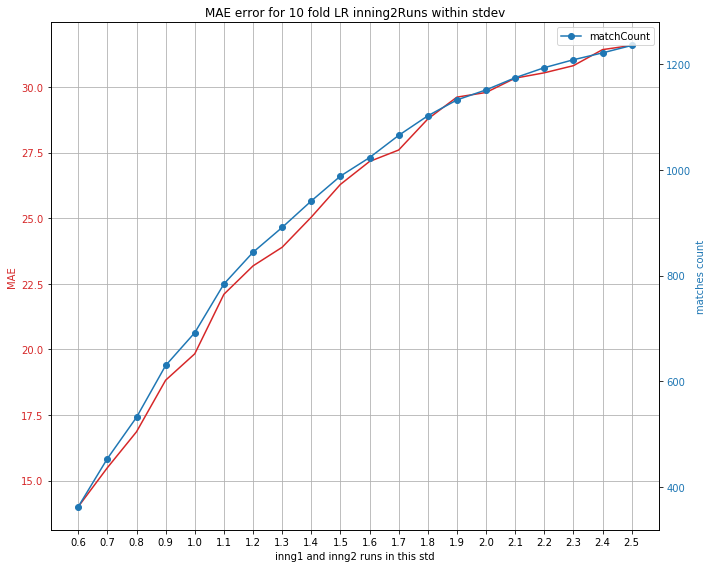

In [601]:
import matplotlib.pyplot as plt
#pdf2 = PdfPages((str(matchinProgressDataFolderResult)+"innings_1_2_prediction_with_Std_remBAN_ZIM_results.pdf"))
# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = MAE_Data #np.exp(t)
data2 = data_length#np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots(figsize=(10,8))

color = 'tab:red'
ax1.set_xlabel('inng1 and inng2 runs in this std')
ax1.set_ylabel('MAE', color=color)
ax1.plot(stdTickArray, data1, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('matches count', color=color)  # we already handled the x-label with ax1
ax2.plot(stdTickArray, data2,'go-', color=color, label='matchCount')
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set
plt.title("MAE error for "+str(kfolds)+" fold LR "+str(targetVar)+" within stdev")
plt.xticks(stdTickArray)
plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
pdf2.savefig(fig)
pdf2.close()

In [602]:
inning1FeatureVector_trainTest.columns

Index(['inning1Runs', 'innings1Wickets', 'batsmenOfClust_2',
       'batsmenOfClust_3', 'batsmenOfClust_0', 'batsmenOfClust_1',
       'batsmenOfClust_4', 'bowlerOfClust_2', 'bowlerOfClust_3',
       'bowlerOfClust_0', 'bowlerOfClust_1', 'bowlerOfClust_4', 'team1c_1',
       'team1c_2', 'team1c_3', 'team2c_1', 'team2c_2', 'team2c_3',
       'VenueClass_1'],
      dtype='object')

In [ ]:
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold # import KFold


def RegressionFor1Type(inning1FeatureVector_train,inning1FeatureVector_testData,ytrain,ytest):#,fileWrite):
    
    MAE_array=[]
    RMSE_array=[]
    MA_array=[]

#     fileWrite =  open(str(matchinProgressDataFolderResult)+"inprogressOfInning1_50oversPrediction_LR.csv",'a')
#     fileWrite.write(str(inningsOver)+',')
#     fileWrite.write(str(kfolds)+',')
#     fileWrite.write(str(dataConstraint)+',')
#     fileWrite.write(str(targetVar)+',')
    

    inning1FeatureVector_X,inning1FeatureVector_Y, ytrain,ytest = inning1FeatureVector_train, inning1FeatureVector_testData,ytrain,ytest

    
   
    
    
    
    reg = linear_model.Ridge(alpha=.8).fit(inning1FeatureVector_X, ytrain)#   LinearRegression().normalize=True

    
#     print('Coefficients: ')
#     print(reg.coef_)
#     print("intercept", reg.intercept_)
    inning1FeatureVector_test = inning1FeatureVector_Y.copy()
    inning1FeatureVector_test[targetVar]=0
    inning1FeatureVector_test[targetVar] = ytest #**runsConvert

#     y_pred = reg.predict(inning1FeatureVector_Y)
    y_pred  = y_pred.astype(int)
    inning1FeatureVector_test['inning1RunsPred'] = y_pred #**runsConvert


    inning1FeatureVector_test['AbsError'] = abs(inning1FeatureVector_test[targetVar] - inning1FeatureVector_test['inning1RunsPred'])

    #print("MAE", inning1FeatureVector_test['AbsError'].mean())
    #print("Median Abs Error ",inning1FeatureVector_test['AbsError'].median())

#     MA_array.append(inning1FeatureVector_test['AbsError'].median())

#     MAE_Records.append(mean_absolute_error(ytest, y_pred))


#     RMSE_array.append(np.sqrt(mean_squared_error(ytest, y_pred)))


#     inning1FeatureVector_test.to_csv(str(matchinProgressDataFolderResult)+"innings1ScoresProjectionOver_"+str(inningsOver)+"_Regression_Data_"+str(dataConstraint)+"_"+str(tSize)+".csv")

    #fileWrite.write(str(round(np.mean(MAE_array),2))+',')
    #MAE_Records.append(round(np.mean(MAE_array),3))
    MAE_Records.append(mean_absolute_error(ytest, y_pred))
    
    #fileWrite.write(str(round(np.mean(RMSE_array),2)))
    #fileWrite.write('\n')
    #fileWrite.close()
    return np.array(inning1FeatureVector_test['AbsError']),y_pred
     

## Regression without Interaction Terms

In [19]:
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold # import KFold


def RegressionForRandomSplit(inning1FeatureVector_train,inning1FeatureVector_testData,ytrain,ytest,y,inningsOver,targetVar,overTest,tSize=0.1):#,fileWrite):
#      inning1FeatureVector_X,inning1FeatureVector_Y, ytrain,ytest = train_test_split(inning1FeatureVector_trainTest,y ,test_size=tSize)
#         else:
    MAE_array=[]
    RMSE_array=[]
    MA_array=[]

#     fileWrite =  open(str(matchinProgressDataFolderResult)+"inprogressOfInning1_50oversPrediction_LR.csv",'a')
#     fileWrite.write(str(inningsOver)+',')
#     fileWrite.write(str(kfolds)+',')
#     fileWrite.write(str(dataConstraint)+',')
#     fileWrite.write(str(targetVar)+',')
    
    


    runsTrans=1  #1/2
    runsConvert=1 #2


    #X=inning1FeatureVector_trainTest


    testingSize=[0.1,0.2,0.3]  #[0.1,0.15,0.20,0.25,0.30]
    #with PdfPages((str(matchinProgressDataFolderResult)+"innings1ScoresProjectionOver_"+str(inningsOver)+"_Regression_Data_"+str(dataConstraint)+"_LR.pdf")) as pdf:
#     for tSize in testingSize:
#         print('tSize',tSize)
    for i in range(1):
#         if(overTest==0):
#             inning1FeatureVector_X,inning1FeatureVector_Y, ytrain,ytest = train_test_split(inning1FeatureVector_trainTest,y ,test_size=tSize)
#         else:
        inning1FeatureVector_X,inning1FeatureVector_Y, ytrain,ytest = inning1FeatureVector_train, inning1FeatureVector_testData,ytrain,ytest

        reg = LinearRegression().fit(inning1FeatureVector_X, ytrain)# normalize=True
        #print(reg.score(inning1FeatureVector_X, ytrain))
        #print((inning1FeatureVector_train.columns),len(ytrain), (inning1FeatureVector_test.columns),len(ytest))   

        
        inning1FeatureVector_test = inning1FeatureVector_Y.copy()
        inning1FeatureVector_test[targetVar]=0
        inning1FeatureVector_test[targetVar] = ytest #**runsConvert

        y_pred = reg.predict(inning1FeatureVector_Y)

        inning1FeatureVector_test['inning1RunsPred'] = y_pred #**runsConvert


        inning1FeatureVector_test['AbsError'] = abs(inning1FeatureVector_test[targetVar] - inning1FeatureVector_test['inning1RunsPred'])

        #print("MAE", inning1FeatureVector_test['AbsError'].mean())
        #print("Median Abs Error ",inning1FeatureVector_test['AbsError'].median())

        MA_array.append(inning1FeatureVector_test['AbsError'].median())

        MAE_array.append(mean_absolute_error(ytest, y_pred))

        #MAE_array.append(mean_absolute_error(runs_test, runs_pred))
        #print('MAE',mean_absolute_error(ytest, y_pred))
    #     #print('RMSE',np.sqrt(mean_squared_error(ytest, y_pred)))
       # RMSE_array.append(np.sqrt(mean_squared_error(ytest, y_pred)))
        RMSE_array.append(np.sqrt(mean_squared_error(ytest, y_pred)))


#     inning1FeatureVector_test.to_csv(str(matchinProgressDataFolderResult)+"innings1ScoresProjectionOver_"+str(inningsOver)+"_Regression_Data_"+str(dataConstraint)+"_"+str(tSize)+".csv")

#     fig=plt.figure(figsize=(8,6))
#     plt.hist(inning1FeatureVector_test['AbsError'], bins=20, rwidth=0.7)
#     plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55,60])
#     plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150])
#     plt.xlabel("Absolut Error: Inning1 Runs Prediction_"+str(tSize)+"_LR")
#     plt.ylabel("Match Count")
#     plt.title("Inning1 Runs Prediction MAE:_Data_"+str(dataConstraint)+" (LR)")#g180, l400 
#     plt.show()
#     pdf.savefig(fig)


    #plt.savefig(str(inning1BeforeStartProjectionFolder)+"innings1ScoresProjection_Regression_g180_l400_"+str(tSize)+".pdf")
    print('mean for all MAE:', np.mean(MAE_array))
    print('mean of median for all MAE:', np.mean(MA_array))
    print('median of median for all MAE:', np.median(MA_array))
    print('mean for all RMSE:', np.mean(RMSE_array))
    
    #fileWrite.write(str(round(np.mean(MAE_array),2))+',')
    MAE_Records.append(round(np.mean(MAE_array),3))
#     fileWrite.write(str(round(np.mean(RMSE_array),2)))
#     fileWrite.write('\n')
#     fileWrite.close()
    return MAE_Records
     

## Regression k-Fold Cross Validation

In [48]:
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold # import KFold
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

#inning1FeatureVectorComplete['inning1Runs'] = inning1FeatureVectorComplete['inning1Runs']**2

def RegressionForkFold(inning1FeatureVector_trainTest,y,inningsOver,kfolds,targetVar,fileNameOut,runsConvert): #,fileWrite):
            
    inningFeatureVectorCompleteData = pd.DataFrame()
    MAE_array=[]
    RMSE_array=[]
    MA_array=[]

#     fileWrite =  open(fileNameOut,'a')
#     fileWrite.write(str(inningsOver)+',')
#     fileWrite.write(str(kfolds)+',')
#     fileWrite.write(str(dataConstraint)+',')
#     fileWrite.write(str(targetVar)+',')
    
    
    X=inning1FeatureVector_trainTest

    #print(X.columns)

    kf = KFold(n_splits=kfolds)#,random_state=5,shuffle=True) # Define the split - into 2 folds 
    kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
    print(kf)


    #with PdfPages((str(matchinProgressDataFolderResult)+"innings1ScoresProjectionOver_"+str(inningsOver)+"_Regression_"+str(kfolds)+"fold_Data_"+str(dataConstraint)+"_targetVar_"+str(targetVar)+"_LR.pdf")) as pdf:


    for train_index, test_index in kf.split(X):


        inning1FeatureVector_X, inning1FeatureVector_Y = X.iloc[train_index], X.iloc[test_index]

        #print(inning1FeatureVector_Y)
        #print(X.iloc[train_index[0]])
        ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
        #print(ytrain)
        #print('train: ',len(inning1FeatureVector_X),'test:',len(inning1FeatureVector_Y))
        #print(len(inning1FeatureVector_Y),len(ytest))
        
        ytrain = ytrain.astype(int)
        ytest = ytest.astype(int)

        #dtr = DecisionTreeRegressor()
        #reg = BaggingRegressor(DecisionTreeRegressor(criterion='mae',max_features='auto'),n_estimators=20)#, n_estimators=10,max_samples=0.30)


        #reg = BaggingRegressor(LinearRegression(), n_estimators=100,max_samples=5)

        #reg = BaggingClassifier(KNeighborsClassifier(n_neighbors=50))#,n_estimators=30)# max_samples=1)#, max_features=0.5)

        

        




        #reg = LinearRegression(normalize=True) #  
        
        reg = linear_model.Ridge(alpha=.8) #  LinearRegression().normalize=True



        reg = reg.fit(inning1FeatureVector_X, np.array(ytrain))
        
        #y_pred = clf.predict(inning1FeatureVector_Y)
        #print('parameters',reg.coef_)

        #reg = LinearRegression().fit(inning1FeatureVector_X, ytrain) #normalize=True
        #print(reg.score(inning1FeatureVector_X, ytrain))

        inning1FeatureVector_test = inning1FeatureVector_Y.copy()
        inning1FeatureVector_test[targetVar]=0
        inning1FeatureVector_test[targetVar] = ytest**runsConvert

        y_pred = reg.predict(inning1FeatureVector_Y)

        inning1FeatureVector_test['inning1RunsPred'] = y_pred**runsConvert

        
        
        
        inning1FeatureVector_test['AbsError'] = abs(inning1FeatureVector_test[targetVar] - inning1FeatureVector_test['inning1RunsPred'])

        frames  =[inningFeatureVectorCompleteData,inning1FeatureVector_test]
        inningFeatureVectorCompleteData = pd.concat(frames)

        
        
        for k in range(len(inning1FeatureVector_test)):
            if(inning1FeatureVector_test[targetVar].iloc[k]==0):
                MA_array.append(inning1FeatureVector_test['AbsError'].iloc[k]*100)
            else:
                #print("Mean %age error",(round(inning1FeatureVector_test['AbsError'].iloc[k]/inning1FeatureVector_test[targetVar].iloc[k],4))*100)
                MA_array.append((round(inning1FeatureVector_test['AbsError'].iloc[k]/inning1FeatureVector_test[targetVar].iloc[k],4))*100)
        
        MAE_array.append(mean_absolute_error(ytest, y_pred))
        
    #   #MAE_array.append(mean_absolute_error(runs_test, runs_pred))

        #print('MAE',mean_absolute_error(ytest, y_pred))
        #print('RMSE',np.sqrt(mean_squared_error(ytest, y_pred)))

        RMSE_array.append(np.sqrt(mean_squared_error(ytest, y_pred)))
    #         RMSE_array.append(np.sqrt(mean_squared_error(runs_test, runs_pred)))


    #inning1FeatureVector_test.to_csv(str(matchinProgressDataFolderResult)+"innings1ScoresProjectionOver_"+str(inningsOver)+"_Regression_Data_"+str(dataConstraint)+"_targetVar_"+str(targetVar)+"_"+str(kfolds)+"Fold_MAE_"+str(int(mean_absolute_error(ytest, y_pred)))+".csv")

#         fig=plt.figure(figsize=(8,6))
#         plt.hist(inning1FeatureVector_test['AbsError'], bins=20, rwidth=0.7)
#         plt.yticks([0,5,10,15,20,25,30,35,40,45])
#         plt.xticks([10,20,30,40,50,60,70,80,90,100,110,120,130,140])
#         plt.xlabel("Absolut Error: Inning1 Runs Prediction")
#         plt.ylabel("Match Count")
#         plt.title("Inning1 Runs Prediction MAE:_Data"+str(dataConstraint)+" (LR)"+str(kfolds)+"fold_MAE_"+str(int(mean_absolute_error(ytest, y_pred))))#g180, l400 

#         plt.grid()
#         #plt.show()
#         pdf.savefig(fig)


    #     #plt.savefig(str(inning1BeforeStartProjectionFolder)+"innings1ScoresProjection_Regression_g180_l400_"+str(tSize)+".pdf")
    print('mean for all MAE:', np.mean(MAE_array))
    print('mean % for all MAE:', np.mean(MA_array))
    #         print('median of median for all MAE:', np.median(MA_array))
    print('mean for all RMSE:', np.mean(RMSE_array))

    print('Coefficients ', reg.coef_)
    MAE_Records.append(round(np.mean(MAE_array),3))
#     fileWrite.write(str(round(np.mean(MAE_array),2))+',')
   
#     fileWrite.write(str(round(np.mean(RMSE_array),2)))
#     fileWrite.write('\n')
#     fileWrite.close()
    return round(np.mean(MA_array),3),inningFeatureVectorCompleteData #MAE_Records

In [408]:
# fig=plt.figure(figsize=(8,6))
# plt.boxplot(MAE_array,meanline=True)
# plt.title("MAE boxplot for "+str(kfolds)+" fold LR targetVar_"+str(targetVar))
# plt.xlabel("MAE box plot")
# plt.ylabel("Mean Absolute Error")
# plt.grid()
# plt.show()
# #plt.savefig((str(matchinProgressDataFolderResult)+"innings1ScoresProjection_LR_"+str(kfolds)+"fold_Data_"+str(dataConstraint)+"_targetVar_"+str(targetVar)+"_MAE_boxplot.pdf"))

## KNN with K-fold cross validation 

In [23]:
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold # import KFold


def KNNForkFold(inning1FeatureVector_trainTest,y,inningsOver,kfolds,knbrs,targetVar):#,fileWrite):
    MAE_array=[]
    RMSE_array=[]
    MA_array=[]
    inningFeatureVectorCompleteData =pd.DataFrame()
#     fileWrite =  open(str(matchinProgressDataFolderResult)+"inprogressOfInning1_50oversPrediction_KNN.csv",'a')
#     fileWrite.write(str(inningsOver)+',')
#     fileWrite.write(str(kfolds)+',')
#     fileWrite.write(str(knbrs)+',')
#     fileWrite.write(str(dataConstraint)+',')
#     fileWrite.write(str(targetVar)+',')
   




    runsTrans=1  #1/2
    runsConvert=1 #2
    #inning1FeatureVectorComplete = inning1FeatureVectorComplete[~((inning1FeatureVectorComplete['inning1Runs']) < (Q1 - 1.5 * IQR)) | ((inning1FeatureVectorComplete['inning1Runs']) > (Q3 + 1.5 * IQR))]

    X=inning1FeatureVector_trainTest


    kf = KFold(n_splits=kfolds) # Define the split - into 2 folds 
    kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
    print(kf)



    nbrs=[10,20,50,100]
    K_neighbors= knbrs 
    # for K_neighbors in nbrs:

    print('K_neighbors', K_neighbors)



    #with PdfPages((str(matchinProgressDataFolderResult)+"innings1ScoresProjection_KNN_k"+str(K_neighbors)+"_"+str(kfolds)+"fold_targetVar_"+str(targetVar)+"_Data_"+str(dataConstraint)+".pdf")) as pdf:


    for train_index, test_index in kf.split(X):


        inning1FeatureVector_X, inning1FeatureVector_Y = X.iloc[train_index], X.iloc[test_index]

        #print(inning1FeatureVector_Y)
        #print(X.iloc[train_index[0]])
        ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
        #print(ytrain)
        #print('train: ',len(inning1FeatureVector_X),'test:',len(inning1FeatureVector_Y))

        inning1FeatureVector_train=pd.DataFrame()
        inning1FeatureVector_train = inning1FeatureVector_X.copy()

        inning1FeatureVector_train[targetVar]=0
        inning1FeatureVector_train[targetVar] = ytrain

        inning1FeatureVector_test = inning1FeatureVector_Y.copy()
        inning1FeatureVector_test[targetVar]=0
        inning1FeatureVector_test[targetVar] = ytest


        #trainX = inning1FeatureVector_X 
        nbrs = NearestNeighbors(n_neighbors=K_neighbors, algorithm='ball_tree', metric='euclidean').fit(inning1FeatureVector_X) 
        #trainY= inning1FeatureVector_Y   #np.array([[0,1],[3,4]])
        distances, indices = nbrs.kneighbors(inning1FeatureVector_Y)
        #indices     

        inning1RunsPredicted=[]
        for i in range(len(inning1FeatureVector_Y)):
            runsScored=0
            runsPredArray=[]
            for k in range(K_neighbors):
                runsPredArray.append(inning1FeatureVector_train[targetVar].iloc[indices[i][k]])
                #runsScored  = runsScored + inning1FeatureVector_train['inning1Runs'].iloc[indices[i][k]]
            inning1RunsPredicted.append(int(np.mean(runsPredArray)))   
            #inning1RunsPredicted.append(int(runsScored/5))

        #print('Length of predicted data:', len(inning1RunsPredicted))
        inning1FeatureVector_test['inning1RunsPredicted'] = inning1RunsPredicted
        y_pred = inning1RunsPredicted

        inning1FeatureVector_test['AbsError'] = abs(inning1FeatureVector_test[targetVar] - inning1FeatureVector_test['inning1RunsPredicted'])

        frames  =[inningFeatureVectorCompleteData,inning1FeatureVector_test]
        inningFeatureVectorCompleteData = pd.concat(frames)

        #print("MAE Median", inning1FeatureVector_test['AbsError'].median())

        #print('MAE',inning1FeatureVector_test['AbsError'].mean())
        #print('MAE med',inning1FeatureVector_test['AbsError'].median())

        MAE_array.append(inning1FeatureVector_test['AbsError'].mean())
        MA_array.append(inning1FeatureVector_test['AbsError'].median())
        rmse=0
        for i in range(len(inning1FeatureVector_test)):
            rmse = rmse + ( (inning1FeatureVector_test[targetVar].iloc[i] - inning1FeatureVector_test['inning1RunsPredicted'].iloc[i])**2)

        maError = mean_absolute_error(ytest, inning1RunsPredicted)

        MA_array.append((maError))

        #print('RMSE : ',np.sqrt(rmse/len(inning1FeatureVector_test)))
        RMSE_array.append(np.sqrt(rmse/len(inning1FeatureVector_test)))


#         inning1FeatureVector_test.to_csv(str(matchinProgressDataFolderResult)+"innings1ScoresProjection_KNN_K_"+str(K_neighbors)+"_Data_"+str(dataConstraint)+"_targetVar_"+str(targetVar)+"_"+str(kfolds)+"Fold_MAE_"+str(int(mean_absolute_error(ytest, y_pred)))+".csv")

#         inning1FeatureVector_test['AbsError'] = inning1FeatureVector_test['AbsError'].astype(int)
#         fig=plt.figure(figsize=(8,6))
#         plt.hist(inning1FeatureVector_test['AbsError'],  rwidth=0.7)#,bins=10) #bins=7,
#         plt.yticks([0,5,10,15,20,25,30])#,25,30,35,40])
#         plt.xticks([0,10,20,30,40,50,60,70,80,90,100])#,110,120,130,140])
#         plt.xlabel("Absolut Error: targetVar_"+str(targetVar)+" Prediction_KNN")
#         plt.ylabel("Match Count")
#         plt.title("Inning1 Runs Prediction MAE:_Data_"+str(dataConstraint)+" (KNN)_K_"+str(K_neighbors)+"_"+str(kfolds)+"fold_MAE_"+str(int(mean_absolute_error(ytest, y_pred))))#g180, l400 

#         plt.grid()
#         plt.show()
        #pdf.savefig(fig)


    #     #plt.savefig(str(inning1BeforeStartProjectionFolder)+"innings1ScoresProjection_Regression_g180_l400_"+str(tSize)+".pdf")
    print('mean for all MAE:', np.mean(MAE_array))
    print('median for all MAE:', np.median(MAE_array))
    #         print('median of median for all MAE:', np.median(MA_array))
    print('mean for all RMSE:', np.mean(RMSE_array))
#     fileWrite.write(str(round(np.mean(MAE_array),2))+',')
#     fileWrite.write(str(round(np.mean(RMSE_array),2)))
#     fileWrite.write('\n')
#     fileWrite.close()
    return round(np.mean(MAE_array),2),inningFeatureVectorCompleteData

In [499]:
# fig=plt.figure(figsize=(8,6))
# plt.boxplot(MAE_array,meanline=True)
# plt.title("MAE boxplot for "+str(kfolds)+" fold KNN_K_"+str(K_neighbors)+"targetVar_"+str(targetVar))
# plt.xlabel("MAE box plot")
# plt.ylabel("Mean Absolute Error")
# plt.grid()
# # plt.show()
# plt.savefig((str(matchinProgressDataFolderResult)+"innings1ScoresProjection_KNN_K_"+str(K_neighbors)+"_"+str(kfolds)+"fold_Data_"+str(dataConstraint)+"_targetVar_"+str(targetVar)+"_MAE_boxplot.pdf"))

1558 65


In [125]:
from sklearn.neighbors import NearestNeighbors

MAE_array=[]

RMSE_array=[]

for i in range(100):
    
    inning1FeatureVector_X,inning1FeatureVector_Y, ytrain,ytest = train_test_split(inning1FeatureVector_trainTest,y ,test_size=0.30)

    inning1FeatureVector_train=pd.DataFrame()
    inning1FeatureVector_train = inning1FeatureVector_X.copy()

    inning1FeatureVector_train['inning1ProjectedScore']=0
    inning1FeatureVector_train['inning1ProjectedScore'] = ytrain

    inning1FeatureVector_test = inning1FeatureVector_Y.copy()
    inning1FeatureVector_test['inning1ProjectedScore']=0
    inning1FeatureVector_test['inning1ProjectedScore'] = ytest
    
    K_neighbors = 20
    X = inning1FeatureVector_X 
    nbrs = NearestNeighbors(n_neighbors=K_neighbors, algorithm='ball_tree', metric='euclidean').fit(X) 
    Y= inning1FeatureVector_Y   #np.array([[0,1],[3,4]])
    distances, indices = nbrs.kneighbors(Y)
    #indices     

    inning1RunsPredicted=[]
    for i in range(len(inning1FeatureVector_Y)):
        runsScored=0
        runsPredArray=[]
        for k in range(K_neighbors):
            runsPredArray.append(inning1FeatureVector_train['inning1ProjectedScore'].iloc[indices[i][k]])
            #runsScored  = runsScored + inning1FeatureVector_train['inning1Runs'].iloc[indices[i][k]]
        inning1RunsPredicted.append(int(np.mean(runsPredArray)))   
        #inning1RunsPredicted.append(int(runsScored/5))
    
    #print('Length of predicted data:', len(inning1RunsPredicted))
    inning1FeatureVector_test['inning1RunsPredicted'] = inning1RunsPredicted
    inning1FeatureVector_test['AbsError'] = abs(inning1FeatureVector_test['inning1ProjectedScore'] - inning1FeatureVector_test['inning1RunsPredicted'])

    #print("MAE", inning1FeatureVector_test['AbsError'].mean())
    MAE_array.append(inning1FeatureVector_test['AbsError'].mean())
    rmse=0
    for i in range(len(inning1FeatureVector_test)):
        rmse = rmse + ( (inning1FeatureVector_test['inning1ProjectedScore'].iloc[i] - inning1FeatureVector_test['inning1RunsPredicted'].iloc[i])**2)

    #print('RMSE : ',np.sqrt(rmse/len(inning1FeatureVector_test)))
    RMSE_array.append(np.sqrt(rmse/len(inning1FeatureVector_test)))
print(len(ytrain), len(ytest))

print("Mean of Mean Abs Error:", np.mean(MAE_array))
print("Mean RMSE  Error:", np.mean(RMSE_array))

#inning1FeatureVector_test.to_csv(str(matchinProgressDataFolder)+"innings1ScoresProjection_2011_12_KNN_k_with_home_euclidean_"+str(K_neighbors)+".csv")

1136 487
Mean of Mean Abs Error: 44.57735112936345
Mean RMSE  Error: 55.75622008397617


In [ ]:
##   SVM   

In [111]:
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC

MAE_array=[]

RMSE_array=[]

for i in range(2):
    
    inning1FeatureVector_X,inning1FeatureVector_Y, ytrain,ytest = train_test_split(inning1FeatureVector_trainTest,y ,test_size=0.15)

    inning1FeatureVector_train=pd.DataFrame()
    inning1FeatureVector_train = inning1FeatureVector_X.copy()

    inning1FeatureVector_train['inning1ProjectedScore']=0
    inning1FeatureVector_train['inning1ProjectedScore'] = ytrain

    inning1FeatureVector_test = inning1FeatureVector_Y.copy()
    inning1FeatureVector_test['inning1ProjectedScore']=0
    inning1FeatureVector_test['inning1ProjectedScore'] = ytest
    
    K_neighbors = 200
    X = inning1FeatureVector_X 
    svclassifier = SVC(kernel='linear')
    
    svclassifier.fit(inning1FeatureVector_X, ytrain)
    y_pred = svclassifier.predict(inning1FeatureVector_Y)
         

    inning1RunsPredicted= y_pred
#     for i in range(len(inning1FeatureVector_Y)):
#         runsScored=0
#         runsPredArray=[]
#         for k in range(K_neighbors):
#             runsPredArray.append(inning1FeatureVector_train['inning1ProjectedScore'].iloc[indices[i][k]])
#             #runsScored  = runsScored + inning1FeatureVector_train['inning1Runs'].iloc[indices[i][k]]
#         inning1RunsPredicted.append(int(np.mean(runsPredArray)))   
#         #inning1RunsPredicted.append(int(runsScored/5))
    

    inning1FeatureVector_test['inning1RunsPredicted'] = inning1RunsPredicted
    inning1FeatureVector_test['AbsError'] = abs(inning1FeatureVector_test['inning1ProjectedScore'] - inning1FeatureVector_test['inning1RunsPredicted'])

    #print("MAE", inning1FeatureVector_test['AbsError'].mean())
    MAE_array.append(inning1FeatureVector_test['AbsError'].mean())
    rmse=0
    for i in range(len(inning1FeatureVector_test)):
        rmse = rmse + ( (inning1FeatureVector_test['inning1ProjectedScore'].iloc[i] - inning1FeatureVector_test['inning1RunsPredicted'].iloc[i])**2)

    #print('RMSE : ',np.sqrt(rmse/len(inning1FeatureVector_test)))
    RMSE_array.append((inning1FeatureVector_test['AbsError'].mean()))
print(len(ytrain), len(ytest))
print("Median Abs Error:", np.median(MAE_array))
print("Median RMSE  Error:", np.median(RMSE_array))
print("Mean of Mean Abs Error:", np.mean(MAE_array))
print("Mean RMSE  Error:", np.mean(RMSE_array))
#inning1FeatureVector_test.to_csv(str(matchinProgressDataFolder)+"innings1ScoresProjection_2011_12_KNN_k_with_home_euclidean_"+str(K_neighbors)+".csv")

1336 236
Median Abs Error: 53.84957627118644
Median RMSE  Error: 53.84957627118644
Mean of Mean Abs Error: 53.84957627118644
Mean RMSE  Error: 53.84957627118644


# Bagging 

In [158]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

MAE_array=[]

RMSE_array=[]

for i in range(150):
    
    inning1FeatureVector_X,inning1FeatureVector_Y, ytrain,ytest = train_test_split(inning1FeatureVector_trainTest,y ,test_size=0.10)

    inning1FeatureVector_train=pd.DataFrame()
    inning1FeatureVector_train = inning1FeatureVector_X.copy()

    inning1FeatureVector_train['inning1ProjectedScore']=0
    inning1FeatureVector_train['inning1ProjectedScore'] = ytrain

    inning1FeatureVector_test = inning1FeatureVector_Y.copy()
    inning1FeatureVector_test['inning1ProjectedScore']=0
    inning1FeatureVector_test['inning1ProjectedScore'] = ytest
    
   
    Xtrain = inning1FeatureVector_X 
    
    
    #dtr = DecisionTreeRegressor()
    #clf = BaggingRegressor(DecisionTreeRegressor(criterion='mse',max_features='log2'), n_estimators=10,max_samples=0.30)
    
    clf = BaggingRegressor(LinearRegression(), n_estimators=40)#,max_samples=0.30)
    
    
 
    clf = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)

    clf = clf.fit(inning1FeatureVector_X, ytrain)
    
    #reg = LinearRegression().fit(inning1FeatureVector_X, ytrain)
    
    y_pred = clf.predict(inning1FeatureVector_Y)
   
    
#     reg = linear_model.Ridge(alpha=.8)
#     reg.fit(inning1FeatureVector_X, ytrain)
#     y_pred = reg.predict(inning1FeatureVector_Y)
    inning1FeatureVector_test['inning1RunsPred'] = y_pred
    

    maError = mean_absolute_error(ytest, y_pred)
    
    RMSE_array.append(np.sqrt(mean_squared_error(ytest, y_pred)))
    #print("MAE ", maError)
    MAE_array.append(maError)
    

#     #print('RMSE : ',np.sqrt(rmse/len(inning1FeatureVector_test)))
#     RMSE_array.append(np.sqrt(rmse/len(inning1FeatureVector_test)))
# print(len(ytrain), len(ytest))
print("Median Abs Error:", np.median(MAE_array))
#print("Median RMSE  Error:", np.median(RMSE_array))
print("Mean of Mean Abs Error:", np.mean(MAE_array))
print("Mean RMSE  Error:", np.mean(RMSE_array))
#inning1FeatureVector_test.to_csv(str(matchinProgressDataFolder)+"innings1ScoresProjection_2011_12_KNN_k_with_home_euclidean_"+str(K_neighbors)+".csv")

Median Abs Error: 40.470688505941176
Mean of Mean Abs Error: 40.54463930690786
Mean RMSE  Error: 50.19672958172168
